In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Oct 4: For difference panels of ivt, tpw, d18Op, I only shade where the change from the upper to lower quartile is significant, 95% via 2-two tailed T-test
### I don't have the ASL location and variability on MERRA, bc there is not d18Op plots...

# iCESM  Water Vapor Transport (IVT)
## Pac_60to80S
## wrt JJA, DJF, Ann Mean SAM
## Note, the variables are detrended, but makes very little difference in the results
## FIX - 03Oct2019 - Calculating Magnitudes of IVT on yearly seasonal scales then time meaning across the upper/lower samples --- fix to match stats of significance

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
import matplotlib.path as mpath
import datetime
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy import signal
from IPython.display import display
import xarray as xr
import dask as da
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.array.rechunk import rechunk
from mpl_toolkits.basemap import Basemap #, add_cyclic_point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import statsmodels.api as sm
from cartopy.util import add_cyclic_point
import netCDF4
from scipy import stats
import matplotlib.pyplot as plt

#for era
# from eofs.xarray import Eof
# from eofs.examples import example_data_path
# np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [3]:
############# to be set #############

                         
##Load ERA indice .pkl's
PICKLE_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_Indices_as_CSV_19Nov2018'

##Save figure file path
FIG_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Figures_For_REVIEW_Submission_24March2021'

##Load CTRL netcdf as Xarray
CTRL_DATA_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'
CTRL_DATA = xr.open_dataset(CTRL_DATA_PATH+'/CTRL_DATA_TAGGED.nc')
print(CTRL_DATA)

CTRL_DATA_PATH2 = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'
CTRL_DATA2 = xr.open_dataset(CTRL_DATA_PATH2+'/CTRL_DATA_TAGGED_VAPOR.nc')
print(CTRL_DATA2)

CTRL_DATA_PATH3 = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'
CTRL_DATA3 = xr.open_dataset(CTRL_DATA_PATH3+'/CTRL_DATA_TAGGED_VAPOR_TRANSPORT.nc')
print(CTRL_DATA3)

CTRL_DATA_PATH4 = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'
CTRL_DATA4 = xr.open_dataset(CTRL_DATA_PATH4+'/CTRL_DATA_TAGGED_VAPOR_TRANSPORT_from_Q.nc')
print(CTRL_DATA4)


<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144, time: 912)
Coordinates:
  * time          (time) datetime64[ns] 1701-01-31 1701-02-28 ... 1776-12-31
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables: (12/61)
    land_frac     (time, lat, lon) float32 ...
    sst           (time, lat, lon) float32 ...
    msl           (time, lat, lon) float32 ...
    u10           (time, lat, lon) float32 ...
    v10           (time, lat, lon) float32 ...
    t2m           (time, lat, lon) float32 ...
    ...            ...
    tp_Ind_65     (time, lat, lon) float32 ...
    tp_Ind_75     (time, lat, lon) float32 ...
    d18O_AA_ice   (time, lat, lon) float32 ...
    d18O_AA_land  (time, lat, lon) float32 ...
    tp_AA_ice     (time, lat, lon) float32 ...
    tp_AA_land    (time, lat, lon) float32 ...
<xarray.Dataset>
Dimensions:                        (lat: 96, lev: 30, l

In [4]:

#DEFINING THESE GENERAL VARIABLES USING THE TAGGED REGIONS FOR THE NOTEBOOK!!!!!!
#gettig variables in right units 
#iCESM
slp_tmon_ctrl = CTRL_DATA.data_vars['msl']/100 #hPa
v10_tmon_ctrl = CTRL_DATA.data_vars['v10'] #in m/s at 10m
u10_tmon_ctrl = CTRL_DATA.data_vars['u10'] #in m/s at 10m
t2m_tmon_ctrl = CTRL_DATA.data_vars['t2m']-273.15 #in C
tp_tmon_ctrl  = CTRL_DATA.data_vars['tp']*60*60*24*1000  #in mm/day
total_prec_water_tmon_ctrl1 = CTRL_DATA2.data_vars['Pac_65_H2OV_total_prec_water'] #mm
total_prec_water_tmon_ctrl2 = CTRL_DATA2.data_vars['Pac_75_H2OV_total_prec_water'] #mm
total_prec_water_tmon_ctrl = total_prec_water_tmon_ctrl1 + total_prec_water_tmon_ctrl2
#Weight of d18O of vapor (change as of 06Apr2021)
d18O_V_tmon_ctrl1 = CTRL_DATA2.data_vars['d18O_V_Pac_65']*(CTRL_DATA2.data_vars['Pac_65_H2OV_total_prec_water']/CTRL_DATA2.data_vars['H2OV_total_prec_water']) #per mill
d18O_V_tmon_ctrl2 = CTRL_DATA2.data_vars['d18O_V_Pac_75']*(CTRL_DATA2.data_vars['Pac_75_H2OV_total_prec_water']/CTRL_DATA2.data_vars['H2OV_total_prec_water']) #per mill
d18O_V_tmon_ctrl = d18O_V_tmon_ctrl1 + d18O_V_tmon_ctrl2 #per mill
#Weighting d18O of precip
d18O_tmon_ctrl1 = CTRL_DATA.data_vars['d18O_Pac_65']*((CTRL_DATA.data_vars['tp_Pac_65']*60*60*24*1000)/(CTRL_DATA.data_vars['tp']*60*60*24*1000)) #per mill
d18O_tmon_ctrl2 = CTRL_DATA.data_vars['d18O_Pac_75']*((CTRL_DATA.data_vars['tp_Pac_75']*60*60*24*1000)/(CTRL_DATA.data_vars['tp']*60*60*24*1000)) #per mill
# d18O_tmon_ctrl1 = CTRL_DATA.data_vars['d18O_Pac_65'] #per mill
# d18O_tmon_ctrl2 = CTRL_DATA.data_vars['d18O_Pac_75'] #per mill
d18O_tmon_ctrl = d18O_tmon_ctrl1 + d18O_tmon_ctrl2 #per mill
land_tmon_ctrl = CTRL_DATA.data_vars['land_frac']
H2OV_Zonal_IVT_tmon_ctrl = CTRL_DATA3.data_vars['Pac_60to80S_H2OV_Zonal_Transport_integrated'] #in kg m^-1 s^-1
H2OV_Meridional_IVT_tmon_ctrl = CTRL_DATA3.data_vars['Pac_60to80S_H2OV_Meridional_Transport_integrated'] #in kg m^-1 s^-1
H218OV_Zonal_IVT_tmon_ctrl = CTRL_DATA3.data_vars['Pac_60to80S_H218OV_Zonal_Transport_integrated'] #in kg m^-1 s^-1
H218OV_Meridional_IVT_tmon_ctrl = CTRL_DATA3.data_vars['Pac_60to80S_H218OV_Meridional_Transport_integrated'] #in kg m^-1 s^-1
Q_Zonal_IVT_tmon_ctrl = CTRL_DATA4.data_vars['Q_Zonal_Transport_integrated'] #in kg m^-1 s^-1
Q_Meridional_IVT_tmon_ctrl = CTRL_DATA4.data_vars['Q_Meridional_Transport_integrated'] #in kg m^-1 s^-1



### Below shows that in iCESM my calculations for IVT are the same whether I use column integrated water vapor or q (specific humidity)
### Therefore, I am not going to calculate IVT from column integrated water vapor for MERRA, and am just going to use the terms uflxqv and vflxqv

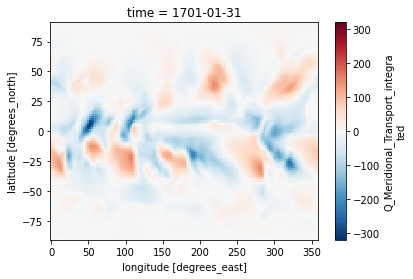

In [5]:
Q_Meridional_IVT_tmon_ctrl[0].plot()

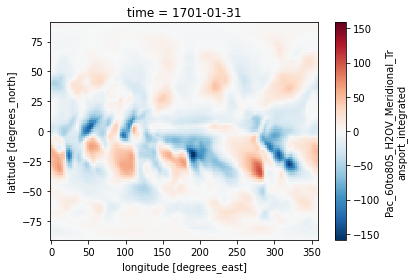

In [6]:
H2OV_Meridional_IVT_tmon_ctrl[0].plot()

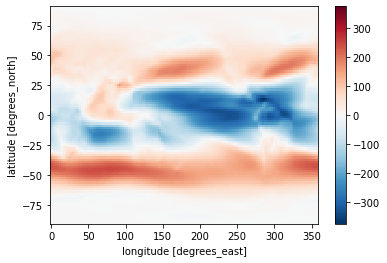

In [7]:
aa = Q_Zonal_IVT_tmon_ctrl[0:47].mean(axis=0) - H2OV_Zonal_IVT_tmon_ctrl[0:47].mean(axis=0)
aa.plot()

In [8]:
#Open pandas dfs of all indices and ASL information
pdo_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_pdo_tmon.pkl')
# pdo_index_ctrl.head(n=5)
pdo_seas_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_pdo_seas.pkl')
# pdo_seas_mean_index_ctrl.head(n=5)
pdo_ann_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_pdo_ann_mean.pkl')
# pdo_ann_mean_index_ctrl.head(n=5)

soi_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_tmon.pkl')
# soi_index_ctrl.head(n=5)
soi_seas_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_seas.pkl')
# soi_seas_mean_index_ctrl.head(n=5)
soi_ann_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_ann_mean.pkl')
# soi_ann_mean_index_ctrl.head(n=5)
soi_12roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_12roll_mean.pkl')
# soi_12roll_mean_index_ctrl.head(n=10)
soi_6roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_6roll_mean.pkl')
# soi_6roll_mean_index_ctrl.head(n=5)
soi_3roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_3roll_mean.pkl')
# soi_3roll_mean_index_ctrl.head(n=5)
soi_band_filt_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_band_filt.pkl')
# soi_band_filt_index_ctrl.head(n=5)

nino34_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_tmon.pkl')
# nino34_index_ctrl.head(n=5)
nino34_seas_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_seas.pkl')
# nino34_seas_mean_index_ctrl.head(n=5)
nino34_ann_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_ann_mean.pkl')
# nino34_ann_mean_index_ctrl.head(n=5)
nino34_12roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_12roll_mean.pkl')
# nino34_12roll_mean_index_ctrl.head(n=10)
nino34_6roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_6roll_mean.pkl')
# nino34_6roll_mean_index_ctrl.head(n=5)
nino34_3roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_3roll_mean.pkl')
# nino34_3roll_mean_index_ctrl.head(n=5)
nino34_band_filt_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_band_filt.pkl')
# nino34_band_filt_index_ctrl.head(n=5)

enso_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_tmon.pkl')
# enso_indices_ctrl.head(n=5)
enso_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_seas.pkl')
# enso_seas_mean_indices_ctrl.head(n=5)
enso_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_ann_mean.pkl')
# enso_ann_mean_indices_ctrl.head(n=5)
enso_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_12roll_mean.pkl')
# enso_12roll_mean_indices_ctrl.head(n=10)
enso_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_6roll_mean.pkl')
# enso_6roll_mean_indices_ctrl.head(n=5)
enso_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_3roll_mean.pkl')
# enso_3roll_mean_indices_ctrl.head(n=5)
enso_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_band_filt.pkl')
# enso_band_filt_indices_ctrl.head(n=5)

SAM_PSAs_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_tmon.pkl')
# SAM_PSAs_indices_ctrl.head(n=5)
SAM_PSAs_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_seas.pkl')
# SAM_PSAs_seas_mean_indices_ctrl.head(n=5)
SAM_PSAs_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_ann_mean.pkl')
print(SAM_PSAs_ann_mean_indices_ctrl.head(n=5))
SAM_PSAs_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_12roll_mean.pkl')
# SAM_PSAs_12roll_mean_indices_ctrl.head(n=10)
SAM_PSAs_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_6roll_mean.pkl')
# SAM_PSAs_6roll_mean_indices_ctrl.head(n=5)
SAM_PSAs_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_3roll_mean.pkl')
# SAM_PSAs_3roll_mean_indices_ctrl.head(n=5)
SAM_PSAs_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_band_filt.pkl')
# SAM_PSAs_band_filt_indices_ctrl.head(n=5)

df_d18O_psuedoWDC_tmon_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_tmon.pkl')
# df_d18O_psuedoWDC_tmon_ctrl.head(n=5)
d18O_psuedoWDC_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_seas.pkl')
# d18O_psuedoWDC_seas_mean_ctrl.head(n=5)
d18O_psuedoWDC_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_ann_mean.pkl')
# d18O_psuedoWDC_ann_mean_ctrl.head(n=5)
d18O_psuedoWDC_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_12roll_mean.pkl')
# d18O_psuedoWDC_12roll_mean_ctrl.head(n=10)
d18O_psuedoWDC_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_6roll_mean.pkl')
# d18O_psuedoWDC_6roll_mean_ctrl.head(n=5)
d18O_psuedoWDC_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_3roll_mean.pkl')
# d18O_psuedoWDC_3roll_mean_ctrl.head(n=5)
d18O_psuedoWDC_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_band_filt.pkl')
# d18O_psuedoWDC_band_filt_ctrl.head(n=5)

# df_d18O_psuedowestcore_tmon_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_tmon.pkl')
# # df_d18O_psuedowestcore_tmon_ctrl.head(n=5)
# d18O_psuedowestcore_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_seas.pkl')
# # d18O_psuedowestcore_seas_mean_ctrl.head(n=5)
# d18O_psuedowestcore_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_ann_mean.pkl')
# # d18O_psuedowestcore_ann_mean_ctrl.head(n=5)
# d18O_psuedowestcore_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_12roll_mean.pkl')
# # d18O_psuedowestcore_12roll_mean_ctrl.head(n=10)
# d18O_psuedowestcore_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_6roll_mean.pkl')
# # d18O_psuedowestcore_6roll_mean_ctrl.head(n=5)
# d18O_psuedowestcore_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_3roll_mean.pkl')
# # d18O_psuedowestcore_3roll_mean_ctrl.head(n=5)
# d18O_psuedowestcore_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_band_filt.pkl')
# # d18O_psuedowestcore_band_filt_ctrl.head(n=5)

# df_d18O_psuedoeastcore_tmon_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_tmon.pkl')
# # df_d18O_psuedoeastcore_tmon_ctrl.head(n=5)
# d18O_psuedoeastcore_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_seas.pkl')
# # d18O_psuedoeastcore_seas_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_ann_mean.pkl')
# # d18O_psuedoeastcore_ann_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_12roll_mean.pkl')
# # d18O_psuedoeastcore_12roll_mean_ctrl.head(n=10)
# d18O_psuedoeastcore_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_6roll_mean.pkl')
# # d18O_psuedoeastcore_6roll_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_3roll_mean.pkl')
# # d18O_psuedoeastcore_3roll_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_band_filt.pkl')
# # d18O_psuedoeastcore_band_filt_ctrl.head(n=5)

# d18O_wais_pcs_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_tmon.pkl')
# # d18O_wais_pcs_ctrl.head(n=5)
# d18O_wais_pcs_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_seas.pkl')
# # d18O_wais_pcs_seas_mean_ctrl.head(n=5)
# d18O_wais_pcs_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_ann_mean.pkl')
# # d18O_wais_pcs_ann_mean_ctrl.head(n=5)
# d18O_wais_pcs_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_12roll_mean.pkl')
# # d18O_wais_pcs_12roll_mean_ctrl.head(n=12)
# d18O_wais_pcs_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_6roll_mean.pkl')
# # d18O_wais_pcs_6roll_mean_ctrl.head(n=5)
# d18O_wais_pcs_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_3roll_mean.pkl')
# # d18O_wais_pcs_3roll_mean_ctrl.head(n=5)
# d18O_wais_pcs_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_band_filt.pkl')
# # d18O_wais_pcs_band_filt_ctrl.head(n=5)

# monthly_Rel_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_tmon.pkl')
# # monthly_Rel_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df.head(n=5)
# Rel_CP_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_seas_mean.pkl')
# # Rel_CP_seas_mean_indices_ctrl.head(n=5)
# Rel_CP_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_ann_mean.pkl')
# # Rel_CP_ann_mean_indices_ctrl.head(n=5)
# Rel_CP_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_12roll_mean.pkl')
# # Rel_CP_12roll_mean_indices_ctrl.head(n=10)
# Rel_CP_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_6roll_mean.pkl')
# # Rel_CP_6roll_mean_indices_ctrl.head(n=5)
# Rel_CP_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_3roll_mean.pkl')
# # Rel_CP_3roll_mean_indices_ctrl.head(n=5)
# Rel_CP_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_band_filt.pkl')
# # Rel_CP_band_filt_indices_ctrl.head(n=5)

# monthly_Abs_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_tmon.pkl')
# # monthly_Abs_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df.head(n=5)
# Abs_CP_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_seas_mean.pkl')
# # Abs_CP_seas_mean_indices_ctrl.head(n=5)
# Abs_CP_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_ann_mean.pkl')
# # Abs_CP_ann_mean_indices_ctrl.head(n=5)
# Abs_CP_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_12roll_mean.pkl')
# # Abs_CP_12roll_mean_indices_ctrl.head(n=10)
# Abs_CP_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_6roll_mean.pkl')
# # Abs_CP_6roll_mean_indices_ctrl.head(n=5)
# Abs_CP_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_3roll_mean.pkl')
# # Abs_CP_3roll_mean_indices_ctrl.head(n=5)
# Abs_CP_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_band_filt.pkl')
# # Abs_CP_band_filt_indices_ctrl.head(n=5)



#Raw Rel and Abs CP Info .... needed for actual lon lat position and values
# monthly_Rel_CP_raw_ctrl_tagged_df = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_Raw_Info_tmon.pkl')
# monthly_Rel_CP_raw_ctrl_tagged_df.head(n=5)
Rel_CP_djf_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_djf_mean.pkl')
# Rel_CP_djf_mean_indices_raw_ctrl.head(n=5)
Rel_CP_mam_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_mam_mean.pkl')
# Rel_CP_mam_mean_indices_raw_ctrl.head(n=5)
Rel_CP_jja_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_jja_mean.pkl')
# Rel_CP_jja_mean_indices_raw_ctrl.head(n=5)
Rel_CP_son_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_son_mean.pkl')
# Rel_CP_son_mean_indices_raw_ctrl.head(n=5)
Rel_CP_ann_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_ann_mean.pkl')
print(Rel_CP_ann_mean_indices_raw_ctrl.head(n=5))
Rel_CP_12roll_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_12roll_mean.pkl')
# Rel_CP_12roll_mean_indices_raw_ctrl.head(n=10)
Rel_CP_6roll_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_6roll_mean.pkl')
# Rel_CP_6roll_mean_indices_raw_ctrl.head(n=5)
Rel_CP_3roll_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_3roll_mean.pkl')
# Rel_CP_3roll_mean_indices_raw_ctrl.head(n=5)
# Rel_CP_band_filt_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_Raw_Info_band_filt.pkl')
# # Rel_CP_band_filt_indices_raw_ctrl.head(n=5)


                 SAM      PSA1      PSA2
time                                    
1702-01-01 -0.311936 -0.015404  0.094802
1703-01-01 -0.819279  0.553104  0.060246
1704-01-01 -0.714730  0.496267 -0.208190
1705-01-01 -0.431827  0.106548 -0.660348
1706-01-01  0.391807 -0.572466  0.115213
                vals       lats   lons  sectormean  indice
time                                                      
1702-01-01 -5.477830 -71.052632  197.5  986.772813       0
1703-01-01 -5.095673 -71.052632  195.0  989.296173       1
1704-01-01 -4.715917 -71.052632  205.0  989.053075       2
1705-01-01 -7.214285 -71.052632  205.0  987.087820       3
1706-01-01 -6.000570 -71.052632  207.5  982.878988       4


## Turn monthly data into Seasonal and Annual mean Anomalies (Raw Data (ie, not detrended or seas mean-less)



In [9]:
#params to be set
time_lo     = '1702-01-01' #Skipped first year = JUST FOR iCESM Data!!!
time_hi    = '1776-12-31' 
# shem_xhi = 
# shem_xlo = 
shem_yhi = 90 #Keeping full globe for iCESM and MERRA IVT comparison
shem_ylo = -90  


In [10]:
time_coords = slp_tmon_ctrl.sel(time=slice(time_lo,time_hi)).coords['time']
lat_coords  = slp_tmon_ctrl.sel(lat=slice(shem_ylo,shem_yhi)).coords['lat']
lon_coords  = slp_tmon_ctrl.coords['lon']

#iCESM IVT data with new time coords
IVT_H2OV_Zonal_tmon_raw_ctrl = xr.DataArray(H2OV_Zonal_IVT_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)), coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
IVT_H2OV_Meridional_tmon_raw_ctrl = xr.DataArray(H2OV_Meridional_IVT_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)), coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
IVT_H218OV_Zonal_tmon_raw_ctrl = xr.DataArray(H218OV_Zonal_IVT_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)), coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
IVT_H218OV_Meridional_tmon_raw_ctrl = xr.DataArray(H218OV_Meridional_IVT_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)), coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
TPW_tmon_raw_ctrl = xr.DataArray(total_prec_water_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)), coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
SLP_tmon_raw_ctrl = xr.DataArray(slp_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)), coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
U10_tmon_raw_ctrl = xr.DataArray(u10_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)), coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))
V10_tmon_raw_ctrl = xr.DataArray(v10_tmon_ctrl.sel(time=slice(time_lo,time_hi),lat=slice(shem_ylo,shem_yhi)), coords={'time': time_coords, 'lat': lat_coords,'lon': lon_coords}, dims=('time','lat','lon'))



In [11]:
print(IVT_H2OV_Zonal_tmon_raw_ctrl.shape)
print(TPW_tmon_raw_ctrl.shape)
print(SLP_tmon_raw_ctrl.shape)
print(U10_tmon_raw_ctrl.shape)

(900, 96, 144)
(900, 96, 144)
(900, 96, 144)
(900, 96, 144)


# In this notebook, I am detrending the variables -- Does not appear to impact the results very much

In [12]:
#After detrending, add the mean back to the detrended values (detrending centers values about 0)
#iCESM variables
mean = IVT_H2OV_Zonal_tmon_raw_ctrl.mean(axis=0)
aa1 = signal.detrend(IVT_H2OV_Zonal_tmon_raw_ctrl.fillna(0.), axis=0, type='linear', bp=0)
aa2 = xr.DataArray(aa1, coords={'time': IVT_H2OV_Zonal_tmon_raw_ctrl.coords['time'], 'lat': IVT_H2OV_Zonal_tmon_raw_ctrl.coords['lat'],'lon': IVT_H2OV_Zonal_tmon_raw_ctrl.coords['lon']}, dims=('time','lat','lon'))
IVT_H2OV_Zonal_tmon_detrended_ctrl = aa2.where(aa2 != 0.00000, np.nan) + mean
mean = IVT_H2OV_Meridional_tmon_raw_ctrl.mean(axis=0)
aa1 = signal.detrend(IVT_H2OV_Meridional_tmon_raw_ctrl.fillna(0.), axis=0, type='linear', bp=0)
aa2 = xr.DataArray(aa1, coords={'time': IVT_H2OV_Meridional_tmon_raw_ctrl.coords['time'], 'lat': IVT_H2OV_Meridional_tmon_raw_ctrl.coords['lat'],'lon': IVT_H2OV_Meridional_tmon_raw_ctrl.coords['lon']}, dims=('time','lat','lon'))
IVT_H2OV_Meridional_tmon_detrended_ctrl = aa2.where(aa2 != 0.00000, np.nan) + mean
mean = TPW_tmon_raw_ctrl.mean(axis=0)
aa1 = signal.detrend(TPW_tmon_raw_ctrl.fillna(0.), axis=0, type='linear', bp=0)
aa2 = xr.DataArray(aa1, coords={'time': TPW_tmon_raw_ctrl.coords['time'], 'lat': TPW_tmon_raw_ctrl.coords['lat'],'lon': TPW_tmon_raw_ctrl.coords['lon']}, dims=('time','lat','lon'))
TPW_tmon_detrended_ctrl = aa2.where(aa2 != 0.00000, np.nan) + mean
mean = SLP_tmon_raw_ctrl.mean(axis=0)
aa1 = signal.detrend(SLP_tmon_raw_ctrl.fillna(0.), axis=0, type='linear', bp=0)
aa2 = xr.DataArray(aa1, coords={'time': SLP_tmon_raw_ctrl.coords['time'], 'lat': SLP_tmon_raw_ctrl.coords['lat'],'lon': SLP_tmon_raw_ctrl.coords['lon']}, dims=('time','lat','lon'))
SLP_tmon_detrended_ctrl = aa2.where(aa2 != 0.00000, np.nan) + mean
mean = U10_tmon_raw_ctrl.mean(axis=0)
aa1 = signal.detrend(U10_tmon_raw_ctrl.fillna(0.), axis=0, type='linear', bp=0)
aa2 = xr.DataArray(aa1, coords={'time': U10_tmon_raw_ctrl.coords['time'], 'lat': U10_tmon_raw_ctrl.coords['lat'],'lon': U10_tmon_raw_ctrl.coords['lon']}, dims=('time','lat','lon'))
U10_tmon_detrended_ctrl = aa2.where(aa2 != 0.00000, np.nan) + mean
mean = V10_tmon_raw_ctrl.mean(axis=0)
aa1 = signal.detrend(V10_tmon_raw_ctrl.fillna(0.), axis=0, type='linear', bp=0)
aa2 = xr.DataArray(aa1, coords={'time': V10_tmon_raw_ctrl.coords['time'], 'lat': V10_tmon_raw_ctrl.coords['lat'],'lon': V10_tmon_raw_ctrl.coords['lon']}, dims=('time','lat','lon'))
V10_tmon_detrended_ctrl = aa2.where(aa2 != 0.00000, np.nan) + mean


In [13]:
#IVT, TPW, SLP fields in seasonal and annual means
#iCESM
#H2OV Zonal
IVT_H2OV_Zonal_tmon_detrended_rolls_ctrl = IVT_H2OV_Zonal_tmon_detrended_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_IVT_H2OV_Zonal_detrended_ctrl = IVT_H2OV_Zonal_tmon_detrended_rolls_ctrl[12::12,:]
mam_IVT_H2OV_Zonal_detrended_ctrl = IVT_H2OV_Zonal_tmon_detrended_rolls_ctrl[3::12,:]
jja_IVT_H2OV_Zonal_detrended_ctrl = IVT_H2OV_Zonal_tmon_detrended_rolls_ctrl[6::12,:]
son_IVT_H2OV_Zonal_detrended_ctrl = IVT_H2OV_Zonal_tmon_detrended_rolls_ctrl[9::12,:]
ann_mean_IVT_H2OV_Zonal_detrended_ctrl = IVT_H2OV_Zonal_tmon_detrended_rolls_ctrl.groupby('time.year').mean('time')

#H2OV Meridional
IVT_H2OV_Meridional_tmon_detrended_rolls_ctrl = IVT_H2OV_Meridional_tmon_detrended_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_IVT_H2OV_Meridional_detrended_ctrl = IVT_H2OV_Meridional_tmon_detrended_rolls_ctrl[12::12,:]
mam_IVT_H2OV_Meridional_detrended_ctrl = IVT_H2OV_Meridional_tmon_detrended_rolls_ctrl[3::12,:]
jja_IVT_H2OV_Meridional_detrended_ctrl = IVT_H2OV_Meridional_tmon_detrended_rolls_ctrl[6::12,:]
son_IVT_H2OV_Meridional_detrended_ctrl = IVT_H2OV_Meridional_tmon_detrended_rolls_ctrl[9::12,:]
ann_mean_IVT_H2OV_Meridional_detrended_ctrl = IVT_H2OV_Meridional_tmon_detrended_rolls_ctrl.groupby('time.year').mean('time')

# #H218OV Zonal
# IVT_H218OV_Zonal_tmon_detrended_rolls_ctrl = IVT_H218OV_Zonal_tmon_detrended_ctrl.rolling(time=3, min_periods=3, center=True).mean()
# djf_IVT_H218OV_Zonal_detrended_ctrl = IVT_H218OV_Zonal_tmon_detrended_rolls_ctrl[12::12,:]
# mam_IVT_H218OV_Zonal_detrended_ctrl = IVT_H218OV_Zonal_tmon_detrended_rolls_ctrl[3::12,:]
# jja_IVT_H218OV_Zonal_detrended_ctrl = IVT_H218OV_Zonal_tmon_detrended_rolls_ctrl[6::12,:]
# son_IVT_H218OV_Zonal_detrended_ctrl = IVT_H218OV_Zonal_tmon_detrended_rolls_ctrl[9::12,:]
# ann_mean_IVT_H218OV_Zonal_detrended_ctrl = IVT_H218OV_Zonal_tmon_detrended_rolls_ctrl.groupby('time.year').mean('time')

# #H218OV Meridional
# IVT_H218OV_Meridional_tmon_detrended_rolls_ctrl = IVT_H218OV_Meridional_tmon_detrended_ctrl.rolling(time=3, min_periods=3, center=True).mean()
# djf_IVT_H218OV_Meridional_detrended_ctrl = IVT_H218OV_Meridional_tmon_detrended_rolls_ctrl[12::12,:]
# mam_IVT_H218OV_Meridional_detrended_ctrl = IVT_H218OV_Meridional_tmon_detrended_rolls_ctrl[3::12,:]
# jja_IVT_H218OV_Meridional_detrended_ctrl = IVT_H218OV_Meridional_tmon_detrended_rolls_ctrl[6::12,:]
# son_IVT_H218OV_Meridional_detrended_ctrl = IVT_H218OV_Meridional_tmon_detrended_rolls_ctrl[9::12,:]
# ann_mean_IVT_H218OV_Meridional_detrended_ctrl = IVT_H218OV_Meridional_tmon_detrended_rolls_ctrl.groupby('time.year').mean('time')

#Total Precipitable Water
TPW_tmon_detrended_rolls_ctrl = TPW_tmon_detrended_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_TPW_detrended_ctrl = TPW_tmon_detrended_rolls_ctrl[12::12,:]
mam_TPW_detrended_ctrl = TPW_tmon_detrended_rolls_ctrl[3::12,:]
jja_TPW_detrended_ctrl = TPW_tmon_detrended_rolls_ctrl[6::12,:]
son_TPW_detrended_ctrl = TPW_tmon_detrended_rolls_ctrl[9::12,:]
ann_mean_TPW_detrended_ctrl = TPW_tmon_detrended_rolls_ctrl.groupby('time.year').mean('time')

#SLP
SLP_tmon_detrended_rolls_ctrl = SLP_tmon_detrended_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_SLP_detrended_ctrl = SLP_tmon_detrended_rolls_ctrl[12::12,:]
mam_SLP_detrended_ctrl = SLP_tmon_detrended_rolls_ctrl[3::12,:]
jja_SLP_detrended_ctrl = SLP_tmon_detrended_rolls_ctrl[6::12,:]
son_SLP_detrended_ctrl = SLP_tmon_detrended_rolls_ctrl[9::12,:]
ann_mean_SLP_detrended_ctrl = SLP_tmon_detrended_rolls_ctrl.groupby('time.year').mean('time')

#U10
U10_tmon_detrended_rolls_ctrl = U10_tmon_detrended_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_U10_detrended_ctrl = U10_tmon_detrended_rolls_ctrl[12::12,:]
mam_U10_detrended_ctrl = U10_tmon_detrended_rolls_ctrl[3::12,:]
jja_U10_detrended_ctrl = U10_tmon_detrended_rolls_ctrl[6::12,:]
son_U10_detrended_ctrl = U10_tmon_detrended_rolls_ctrl[9::12,:]
ann_mean_U10_detrended_ctrl = U10_tmon_detrended_rolls_ctrl.groupby('time.year').mean('time')

#V10
V10_tmon_detrended_rolls_ctrl = V10_tmon_detrended_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_V10_detrended_ctrl = V10_tmon_detrended_rolls_ctrl[12::12,:]
mam_V10_detrended_ctrl = V10_tmon_detrended_rolls_ctrl[3::12,:]
jja_V10_detrended_ctrl = V10_tmon_detrended_rolls_ctrl[6::12,:]
son_V10_detrended_ctrl = V10_tmon_detrended_rolls_ctrl[9::12,:]
ann_mean_V10_detrended_ctrl = V10_tmon_detrended_rolls_ctrl.groupby('time.year').mean('time')



## NOT Detrending the d18O full field variable. Will calculate the change in this variable dependent on the sign of the various indices (starting with SAM, SAM, SAM)  --- Variables have 'raw' in the names

In [14]:
#params to be set
# time_lo     = '1702-01-31'
# time_hi    = '1776-12-31' 

# # trop_pac_xhi = 290
# # trop_pac_xlo = 110
# # trop_pac_yhi = 20 
# # trop_pac_ylo = -20  

# # asl_xhi_slice = 298
# # asl_xlo_slice = 170
# # asl_yhi_slice = -59.6 #need to go a bit passed 60S to get a full grid point
# # asl_ylo_slice = -80

# # shem_xhi_slice = 362.5 #trying this, doesnt change ... still missing data from 357.5 to 360 
# # shem_xlo_slice = 0
# # shem_yhi_slice = -45
# # shem_ylo_slice = -90

# shem_yhi = 90 #Need to reverse hi and lo lat values for ERA
# shem_ylo = -90  #Need to reverse hi and lo lat values for ERA

In [15]:
d18O_shem_tmon_ctrl = d18O_tmon_ctrl.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))

#Detrend Southern Hem d18O; use of scipy
#has some missing values, need to fill those with zeros 
#requires remapping back to xr dataArray 
#Returns the detrended d18O data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(d18O_shem_tmon_ctrl.fillna(0.), axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': d18O_shem_tmon_ctrl.coords['time'], 'lat': d18O_shem_tmon_ctrl.coords['lat'],'lon': d18O_shem_tmon_ctrl.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

d18O_shem_tmon_detrend_ctrl = aa2.where(aa2 != 0.00000, np.nan)
# d18O_shem_tmon_detrend_ctrl


d18O_raw_shem_tmon_ctrl = d18O_shem_tmon_ctrl



# #In case I eventually want the d180 to have climatology removed and normalized, that is done below
# #Create d18O Monthly Climatology from detrended data using data from time_lo to time_hi
# d18O_detrend_shem_climatology_ctrl = d18O_shem_tmon_detrend_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# # d18O_detrend_shem_climatology_ctrl

# #Find Southern Hemisphere d18O Anoms using the climatology from time_lo to time_hi
# d18O_anoms_shem_tmon_detrend_ctrl = d18O_shem_tmon_detrend_ctrl.groupby('time.month') - d18O_detrend_shem_climatology_ctrl

# #Normalize Southern Hemisphere d18O Anoms (from detrended data)
# d18O_anoms_shem_tmon_detrend_norm_ctrl = (d18O_anoms_shem_tmon_detrend_ctrl - d18O_anoms_shem_tmon_detrend_ctrl.mean(dim='time'))/d18O_anoms_shem_tmon_detrend_ctrl.std(dim='time')
# # d18O_anoms_shem_tmon_detrend_norm_ctrl


In [16]:
d18O_V_shem_tmon_ctrl = d18O_V_tmon_ctrl.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))

#Detrend Southern Hem d18O; use of scipy
#has some missing values, need to fill those with zeros 
#requires remapping back to xr dataArray 
#Returns the detrended d18O data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(d18O_V_shem_tmon_ctrl.fillna(0.), axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': d18O_V_shem_tmon_ctrl.coords['time'], 'lat': d18O_V_shem_tmon_ctrl.coords['lat'],'lon': d18O_V_shem_tmon_ctrl.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

d18O_V_shem_tmon_detrend_ctrl = aa2.where(aa2 != 0.00000, np.nan)
# d18O_V_shem_tmon_detrend_ctrl

d18O_V_raw_shem_tmon_ctrl = d18O_V_shem_tmon_ctrl

# #In case I eventually want the d180 to have climatology removed and normalized, that is done below
# #Create d18O Monthly Climatology from detrended data using data from time_lo to time_hi
# d18O_V_detrend_shem_climatology_ctrl = d18O_V_shem_tmon_detrend_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# # d18O_V_detrend_shem_climatology_ctrl

# #Find Southern Hemisphere d18O Anoms using the climatology from time_lo to time_hi
# d18O_V_anoms_shem_tmon_detrend_ctrl = d18O_V_shem_tmon_detrend_ctrl.groupby('time.month') - d18O_V_detrend_shem_climatology_ctrl

# #Normalize Southern Hemisphere d18O Anoms (from detrended data)
# d18O_V_anoms_shem_tmon_detrend_norm_ctrl = (d18O_V_anoms_shem_tmon_detrend_ctrl - d18O_V_anoms_shem_tmon_detrend_ctrl.mean(dim='time'))/d18O_V_anoms_shem_tmon_detrend_ctrl.std(dim='time')
# # d18O_V_anoms_shem_tmon_detrend_norm_ctrl


### Find the Difference in d18O and d18O VAPOR values due to Upper Quartile vs. Lower Quartile SAM across the 5 time periods (djf, mam, jja, son, ann mean)

### Calculate the significance of the difference and mark with contours 

In [17]:
SAM_PSAs_seas_mean_indices_ctrl.head(n=5)

SAM      PSA1      PSA2 Seas_Index
time                                               
1702-03-01  0.219990 -0.596517 -0.301634         03
1702-06-01 -0.800785  0.550760  0.381762         06
1702-09-01 -1.044955 -0.446088  0.032278         09
1702-12-01  0.218712  1.209736  0.065640         12
1703-03-01 -0.405918  0.024571  0.250692         03

#### Change Field variable into seasonal means and rolls and annual mean

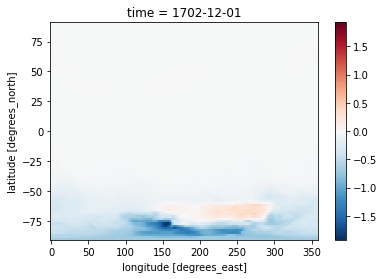

In [18]:
#Seasonal Mean of Field Variable, just an example here to make sure my method below is correct
d18O_shem_seas_mean_raw_ctrl = d18O_raw_shem_tmon_ctrl[2:(len(d18O_raw_shem_tmon_ctrl['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(dim='time')
d18O_shem_seas_mean_raw_ctrl[3].plot()

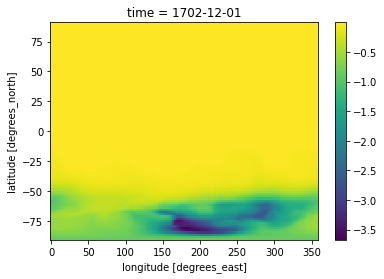

In [19]:
#Seasonal Mean of Field Variable, just an example here to make sure my method below is correct
d18O_V_shem_seas_mean_raw_ctrl = d18O_V_raw_shem_tmon_ctrl[2:(len(d18O_V_raw_shem_tmon_ctrl['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(dim='time')
d18O_V_shem_seas_mean_raw_ctrl[3].plot()

<xarray.DataArray (time: 74, lat: 96, lon: 144)>
array([[[-6.8156308e-01, -6.8156242e-01, -6.8156362e-01, ...,
         -6.8156308e-01, -6.8156272e-01, -6.8156290e-01],
        [-5.7323533e-01, -5.7150912e-01, -5.6807011e-01, ...,
         -5.9559292e-01, -5.8842230e-01, -5.8039981e-01],
        [-5.2307963e-01, -5.2572489e-01, -5.2700019e-01, ...,
         -5.1844519e-01, -5.2017629e-01, -5.2260220e-01],
        ...,
        [-1.2666847e-03, -1.2517417e-03, -1.2047002e-03, ...,
         -1.2730501e-03, -1.2577566e-03, -1.2398000e-03],
        [-2.0592122e-03, -2.0905116e-03, -2.0664090e-03, ...,
         -2.0838662e-03, -2.0606865e-03, -2.0514044e-03],
        [-2.1996119e-03, -2.1996053e-03, -2.1993776e-03, ...,
         -2.1998368e-03, -2.1997411e-03, -2.1996221e-03]],

       [[-1.3797928e+00, -1.3797928e+00, -1.3797935e+00, ...,
         -1.3797952e+00, -1.3797951e+00, -1.3797927e+00],
        [-1.2244786e+00, -1.2234265e+00, -1.2124707e+00, ...,
         -1.2418996e+00, -1.232952

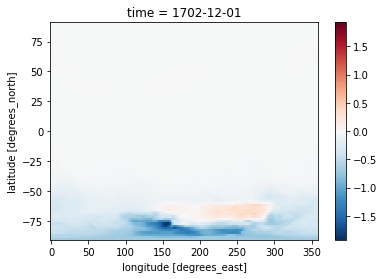

In [20]:
#Seperating out those seasonal means of the field variable
def is_djf(month):
    return (month == 12)

def is_mam(month):
    return (month == 3)

def is_jja(month):
    return (month == 6)

def is_son(month):
    return (month == 9)

djf_d18O_shem_seas_mean_raw_ctrl = d18O_shem_seas_mean_raw_ctrl.sel(time=is_djf(d18O_shem_seas_mean_raw_ctrl['time.month']))
mam_d18O_shem_seas_mean_raw_ctrl = d18O_shem_seas_mean_raw_ctrl.sel(time=is_mam(d18O_shem_seas_mean_raw_ctrl['time.month']))
jja_d18O_shem_seas_mean_raw_ctrl = d18O_shem_seas_mean_raw_ctrl.sel(time=is_jja(d18O_shem_seas_mean_raw_ctrl['time.month']))
son_d18O_shem_seas_mean_raw_ctrl = d18O_shem_seas_mean_raw_ctrl.sel(time=is_son(d18O_shem_seas_mean_raw_ctrl['time.month']))

#note, the first djf is dated for the first year because the 3-month mean is labeled by the first month
djf_d18O_shem_seas_mean_raw_ctrl[0].plot()
print(djf_d18O_shem_seas_mean_raw_ctrl)

#In case I need to add NaNs in djf, something like this may work:
# #need to add back in at time=0 a row of nans for djf, else it has 47 instead of 48 points
# nan_slice_for_djf = djfmean_T2M_tmon_ctrl_data[0:1,:,:]
# nan_slice_for_djf = nan_slice_for_djf.where(nan_slice_for_djf == 99999.)
# djfmean_T2M_tmon_ctrl_data = xr.concat([nan_slice_for_djf, djfmean_T2M_tmon_ctrl_data], dim='time')
# #djfmean_T2M_tmon_ctrl_data

<xarray.DataArray (time: 74, lat: 96, lon: 144)>
array([[[-0.86731513, -0.86731516, -0.8673151 , ..., -0.86731514,
         -0.86731513, -0.86731518],
        [-0.82211012, -0.8204884 , -0.81892363, ..., -0.82689028,
         -0.82529414, -0.82372638],
        [-0.76628916, -0.76340005, -0.76056156, ..., -0.77700998,
         -0.77305502, -0.7694233 ],
        ...,
        [-0.00761929, -0.00763891, -0.00766654, ..., -0.00759876,
         -0.00760052, -0.00760768],
        [-0.008431  , -0.00843797, -0.00844958, ..., -0.00842223,
         -0.00842428, -0.00842597],
        [-0.0088079 , -0.0088079 , -0.0088079 , ..., -0.0088079 ,
         -0.0088079 , -0.0088079 ]],

       [[-1.55939832, -1.55939821, -1.55939819, ..., -1.55939832,
         -1.55939821, -1.5593982 ],
        [-1.54603759, -1.53959927, -1.53366108, ..., -1.5672709 ,
         -1.55985155, -1.55277882],
        [-1.59645146, -1.58373354, -1.57154685, ..., -1.64107591,
         -1.62584144, -1.61039306],
...
        [-0.00

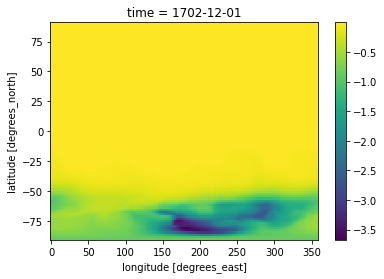

In [21]:
#Seperating out those seasonal means of the field variable
def is_djf(month):
    return (month == 12)

def is_mam(month):
    return (month == 3)

def is_jja(month):
    return (month == 6)

def is_son(month):
    return (month == 9)

djf_d18O_V_shem_seas_mean_raw_ctrl = d18O_V_shem_seas_mean_raw_ctrl.sel(time=is_djf(d18O_V_shem_seas_mean_raw_ctrl['time.month']))
mam_d18O_V_shem_seas_mean_raw_ctrl = d18O_V_shem_seas_mean_raw_ctrl.sel(time=is_mam(d18O_V_shem_seas_mean_raw_ctrl['time.month']))
jja_d18O_V_shem_seas_mean_raw_ctrl = d18O_V_shem_seas_mean_raw_ctrl.sel(time=is_jja(d18O_V_shem_seas_mean_raw_ctrl['time.month']))
son_d18O_V_shem_seas_mean_raw_ctrl = d18O_V_shem_seas_mean_raw_ctrl.sel(time=is_son(d18O_V_shem_seas_mean_raw_ctrl['time.month']))

#note, the first djf is dated for the first year because the 3-month mean is labeled by the first month
djf_d18O_V_shem_seas_mean_raw_ctrl[0].plot()
print(djf_d18O_V_shem_seas_mean_raw_ctrl)

#In case I need to add NaNs in djf, something like this may work:
# #need to add back in at time=0 a row of nans for djf, else it has 47 instead of 48 points
# nan_slice_for_djf = djfmean_T2M_tmon_ctrl_data[0:1,:,:]
# nan_slice_for_djf = nan_slice_for_djf.where(nan_slice_for_djf == 99999.)
# djfmean_T2M_tmon_ctrl_data = xr.concat([nan_slice_for_djf, djfmean_T2M_tmon_ctrl_data], dim='time')
# #djfmean_T2M_tmon_ctrl_data

In [22]:
#Field variable with annual mean

d18O_shem_ann_mean_raw_ctrl = d18O_raw_shem_tmon_ctrl.resample(time='AS').mean(dim='time')
d18O_shem_ann_mean_raw_ctrl

<xarray.DataArray (time: 75, lat: 96, lon: 144)>
array([[[-2.1479971e+00, -2.1479731e+00, -2.1478729e+00, ...,
         -2.1480045e+00, -2.1480031e+00, -2.1479981e+00],
        [-1.7823704e+00, -1.7678241e+00, -1.7587166e+00, ...,
         -1.8251754e+00, -1.8106055e+00, -1.7959504e+00],
        [-1.3417578e+00, -1.3390898e+00, -1.3381573e+00, ...,
         -1.3853604e+00, -1.3656497e+00, -1.3521352e+00],
        ...,
        [-4.8210737e-04, -4.9465057e-04, -4.9815443e-04, ...,
         -4.5280985e-04, -4.5195315e-04, -4.7061662e-04],
        [-5.7444751e-04, -5.5277540e-04, -5.3518103e-04, ...,
         -6.2536611e-04, -6.0772413e-04, -5.8869726e-04],
        [-6.6537672e-04, -6.6538044e-04, -6.6537783e-04, ...,
         -6.6539808e-04, -6.6539273e-04, -6.6538062e-04]],

       [[-1.4568626e+00, -1.4568094e+00, -1.4567037e+00, ...,
         -1.4568757e+00, -1.4568795e+00, -1.4568683e+00],
        [-1.3669308e+00, -1.3652848e+00, -1.3654288e+00, ...,
         -1.3764129e+00, -1.3750745e+00, -1.3716003e+00],
        [-1.3191688e+00, -1.3064491e+00, -1.2981519e+00, ...,
         -1.3383660e+00, -1.3325113e+00, -1.3293816e+00],
...
        [-7.5584045e-04, -7.6448050e-04, -7.6480117e-04, ...,
         -7.1500568e-04, -7.2723971e-04, -7.4318837e-04],
        [-7.7063014e-04, -7.7644101e-04, -7.7911629e-04, ...,
         -7.7036041e-04, -7.7205943e-04, -7.7487825e-04],
        [-7.7959982e-04, -7.7961618e-04, -7.7964080e-04, ...,
         -7.7957875e-04, -7.7958481e-04, -7.7958364e-04]],

       [[-1.7133946e+00, -1.7133933e+00, -1.7134576e+00, ...,
         -1.7134138e+00, -1.7134161e+00, -1.7134136e+00],
        [-1.4641877e+00, -1.4632125e+00, -1.4584264e+00, ...,
         -1.4933079e+00, -1.4797908e+00, -1.4683628e+00],
        [-1.2746238e+00, -1.2635621e+00, -1.2560916e+00, ...,
         -1.3301725e+00, -1.2951250e+00, -1.2816960e+00],
        ...,
        [-6.8826979e-04, -6.9267699e-04, -6.9858803e-04, ...,
         -6.8549655e-04, -6.8972964e-04, -6.8966829e-04],
        [-6.9981464e-04, -7.1131182e-04, -7.0713070e-04, ...,
         -6.9976476e-04, -7.0108473e-04, -6.9607113e-04],
        [-6.5680337e-04, -6.5681251e-04, -6.5682078e-04, ...,
         -6.5679947e-04, -6.5680774e-04, -6.5680995e-04]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1702-01-01 1703-01-01 ... 1776-01-01
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [23]:
#Field variable with annual mean

d18O_V_shem_ann_mean_raw_ctrl = d18O_V_raw_shem_tmon_ctrl.resample(time='AS').mean(dim='time')
d18O_V_shem_ann_mean_raw_ctrl


<xarray.DataArray (time: 75, lat: 96, lon: 144)>
array([[[-2.50795378e+00, -2.50795407e+00, -2.50795484e+00, ...,
         -2.50795369e+00, -2.50795374e+00, -2.50795379e+00],
        [-2.11868742e+00, -2.11348444e+00, -2.10802340e+00, ...,
         -2.13482211e+00, -2.12951060e+00, -2.12383466e+00],
        [-1.83024749e+00, -1.82052889e+00, -1.80948965e+00, ...,
         -1.85838876e+00, -1.84910711e+00, -1.83968279e+00],
        ...,
        [-4.20532154e-03, -4.20539624e-03, -4.20735292e-03, ...,
         -4.22042758e-03, -4.21248062e-03, -4.20817588e-03],
        [-4.38574762e-03, -4.38701986e-03, -4.38879511e-03, ...,
         -4.38338444e-03, -4.38354155e-03, -4.38471767e-03],
        [-4.46542827e-03, -4.46542850e-03, -4.46542896e-03, ...,
         -4.46542923e-03, -4.46542965e-03, -4.46542860e-03]],

       [[-2.11508578e+00, -2.11508628e+00, -2.11508715e+00, ...,
         -2.11508575e+00, -2.11508573e+00, -2.11508586e+00],
        [-1.91939486e+00, -1.91289395e+00, -1.90535157e+00, ...,
         -1.93714050e+00, -1.93146901e+00, -1.92562608e+00],
        [-1.73462195e+00, -1.72285999e+00, -1.71153292e+00, ...,
         -1.77392479e+00, -1.75995517e+00, -1.74683396e+00],
...
        [-2.63731188e-03, -2.64681744e-03, -2.65474922e-03, ...,
         -2.61205604e-03, -2.62085287e-03, -2.62932498e-03],
        [-2.79838007e-03, -2.80093961e-03, -2.80307683e-03, ...,
         -2.78844554e-03, -2.79226456e-03, -2.79562548e-03],
        [-2.82607212e-03, -2.82607204e-03, -2.82607209e-03, ...,
         -2.82607231e-03, -2.82607227e-03, -2.82607235e-03]],

       [[-2.16144360e+00, -2.16144361e+00, -2.16144348e+00, ...,
         -2.16144348e+00, -2.16144348e+00, -2.16144347e+00],
        [-1.90948118e+00, -1.90302942e+00, -1.89745585e+00, ...,
         -1.93210419e+00, -1.92373825e+00, -1.91638080e+00],
        [-1.75585770e+00, -1.74190792e+00, -1.73042493e+00, ...,
         -1.81260150e+00, -1.79151059e+00, -1.77262374e+00],
        ...,
        [-2.05907930e-03, -2.05926632e-03, -2.05937028e-03, ...,
         -2.07255569e-03, -2.06611148e-03, -2.06120483e-03],
        [-2.11906808e-03, -2.11866492e-03, -2.11735769e-03, ...,
         -2.11774374e-03, -2.11783113e-03, -2.11836180e-03],
        [-2.12301980e-03, -2.12301985e-03, -2.12301987e-03, ...,
         -2.12301973e-03, -2.12301978e-03, -2.12301982e-03]]])
Coordinates:
  * time     (time) datetime64[ns] 1702-01-01 1703-01-01 ... 1776-01-01
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

## Find quartiles for SAM for both iCESM 

In [24]:
#Find SAM values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna()),1)}
SAM_djf_mean_ctrl = pd.DataFrame(data=d)
# SAM_djf_mean_ctrl

d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna()),1)}
SAM_mam_mean_ctrl = pd.DataFrame(data=d)
# SAM_mam_mean_ctrl

d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna()),1)}
SAM_jja_mean_ctrl = pd.DataFrame(data=d)
# SAM_jja_mean_ctrl

d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna()),1)}
SAM_son_mean_ctrl = pd.DataFrame(data=d)
# SAM_son_mean_ctrl

d = {'SAM': SAM_PSAs_ann_mean_indices_ctrl.SAM.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_ctrl.SAM.dropna()),1)}
SAM_ann_mean_ctrl = pd.DataFrame(data=d)
# SAM_ann_mean_ctrl


#create list of indices representing the upper/lower quartiles of 'SAM'
#Note, head is lower (sorted from low to high)
SAM_djf_mean_lower_ctrl = SAM_djf_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_djf_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_djf_mean_lower_ctrl
SAM_djf_mean_upper_ctrl = SAM_djf_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_djf_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_djf_mean_upper_ctrl

SAM_mam_mean_lower_ctrl = SAM_mam_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_mam_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_mam_mean_lower_ctrl
SAM_mam_mean_upper_ctrl = SAM_mam_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_mam_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_mam_mean_upper_ctrl

SAM_jja_mean_lower_ctrl = SAM_jja_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_jja_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_jja_mean_lower_ctrl
SAM_jja_mean_upper_ctrl = SAM_jja_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_jja_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_jja_mean_upper_ctrl

SAM_son_mean_lower_ctrl = SAM_son_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_son_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_son_mean_lower_ctrl
SAM_son_mean_upper_ctrl = SAM_son_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_son_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_son_mean_upper_ctrl

SAM_ann_mean_lower_ctrl = SAM_ann_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_ann_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_ann_mean_lower_ctrl
SAM_ann_mean_upper_ctrl = SAM_ann_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_ann_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_ann_mean_upper_ctrl

In [25]:
print(SAM_mam_mean_lower_ctrl)


[61, 31, 56, 2, 57, 20, 30, 40, 45, 59, 32, 16, 51, 1, 73, 35, 66, 14, 17]


## Select the times of the field variable dependent upon quartile and the indice 

In [26]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_d18O_w_upper_SAM_raw_ctrl = djf_d18O_shem_seas_mean_raw_ctrl.isel(time = SAM_djf_mean_upper_ctrl)
djf_d18O_w_lower_SAM_raw_ctrl = djf_d18O_shem_seas_mean_raw_ctrl.isel(time = SAM_djf_mean_lower_ctrl)
# djf_d18O_w_upper_SAM_raw_ctrl
# djf_d18O_w_lower_SAM_raw_ctrl

#mam
mam_d18O_w_upper_SAM_raw_ctrl = mam_d18O_shem_seas_mean_raw_ctrl.isel(time = SAM_mam_mean_upper_ctrl)
mam_d18O_w_lower_SAM_raw_ctrl = mam_d18O_shem_seas_mean_raw_ctrl.isel(time = SAM_mam_mean_lower_ctrl)
# mam_d18O_w_upper_SAM_raw_ctrl
# mam_d18O_w_lower_SAM_raw_ctrl

#jja
jja_d18O_w_upper_SAM_raw_ctrl = jja_d18O_shem_seas_mean_raw_ctrl.isel(time = SAM_jja_mean_upper_ctrl)
jja_d18O_w_lower_SAM_raw_ctrl = jja_d18O_shem_seas_mean_raw_ctrl.isel(time = SAM_jja_mean_lower_ctrl)
# jja_d18O_w_upper_SAM_raw_ctrl
# jja_d18O_w_lower_SAM_raw_ctrl

#son
son_d18O_w_upper_SAM_raw_ctrl = son_d18O_shem_seas_mean_raw_ctrl.isel(time = SAM_son_mean_upper_ctrl)
son_d18O_w_lower_SAM_raw_ctrl = son_d18O_shem_seas_mean_raw_ctrl.isel(time = SAM_son_mean_lower_ctrl)
son_d18O_w_upper_SAM_raw_ctrl
# son_d18O_w_lower_SAM_raw_ctrl

#ann mean
ann_mean_d18O_w_upper_SAM_raw_ctrl = d18O_shem_ann_mean_raw_ctrl.isel(time = SAM_ann_mean_upper_ctrl)
ann_mean_d18O_w_lower_SAM_raw_ctrl = d18O_shem_ann_mean_raw_ctrl.isel(time = SAM_ann_mean_lower_ctrl)
# ann_mean_d18O_w_upper_SAM_raw_ctrl
# ann_mean_d18O_w_lower_SAM_raw_ctrl


In [27]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_d18O_V_w_upper_SAM_raw_ctrl = djf_d18O_V_shem_seas_mean_raw_ctrl.isel(time = SAM_djf_mean_upper_ctrl)
djf_d18O_V_w_lower_SAM_raw_ctrl = djf_d18O_V_shem_seas_mean_raw_ctrl.isel(time = SAM_djf_mean_lower_ctrl)
# djf_d18O_V_w_upper_SAM_raw_ctrl
# djf_d18O_V_w_lower_SAM_raw_ctrl

#mam
mam_d18O_V_w_upper_SAM_raw_ctrl = mam_d18O_V_shem_seas_mean_raw_ctrl.isel(time = SAM_mam_mean_upper_ctrl)
mam_d18O_V_w_lower_SAM_raw_ctrl = mam_d18O_V_shem_seas_mean_raw_ctrl.isel(time = SAM_mam_mean_lower_ctrl)
# mam_d18O_V_w_upper_SAM_raw_ctrl
# mam_d18O_V_w_lower_SAM_raw_ctrl

#jja
jja_d18O_V_w_upper_SAM_raw_ctrl = jja_d18O_V_shem_seas_mean_raw_ctrl.isel(time = SAM_jja_mean_upper_ctrl)
jja_d18O_V_w_lower_SAM_raw_ctrl = jja_d18O_V_shem_seas_mean_raw_ctrl.isel(time = SAM_jja_mean_lower_ctrl)
# jja_d18O_V_w_upper_SAM_raw_ctrl
# jja_d18O_V_w_lower_SAM_raw_ctrl

#son
son_d18O_V_w_upper_SAM_raw_ctrl = son_d18O_V_shem_seas_mean_raw_ctrl.isel(time = SAM_son_mean_upper_ctrl)
son_d18O_V_w_lower_SAM_raw_ctrl = son_d18O_V_shem_seas_mean_raw_ctrl.isel(time = SAM_son_mean_lower_ctrl)
son_d18O_V_w_upper_SAM_raw_ctrl
# son_d18O_V_w_lower_SAM_raw_ctrl

#ann mean
ann_mean_d18O_V_w_upper_SAM_raw_ctrl = d18O_V_shem_ann_mean_raw_ctrl.isel(time = SAM_ann_mean_upper_ctrl)
ann_mean_d18O_V_w_lower_SAM_raw_ctrl = d18O_V_shem_ann_mean_raw_ctrl.isel(time = SAM_ann_mean_lower_ctrl)
# ann_mean_d18O_V_w_upper_SAM_raw_ctrl
# ann_mean_d18O_V_w_lower_SAM_raw_ctrl


In [28]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[SAM_djf_mean_upper_ctrl]
# djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl
djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[SAM_djf_mean_lower_ctrl]
# djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl

#mam
mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[SAM_mam_mean_upper_ctrl]
# mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl
mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[SAM_mam_mean_lower_ctrl]
# mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl

#jja
jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[SAM_jja_mean_upper_ctrl]
# jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl
jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[SAM_jja_mean_lower_ctrl]
# jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl

#son
son_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[SAM_son_mean_upper_ctrl]
# son_Rel_CP_indices_w_upper_SAM_detrend_ctrl
son_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[SAM_son_mean_lower_ctrl]
# son_Rel_CP_indices_w_lower_SAM_detrend_ctrl

#annual mean
ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[SAM_ann_mean_upper_ctrl]
# ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl
ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[SAM_ann_mean_lower_ctrl]
# ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl



In [29]:
# #Calculate significance for the change in mean of the field variable for Positive-Negative
# #critical value for t-test at 95%:
# #Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
# #DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

# djf_d18O_change_due_to_SAM_ttest_stats_ctrl, djf_d18O_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
#     djf_d18O_w_upper_SAM_raw_ctrl, djf_d18O_w_lower_SAM_raw_ctrl, axis=0)

# mam_d18O_change_due_to_SAM_ttest_stats_ctrl, mam_d18O_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
#     mam_d18O_w_upper_SAM_raw_ctrl, mam_d18O_w_lower_SAM_raw_ctrl, axis=0)

# jja_d18O_change_due_to_SAM_ttest_stats_ctrl, jja_d18O_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
#     jja_d18O_w_upper_SAM_raw_ctrl, jja_d18O_w_lower_SAM_raw_ctrl, axis=0)

# son_d18O_change_due_to_SAM_ttest_stats_ctrl, son_d18O_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
#     son_d18O_w_upper_SAM_raw_ctrl, son_d18O_w_lower_SAM_raw_ctrl, axis=0)

# ann_mean_d18O_change_due_to_SAM_ttest_stats_ctrl, ann_mean_d18O_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
#     ann_mean_d18O_w_upper_SAM_raw_ctrl, ann_mean_d18O_w_lower_SAM_raw_ctrl, axis=0)

In [30]:
# #Calculate significance for the change in mean of the field variable for Positive-Negative
# #critical value for t-test at 95%:
# #Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
# #DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

# djf_d18O_V_change_due_to_SAM_ttest_stats_ctrl, djf_d18O_V_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
#     djf_d18O_V_w_upper_SAM_raw_ctrl, djf_d18O_V_w_lower_SAM_raw_ctrl, axis=0)

# mam_d18O_V_change_due_to_SAM_ttest_stats_ctrl, mam_d18O_V_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
#     mam_d18O_V_w_upper_SAM_raw_ctrl, mam_d18O_V_w_lower_SAM_raw_ctrl, axis=0)

# jja_d18O_V_change_due_to_SAM_ttest_stats_ctrl, jja_d18O_V_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
#     jja_d18O_V_w_upper_SAM_raw_ctrl, jja_d18O_V_w_lower_SAM_raw_ctrl, axis=0)

# son_d18O_V_change_due_to_SAM_ttest_stats_ctrl, son_d18O_V_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
#     son_d18O_V_w_upper_SAM_raw_ctrl, son_d18O_V_w_lower_SAM_raw_ctrl, axis=0)

# ann_mean_d18O_V_change_due_to_SAM_ttest_stats_ctrl, ann_mean_d18O_V_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
#     ann_mean_d18O_V_w_upper_SAM_raw_ctrl, ann_mean_d18O_V_w_lower_SAM_raw_ctrl, axis=0)

In [31]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_slp_w_upper_SAM_detrended_ctrl = djf_SLP_detrended_ctrl.isel(time = SAM_djf_mean_upper_ctrl)
djf_slp_w_lower_SAM_detrended_ctrl = djf_SLP_detrended_ctrl.isel(time = SAM_djf_mean_lower_ctrl)
# djf_slp_w_upper_SAM_detrended_ctrl
# djf_slp_w_lower_SAM_detrended_ctrl

#mam
mam_slp_w_upper_SAM_detrended_ctrl = mam_SLP_detrended_ctrl.isel(time = SAM_mam_mean_upper_ctrl)
mam_slp_w_lower_SAM_detrended_ctrl = mam_SLP_detrended_ctrl.isel(time = SAM_mam_mean_lower_ctrl)
# mam_slp_w_upper_SAM_detrended_ctrl
# mam_slp_w_lower_SAM_detrended_ctrl

#jja
jja_slp_w_upper_SAM_detrended_ctrl = jja_SLP_detrended_ctrl.isel(time = SAM_jja_mean_upper_ctrl)
jja_slp_w_lower_SAM_detrended_ctrl = jja_SLP_detrended_ctrl.isel(time = SAM_jja_mean_lower_ctrl)
# jja_slp_w_upper_SAM_detrended_ctrl
# jja_slp_w_lower_SAM_detrended_ctrl

#son
son_slp_w_upper_SAM_detrended_ctrl = son_SLP_detrended_ctrl.isel(time = SAM_son_mean_upper_ctrl)
son_slp_w_lower_SAM_detrended_ctrl = son_SLP_detrended_ctrl.isel(time = SAM_son_mean_lower_ctrl)
son_slp_w_upper_SAM_detrended_ctrl
# son_slp_w_lower_SAM_detrended_ctrl

#ann mean
ann_mean_slp_w_upper_SAM_detrended_ctrl = ann_mean_SLP_detrended_ctrl.isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_slp_w_lower_SAM_detrended_ctrl = ann_mean_SLP_detrended_ctrl.isel(year = SAM_ann_mean_lower_ctrl)
# ann_mean_slp_w_upper_SAM_detrended_ctrl
# ann_mean_slp_w_lower_SAM_detrended_ctrl


In [32]:
# #Calculate significance for the change in mean of the field variable for Positive-Negative
# #critical value for t-test at 95%:
# #Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
# #DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

# djf_slp_change_due_to_SAM_ttest_stats_ctrl, djf_slp_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
#     djf_slp_w_upper_SAM_raw_ctrl, djf_slp_w_lower_SAM_raw_ctrl, axis=0)

# mam_slp_change_due_to_SAM_ttest_stats_ctrl, mam_slp_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
#     mam_slp_w_upper_SAM_raw_ctrl, mam_slp_w_lower_SAM_raw_ctrl, axis=0)

# jja_slp_change_due_to_SAM_ttest_stats_ctrl, jja_slp_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
#     jja_slp_w_upper_SAM_raw_ctrl, jja_slp_w_lower_SAM_raw_ctrl, axis=0)

# son_slp_change_due_to_SAM_ttest_stats_ctrl, son_slp_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
#     son_slp_w_upper_SAM_raw_ctrl, son_slp_w_lower_SAM_raw_ctrl, axis=0)

# ann_mean_slp_change_due_to_SAM_ttest_stats_ctrl, ann_mean_slp_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
#     ann_mean_slp_w_upper_SAM_raw_ctrl, ann_mean_slp_w_lower_SAM_raw_ctrl, axis=0)

In [33]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_u10_w_upper_SAM_detrended_ctrl = djf_U10_detrended_ctrl.isel(time = SAM_djf_mean_upper_ctrl)
djf_u10_w_lower_SAM_detrended_ctrl = djf_U10_detrended_ctrl.isel(time = SAM_djf_mean_lower_ctrl)
# djf_u10_w_upper_SAM_detrended_ctrl
# djf_u10_w_lower_SAM_detrended_ctrl

#mam
mam_u10_w_upper_SAM_detrended_ctrl = mam_U10_detrended_ctrl.isel(time = SAM_mam_mean_upper_ctrl)
mam_u10_w_lower_SAM_detrended_ctrl = mam_U10_detrended_ctrl.isel(time = SAM_mam_mean_lower_ctrl)
# mam_u10_w_upper_SAM_detrended_ctrl
# mam_u10_w_lower_SAM_detrended_ctrl

#jja
jja_u10_w_upper_SAM_detrended_ctrl = jja_U10_detrended_ctrl.isel(time = SAM_jja_mean_upper_ctrl)
jja_u10_w_lower_SAM_detrended_ctrl = jja_U10_detrended_ctrl.isel(time = SAM_jja_mean_lower_ctrl)
# jja_u10_w_upper_SAM_detrended_ctrl
# jja_u10_w_lower_SAM_detrended_ctrl

#son
son_u10_w_upper_SAM_detrended_ctrl = son_U10_detrended_ctrl.isel(time = SAM_son_mean_upper_ctrl)
son_u10_w_lower_SAM_detrended_ctrl = son_U10_detrended_ctrl.isel(time = SAM_son_mean_lower_ctrl)
son_u10_w_upper_SAM_detrended_ctrl
# son_u10_w_lower_SAM_detrended_ctrl

#ann mean
ann_mean_u10_w_upper_SAM_detrended_ctrl = ann_mean_U10_detrended_ctrl.isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_u10_w_lower_SAM_detrended_ctrl = ann_mean_U10_detrended_ctrl.isel(year = SAM_ann_mean_lower_ctrl)
# ann_mean_u10_w_upper_SAM_detrended_ctrl
# ann_mean_u10_w_lower_SAM_detrended_ctrl


In [34]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_v10_w_upper_SAM_detrended_ctrl = djf_V10_detrended_ctrl.isel(time = SAM_djf_mean_upper_ctrl)
djf_v10_w_lower_SAM_detrended_ctrl = djf_V10_detrended_ctrl.isel(time = SAM_djf_mean_lower_ctrl)
# djf_v10_w_upper_SAM_detrended_ctrl
# djf_v10_w_lower_SAM_detrended_ctrl

#mam
mam_v10_w_upper_SAM_detrended_ctrl = mam_V10_detrended_ctrl.isel(time = SAM_mam_mean_upper_ctrl)
mam_v10_w_lower_SAM_detrended_ctrl = mam_V10_detrended_ctrl.isel(time = SAM_mam_mean_lower_ctrl)
# mam_v10_w_upper_SAM_detrended_ctrl
# mam_v10_w_lower_SAM_detrended_ctrl

#jja
jja_v10_w_upper_SAM_detrended_ctrl = jja_V10_detrended_ctrl.isel(time = SAM_jja_mean_upper_ctrl)
jja_v10_w_lower_SAM_detrended_ctrl = jja_V10_detrended_ctrl.isel(time = SAM_jja_mean_lower_ctrl)
# jja_v10_w_upper_SAM_detrended_ctrl
# jja_v10_w_lower_SAM_detrended_ctrl

#son
son_v10_w_upper_SAM_detrended_ctrl = son_V10_detrended_ctrl.isel(time = SAM_son_mean_upper_ctrl)
son_v10_w_lower_SAM_detrended_ctrl = son_V10_detrended_ctrl.isel(time = SAM_son_mean_lower_ctrl)
son_v10_w_upper_SAM_detrended_ctrl
# son_v10_w_lower_SAM_detrended_ctrl

#ann mean
ann_mean_v10_w_upper_SAM_detrended_ctrl = ann_mean_V10_detrended_ctrl.isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_v10_w_lower_SAM_detrended_ctrl = ann_mean_V10_detrended_ctrl.isel(year = SAM_ann_mean_lower_ctrl)
# ann_mean_v10_w_upper_SAM_detrended_ctrl
# ann_mean_v10_w_lower_SAM_detrended_ctrl


In [35]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_tpw_w_upper_SAM_detrended_ctrl = djf_TPW_detrended_ctrl.isel(time = SAM_djf_mean_upper_ctrl)
djf_tpw_w_lower_SAM_detrended_ctrl = djf_TPW_detrended_ctrl.isel(time = SAM_djf_mean_lower_ctrl)
# djf_tpw_w_upper_SAM_detrended_ctrl
# djf_tpw_w_lower_SAM_detrended_ctrl

#mam
mam_tpw_w_upper_SAM_detrended_ctrl = mam_TPW_detrended_ctrl.isel(time = SAM_mam_mean_upper_ctrl)
mam_tpw_w_lower_SAM_detrended_ctrl = mam_TPW_detrended_ctrl.isel(time = SAM_mam_mean_lower_ctrl)
# mam_tpw_w_upper_SAM_detrended_ctrl
# mam_tpw_w_lower_SAM_detrended_ctrl

#jja
jja_tpw_w_upper_SAM_detrended_ctrl = jja_TPW_detrended_ctrl.isel(time = SAM_jja_mean_upper_ctrl)
jja_tpw_w_lower_SAM_detrended_ctrl = jja_TPW_detrended_ctrl.isel(time = SAM_jja_mean_lower_ctrl)
# jja_tpw_w_upper_SAM_detrended_ctrl
# jja_tpw_w_lower_SAM_detrended_ctrl

#son
son_tpw_w_upper_SAM_detrended_ctrl = son_TPW_detrended_ctrl.isel(time = SAM_son_mean_upper_ctrl)
son_tpw_w_lower_SAM_detrended_ctrl = son_TPW_detrended_ctrl.isel(time = SAM_son_mean_lower_ctrl)
son_tpw_w_upper_SAM_detrended_ctrl
# son_tpw_w_lower_SAM_detrended_ctrl

#ann mean
ann_mean_tpw_w_upper_SAM_detrended_ctrl = ann_mean_TPW_detrended_ctrl.isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_tpw_w_lower_SAM_detrended_ctrl = ann_mean_TPW_detrended_ctrl.isel(year = SAM_ann_mean_lower_ctrl)
# ann_mean_tpw_w_upper_SAM_detrended_ctrl
# ann_mean_tpw_w_lower_SAM_detrended_ctrl


In [36]:
#iCESM IVT for Upper and Lower SAM
#H2OV Zonal
djf_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl = djf_IVT_H2OV_Zonal_detrended_ctrl.isel(time = SAM_djf_mean_upper_ctrl)
djf_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl = djf_IVT_H2OV_Zonal_detrended_ctrl.isel(time = SAM_djf_mean_lower_ctrl)
mam_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl = mam_IVT_H2OV_Zonal_detrended_ctrl.isel(time = SAM_mam_mean_upper_ctrl)
mam_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl = mam_IVT_H2OV_Zonal_detrended_ctrl.isel(time = SAM_mam_mean_lower_ctrl)
jja_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl = jja_IVT_H2OV_Zonal_detrended_ctrl.isel(time = SAM_jja_mean_upper_ctrl)
jja_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl = jja_IVT_H2OV_Zonal_detrended_ctrl.isel(time = SAM_jja_mean_lower_ctrl)
son_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl = son_IVT_H2OV_Zonal_detrended_ctrl.isel(time = SAM_son_mean_upper_ctrl)
son_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl = son_IVT_H2OV_Zonal_detrended_ctrl.isel(time = SAM_son_mean_lower_ctrl)
ann_mean_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl = ann_mean_IVT_H2OV_Zonal_detrended_ctrl.isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl = ann_mean_IVT_H2OV_Zonal_detrended_ctrl.isel(year = SAM_ann_mean_lower_ctrl)

#H2OV Meridional
djf_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl = djf_IVT_H2OV_Meridional_detrended_ctrl.isel(time = SAM_djf_mean_upper_ctrl)
djf_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl = djf_IVT_H2OV_Meridional_detrended_ctrl.isel(time = SAM_djf_mean_lower_ctrl)
mam_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl = mam_IVT_H2OV_Meridional_detrended_ctrl.isel(time = SAM_mam_mean_upper_ctrl)
mam_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl = mam_IVT_H2OV_Meridional_detrended_ctrl.isel(time = SAM_mam_mean_lower_ctrl)
jja_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl = jja_IVT_H2OV_Meridional_detrended_ctrl.isel(time = SAM_jja_mean_upper_ctrl)
jja_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl = jja_IVT_H2OV_Meridional_detrended_ctrl.isel(time = SAM_jja_mean_lower_ctrl)
son_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl = son_IVT_H2OV_Meridional_detrended_ctrl.isel(time = SAM_son_mean_upper_ctrl)
son_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl = son_IVT_H2OV_Meridional_detrended_ctrl.isel(time = SAM_son_mean_lower_ctrl)
ann_mean_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl = ann_mean_IVT_H2OV_Meridional_detrended_ctrl.isel(year = SAM_ann_mean_upper_ctrl)
ann_mean_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl = ann_mean_IVT_H2OV_Meridional_detrended_ctrl.isel(year = SAM_ann_mean_lower_ctrl)

# #H218OV Zonal
# djf_IVT_H218OV_Zonal_detrended_w_upper_SAM_ctrl = djf_IVT_H218OV_Zonal_detrended_ctrl.isel(time = SAM_djf_mean_upper_ctrl)
# djf_IVT_H218OV_Zonal_detrended_w_lower_SAM_ctrl = djf_IVT_H218OV_Zonal_detrended_ctrl.isel(time = SAM_djf_mean_lower_ctrl)
# mam_IVT_H218OV_Zonal_detrended_w_upper_SAM_ctrl = mam_IVT_H218OV_Zonal_detrended_ctrl.isel(time = SAM_mam_mean_upper_ctrl)
# mam_IVT_H218OV_Zonal_detrended_w_lower_SAM_ctrl = mam_IVT_H218OV_Zonal_detrended_ctrl.isel(time = SAM_mam_mean_lower_ctrl)
# jja_IVT_H218OV_Zonal_detrended_w_upper_SAM_ctrl = jja_IVT_H218OV_Zonal_detrended_ctrl.isel(time = SAM_jja_mean_upper_ctrl)
# jja_IVT_H218OV_Zonal_detrended_w_lower_SAM_ctrl = jja_IVT_H218OV_Zonal_detrended_ctrl.isel(time = SAM_jja_mean_lower_ctrl)
# son_IVT_H218OV_Zonal_detrended_w_upper_SAM_ctrl = son_IVT_H218OV_Zonal_detrended_ctrl.isel(time = SAM_son_mean_upper_ctrl)
# son_IVT_H218OV_Zonal_detrended_w_lower_SAM_ctrl = son_IVT_H218OV_Zonal_detrended_ctrl.isel(time = SAM_son_mean_lower_ctrl)
# ann_mean_IVT_H218OV_Zonal_detrended_w_upper_SAM_ctrl = ann_mean_IVT_H218OV_Zonal_detrended_ctrl.isel(year = SAM_ann_mean_upper_ctrl)
# ann_mean_IVT_H218OV_Zonal_detrended_w_lower_SAM_ctrl = ann_mean_IVT_H218OV_Zonal_detrended_ctrl.isel(year = SAM_ann_mean_lower_ctrl)

# #H218OV Meridional
# djf_IVT_H218OV_Meridional_detrended_w_upper_SAM_ctrl = djf_IVT_H218OV_Meridional_detrended_ctrl.isel(time = SAM_djf_mean_upper_ctrl)
# djf_IVT_H218OV_Meridional_detrended_w_lower_SAM_ctrl = djf_IVT_H218OV_Meridional_detrended_ctrl.isel(time = SAM_djf_mean_lower_ctrl)
# mam_IVT_H218OV_Meridional_detrended_w_upper_SAM_ctrl = mam_IVT_H218OV_Meridional_detrended_ctrl.isel(time = SAM_mam_mean_upper_ctrl)
# mam_IVT_H218OV_Meridional_detrended_w_lower_SAM_ctrl = mam_IVT_H218OV_Meridional_detrended_ctrl.isel(time = SAM_mam_mean_lower_ctrl)
# jja_IVT_H218OV_Meridional_detrended_w_upper_SAM_ctrl = jja_IVT_H218OV_Meridional_detrended_ctrl.isel(time = SAM_jja_mean_upper_ctrl)
# jja_IVT_H218OV_Meridional_detrended_w_lower_SAM_ctrl = jja_IVT_H218OV_Meridional_detrended_ctrl.isel(time = SAM_jja_mean_lower_ctrl)
# son_IVT_H218OV_Meridional_detrended_w_upper_SAM_ctrl = son_IVT_H218OV_Meridional_detrended_ctrl.isel(time = SAM_son_mean_upper_ctrl)
# son_IVT_H218OV_Meridional_detrended_w_lower_SAM_ctrl = son_IVT_H218OV_Meridional_detrended_ctrl.isel(time = SAM_son_mean_lower_ctrl)
# ann_mean_IVT_H218OV_Meridional_detrended_w_upper_SAM_ctrl = ann_mean_IVT_H218OV_Meridional_detrended_ctrl.isel(year = SAM_ann_mean_upper_ctrl)
# ann_mean_IVT_H218OV_Meridional_detrended_w_lower_SAM_ctrl = ann_mean_IVT_H218OV_Meridional_detrended_ctrl.isel(year = SAM_ann_mean_lower_ctrl)

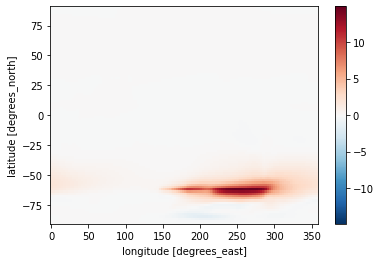

In [37]:
jja_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl.mean(axis=0).plot()

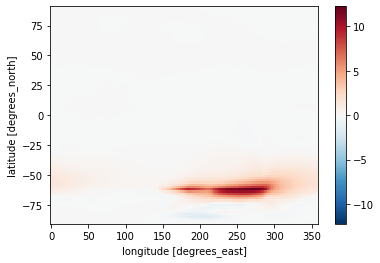

In [38]:
jja_IVT_H2OV_Zonal_detrended_ctrl.mean(axis=0).plot()

# Making IVT Figures for iCESM 

## Will list IVT (kg m^-1 s^-1) at WDC for each figure panel
## ...
## ...

# iCESM CTRL wrt SAM for JJA
# This figure is to be SAVED
## In addition to the Upper minus Lower Difference, there is also a Percent Change Figure and the value at the WDC is listed

## CTRL JJA

## For IVT

In [39]:
# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_IVT_at_wdc = np.sqrt(jja_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2 + jja_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2)
lower_IVT_at_wdc = np.sqrt(jja_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2 + jja_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2)

print(upper_IVT_at_wdc.shape)
print(lower_IVT_at_wdc.shape)
print(upper_IVT_at_wdc.mean())
print(lower_IVT_at_wdc.mean())
print(upper_IVT_at_wdc.var())
print(lower_IVT_at_wdc.var())

ttest_ind(upper_IVT_at_wdc, lower_IVT_at_wdc, equal_var = False)

(19,)
(19,)
<xarray.DataArray ()>
array(0.7539682)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.50931658)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.13345048)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.04960814)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5


Ttest_indResult(statistic=2.42599138531025, pvalue=0.02154423108783351)

In [40]:
# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_tpw_at_wdc = jja_tpw_w_upper_SAM_detrended_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_tpw_at_wdc = jja_tpw_w_lower_SAM_detrended_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
print(upper_tpw_at_wdc.shape)
print(lower_tpw_at_wdc.shape)
print(upper_tpw_at_wdc.mean())
print(lower_tpw_at_wdc.mean())
print(upper_tpw_at_wdc.var())
print(lower_tpw_at_wdc.var())

ttest_ind(upper_tpw_at_wdc, lower_tpw_at_wdc, equal_var = False)

(19,)
(19,)
<xarray.DataArray ()>
array(0.13348832)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.10889246)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.00088466)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.00069469)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5


Ttest_indResult(statistic=2.625782307453782, pvalue=0.012674997053465203)

In [41]:
# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_d18Op_at_wdc = jja_d18O_w_upper_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_d18Op_at_wdc = jja_d18O_w_lower_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')

print(upper_d18Op_at_wdc.shape)
print(lower_d18Op_at_wdc.shape)
print(upper_d18Op_at_wdc.mean())
print(lower_d18Op_at_wdc.mean())
print(upper_d18Op_at_wdc.var())
print(lower_d18Op_at_wdc.var())

ttest_ind(upper_d18Op_at_wdc, lower_d18Op_at_wdc, equal_var = False)

(19,)
(19,)
<xarray.DataArray ()>
array(-2.374055, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(-1.4088744, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.28384882)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.16211736)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5


Ttest_indResult(statistic=-6.131882686002876, pvalue=6.161558858349719e-07)

In [42]:
# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_d18Owv_at_wdc = jja_d18O_V_w_upper_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_d18Owv_at_wdc = jja_d18O_V_w_lower_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')

print(upper_d18Owv_at_wdc.shape)
print(lower_d18Owv_at_wdc.shape)
print(upper_d18Owv_at_wdc.mean())
print(lower_d18Owv_at_wdc.mean())
print(upper_d18Owv_at_wdc.var())
print(lower_d18Owv_at_wdc.var())

ttest_ind(upper_d18Owv_at_wdc, lower_d18Owv_at_wdc, equal_var = False)

(19,)
(19,)
<xarray.DataArray ()>
array(-4.93638683)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(-3.02577974)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.51731629)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.24649821)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5


Ttest_indResult(statistic=-9.274995111981493, pvalue=1.3913299243608014e-10)

In [43]:
#Prepping data for plotting and differencing of iCESM and MERRA--which are on different grids
#need to add cyclic as well

#iCESM CTRL data
#just need to add cyclic and keep original for vectors
# MAGNITUDE TIME MEAN IS WITHHELD UNTIL PLOTTING, THIS ENSURES CONSISTENCY IN RESULTS BTW THE SIG STATS AND THE PLOT
mag_mean_Pac_60to80S_w_upper_SAM_ctrl = np.sqrt(jja_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl**2 + jja_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl**2)
mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl, lons = add_cyclic_point(mag_mean_Pac_60to80S_w_upper_SAM_ctrl.values, mag_mean_Pac_60to80S_w_upper_SAM_ctrl.coords['lon'].values, axis=-1)
lon_orig_w_upper_SAM_ctrl, lat_orig_w_upper_SAM_ctrl = np.meshgrid(mag_mean_Pac_60to80S_w_upper_SAM_ctrl.coords['lon'].values,mag_mean_Pac_60to80S_w_upper_SAM_ctrl.coords['lat'].values)
lon_cyclic_w_upper_SAM_ctrl, lat_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons,mag_mean_Pac_60to80S_w_upper_SAM_ctrl.coords['lat'].values)
jja_tpw_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_tpw_w_upper_SAM_detrended_ctrl.mean(axis=0).values, jja_tpw_w_upper_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_tpw_cyclic_w_upper_SAM_ctrl, lat_tpw_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, jja_tpw_w_upper_SAM_detrended_ctrl.coords['lat'].values)
#slp and wind are on atmo grid, <- took care of this during plotting
jja_slp_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_slp_w_upper_SAM_detrended_ctrl.mean(axis=0).values, jja_slp_w_upper_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_upper_SAM_ctrl, lat_slp_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, jja_slp_w_upper_SAM_detrended_ctrl.coords['lat'].values)
jja_u10_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_u10_w_upper_SAM_detrended_ctrl.mean(axis=0).values, jja_u10_w_upper_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_upper_SAM_ctrl, lat_u10_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, jja_u10_w_upper_SAM_detrended_ctrl.coords['lat'].values)
jja_v10_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_v10_w_upper_SAM_detrended_ctrl.mean(axis=0).values, jja_v10_w_upper_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_upper_SAM_ctrl, lat_v10_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, jja_v10_w_upper_SAM_detrended_ctrl.coords['lat'].values)
jja_d18O_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_d18O_w_upper_SAM_raw_ctrl.mean(axis=0).values, jja_d18O_w_upper_SAM_raw_ctrl.coords['lon'].values, axis=-1)
lon_d18O_cyclic_w_upper_SAM_ctrl, lat_d18O_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, jja_d18O_w_upper_SAM_raw_ctrl.coords['lat'].values)
jja_d18O_V_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_d18O_V_w_upper_SAM_raw_ctrl.mean(axis=0).values, jja_d18O_V_w_upper_SAM_raw_ctrl.coords['lon'].values, axis=-1)
lon_d18O_V_cyclic_w_upper_SAM_ctrl, lat_d18O_V_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, jja_d18O_V_w_upper_SAM_raw_ctrl.coords['lat'].values)

mag_mean_Pac_60to80S_w_lower_SAM_ctrl = np.sqrt(jja_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl**2 + jja_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl**2)
mag_mean_Pac_60to80S_cyclic_w_lower_SAM_ctrl, lons = add_cyclic_point(mag_mean_Pac_60to80S_w_lower_SAM_ctrl.values, mag_mean_Pac_60to80S_w_lower_SAM_ctrl.coords['lon'].values, axis=-1)
lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl = np.meshgrid(mag_mean_Pac_60to80S_w_lower_SAM_ctrl.coords['lon'].values,mag_mean_Pac_60to80S_w_lower_SAM_ctrl.coords['lat'].values)
lon_cyclic_w_lower_SAM_ctrl, lat_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons,mag_mean_Pac_60to80S_w_lower_SAM_ctrl.coords['lat'].values)
jja_tpw_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_tpw_w_lower_SAM_detrended_ctrl.mean(axis=0).values, jja_tpw_w_lower_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_tpw_cyclic_w_lower_SAM_ctrl, lat_tpw_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, jja_tpw_w_lower_SAM_detrended_ctrl.coords['lat'].values)
jja_slp_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_slp_w_lower_SAM_detrended_ctrl.mean(axis=0).values, jja_slp_w_lower_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_lower_SAM_ctrl, lat_slp_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, jja_slp_w_lower_SAM_detrended_ctrl.coords['lat'].values)
jja_u10_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_u10_w_lower_SAM_detrended_ctrl.mean(axis=0).values, jja_u10_w_lower_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_lower_SAM_ctrl, lat_u10_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, jja_u10_w_lower_SAM_detrended_ctrl.coords['lat'].values)
jja_v10_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_v10_w_lower_SAM_detrended_ctrl.mean(axis=0).values, jja_v10_w_lower_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_lower_SAM_ctrl, lat_v10_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, jja_v10_w_lower_SAM_detrended_ctrl.coords['lat'].values)
jja_d18O_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).values, jja_d18O_w_lower_SAM_raw_ctrl.coords['lon'].values, axis=-1)
lon_d18O_cyclic_w_lower_SAM_ctrl, lat_d18O_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, jja_d18O_w_lower_SAM_raw_ctrl.coords['lat'].values)
jja_d18O_V_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(jja_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).values, jja_d18O_V_w_lower_SAM_raw_ctrl.coords['lon'].values, axis=-1)
lon_d18O_V_cyclic_w_lower_SAM_ctrl, lat_d18O_V_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, jja_d18O_V_w_lower_SAM_raw_ctrl.coords['lat'].values)



#gather variable for contour of significant change of d18O
jja_d18O_change_due_to_SAM_ttest_stats_ctrl, jja_d18O_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    jja_d18O_w_upper_SAM_raw_ctrl, jja_d18O_w_lower_SAM_raw_ctrl, axis=0)

diff_jja_d18O_sig_contour_ctrl, lons = add_cyclic_point(jja_d18O_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

#gather variable for contour of significant change of d18O Water Vapor
jja_d18O_V_change_due_to_SAM_ttest_stats_ctrl, jja_d18O_V_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    jja_d18O_V_w_upper_SAM_raw_ctrl, jja_d18O_V_w_lower_SAM_raw_ctrl, axis=0)

diff_jja_d18O_V_sig_contour_ctrl, lons = add_cyclic_point(jja_d18O_V_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

#gather variable for contour of significant change of tpw
jja_tpw_change_due_to_SAM_ttest_stats_ctrl, jja_tpw_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    jja_tpw_w_upper_SAM_detrended_ctrl, jja_tpw_w_lower_SAM_detrended_ctrl, axis=0)

diff_jja_tpw_sig_contour_ctrl, lons = add_cyclic_point(jja_tpw_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

#gather variable for contour of significant change of ivt
jja_ivt_change_due_to_SAM_ttest_stats_ctrl, jja_ivt_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    mag_mean_Pac_60to80S_w_upper_SAM_ctrl, mag_mean_Pac_60to80S_w_lower_SAM_ctrl, axis=0)

diff_jja_ivt_sig_contour_ctrl, lons = add_cyclic_point(jja_ivt_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(96, 145)
(96, 145)
(19, 96, 145)


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<xarray.DataArray ()>
array(0.7539682)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0.50931658)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0.24465162)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
32.44853336902697
(19,)
(19,)
<xarray.DataArray ()>
array(0.7539682)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.50931658)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.13345048)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.04960814)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
Ttest_indResult(statistic=2.42599138531025, pvalue=0.02154423108783351)


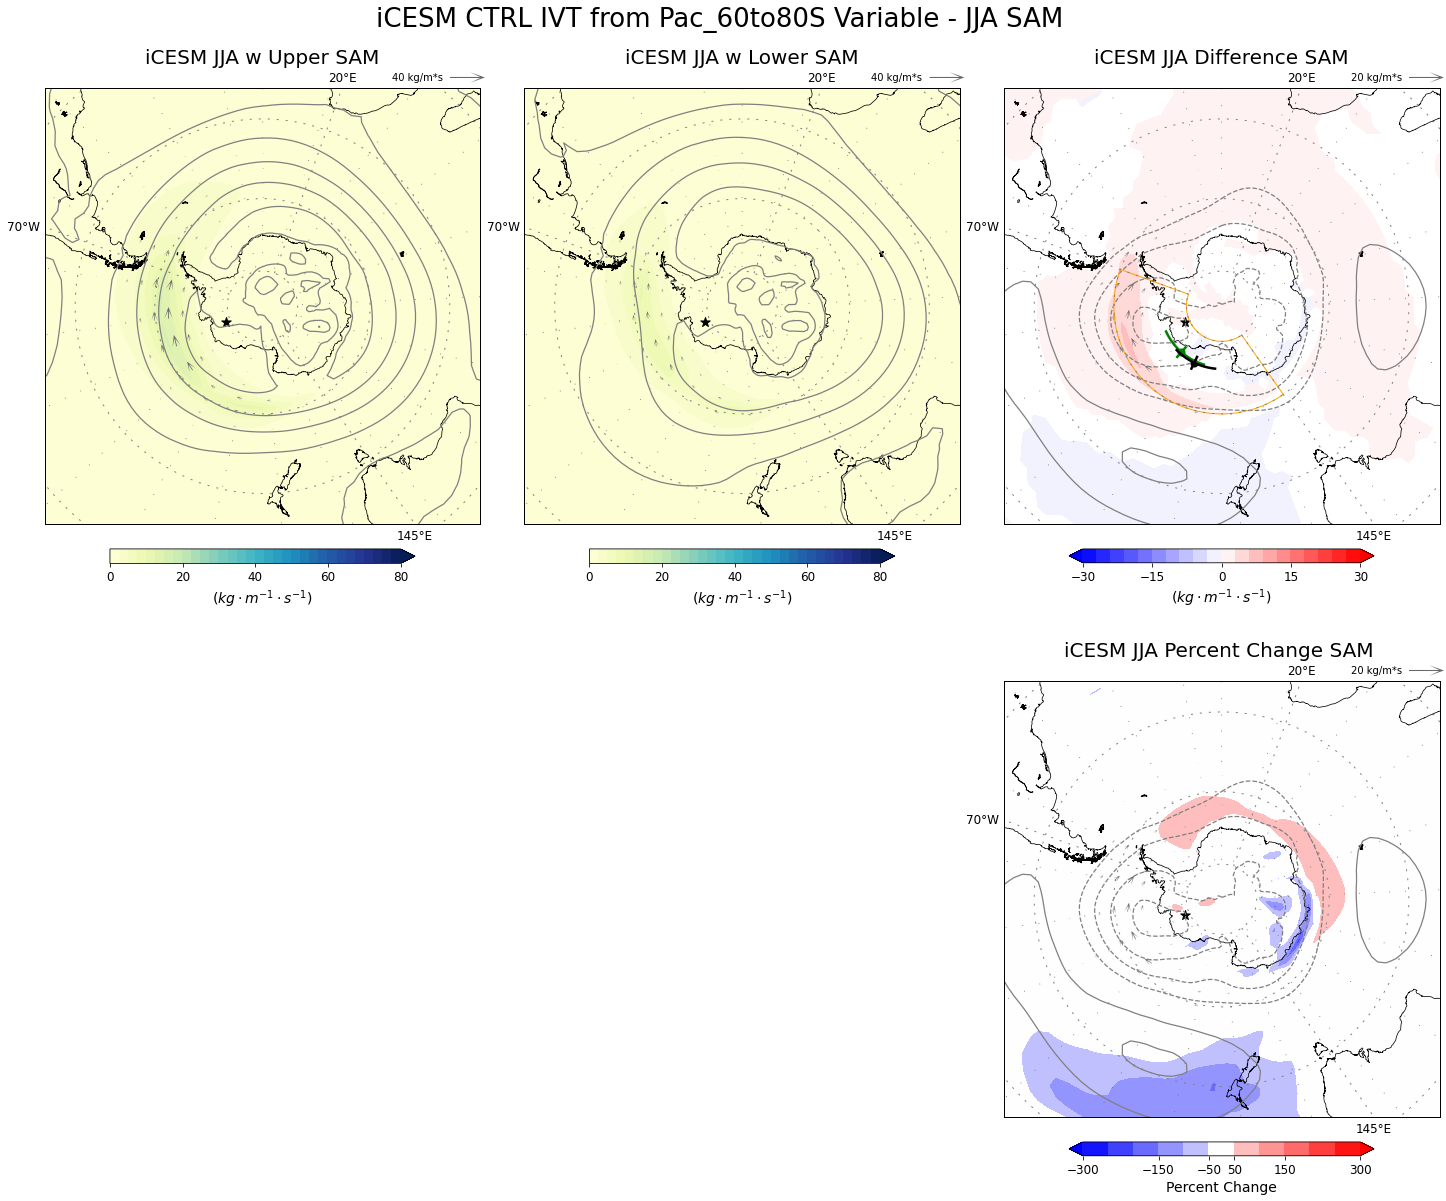

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('iCESM CTRL IVT from Pac_60to80S Variable - JJA SAM', fontsize=26, y=.925)


parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
meridians2 = [-70.,20.,145]
levels_shade = np.arange(0,82.5,2.5)
levels_shade_diff = np.arange(-30,33,3)
# levels_shade_diff_percentage = np.arange(-400,440,40)
levels_shade_diff_percentage = [-300,-250,-200,-150,-100,-50,50,100,150,200,250,300]
# levels_shade_diff_percentage = [-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,50,100,150,200,250,300,350,400,450,500]
levels_contour = np.arange(970,1050,10)
levels_contour_diff = [-12,-9,-6,-3,3,6,9,12] #np.arange(-12,15,3)
levels_contour_model_diff = [-2.03,2.03] #two-tailed significant T value for df = 36 or 38 --- works for icesm winter, summer, annual mean
levels_contour_reanalysis_diff = [-2.11,2.11] #two-tailed significant T value for df = 18 --- works for reanalysis winter, summer, annual mean

plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_w_upper_SAM_ctrl,lat_cyclic_w_upper_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_ctrl,lat_slp_cyclic_w_upper_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_upper_SAM_ctrl, lat_orig_w_upper_SAM_ctrl
m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.shape)
CS = m.contourf(x,y,mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.mean(axis=0),levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='max')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cmap1 = copy.copy(plt.cm.rainbow)
# # CS.cmap.set_under('white')
cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(0,100,20))
cbar.ax.tick_params(labelsize=12)
plt.clim([0,80])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(jja_slp_w_upper_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector(jja_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl.mean(axis=0),jja_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl.mean(axis=0),lon_vec,lat_vec,returnxy=True)
Q = m.quiver(x[6::2,0::7],y[6::2,0::7],(-1)*urot[6::2,0::7],(-1)*vrot[6::2,0::7],latlon=False, scale=500, width=0.0024, headwidth=10, headlength=14, color='dimgray') 
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=40, label='40 kg/m*s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM JJA w Upper SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,mag_mean_Pac_60to80S_cyclic_w_lower_SAM_ctrl.mean(axis=0),levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='max')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(0,100,20))
cbar.ax.tick_params(labelsize=12)
plt.clim([0,80])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(jja_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector(jja_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl.mean(axis=0),jja_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl.mean(axis=0),lon_vec,lat_vec,returnxy=True)
Q = m.quiver(x[6::2,0::7],y[6::2,0::7],(-1)*urot[6::2,0::7],(-1)*vrot[6::2,0::7],latlon=False, scale=500, width=0.0024, headwidth=10, headlength=14, color='dimgray') 
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=40, label='40 kg/m*s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM JJA w Lower SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)

#add tagged outline
#upper parallel
lat_line = np.linspace(-60,-60,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1) 
#lower parallel
lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#westward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(145,145,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#eastward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(290,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)

x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
# CS = m.contourf(x,y,(mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.mean(axis=0)-mag_mean_Pac_60to80S_cyclic_w_lower_SAM_ctrl.mean(axis=0)),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
CS = m.contourf(x,y,np.where(np.abs(diff_jja_ivt_sig_contour_ctrl) >= 2.03, (mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.mean(axis=0)-mag_mean_Pac_60to80S_cyclic_w_lower_SAM_ctrl.mean(axis=0)), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-30,45,15))
cbar.ax.tick_params(labelsize=12)
plt.clim([-30,30])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(jja_slp_w_upper_SAM_detrended_cyclic_ctrl - jja_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector((jja_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl.mean(axis=0) - jja_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl.mean(axis=0)),(jja_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl.mean(axis=0) - jja_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl.mean(axis=0)),lon_vec,lat_vec,returnxy=True)
Q = m.quiver(x[6::2,0::7],y[6::2,0::7],(-1)*urot[6::2,0::7],(-1)*vrot[6::2,0::7],latlon=False, scale=250, width=0.0024, headwidth=10, headlength=14, color='dimgray') 
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=20, label='20 kg/m*s', labelpos='W')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='black', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM JJA Difference SAM',y=1.045,fontsize=20)


ax[1,0].axis('off')
ax[1,1].axis('off')



plt.subplot(2, 3, 6)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,((mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.mean(axis=0)-mag_mean_Pac_60to80S_cyclic_w_lower_SAM_ctrl.mean(axis=0))/mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.mean(axis=0))*100,levels_shade_diff_percentage,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('Percent Change',size=14)
# cbar.set_ticks(np.arange(-500,600,200))
# cbar.set_ticks([-500,-400,-300,-200,-100,100,200,300,400,500])
cbar.set_ticks([-300,-150,-50,50,150,300])
cbar.ax.tick_params(labelsize=12)
plt.clim([-300,300])
plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(jja_slp_w_upper_SAM_detrended_cyclic_ctrl - jja_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector((jja_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl.mean(axis=0) - jja_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl.mean(axis=0)),(jja_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl.mean(axis=0) - jja_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl.mean(axis=0)),lon_vec,lat_vec,returnxy=True)
Q = m.quiver(x[6::2,0::7],y[6::2,0::7],(-1)*urot[6::2,0::7],(-1)*vrot[6::2,0::7],latlon=False, scale=250, width=0.0024, headwidth=10, headlength=14, color='dimgray') 
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=20, label='20 kg/m*s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM JJA Percent Change SAM ',y=1.045,fontsize=20)


print(mag_mean_Pac_60to80S_w_upper_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),mag_mean_Pac_60to80S_w_lower_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),(mag_mean_Pac_60to80S_w_upper_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')-mag_mean_Pac_60to80S_w_lower_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')))
print(((mag_mean_Pac_60to80S_w_upper_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values - mag_mean_Pac_60to80S_w_lower_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)/mag_mean_Pac_60to80S_w_upper_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)*100)

# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_IVT_at_wdc = np.sqrt(jja_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2 + jja_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2)
lower_IVT_at_wdc = np.sqrt(jja_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2 + jja_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2)

print(upper_IVT_at_wdc.shape)
print(lower_IVT_at_wdc.shape)
print(upper_IVT_at_wdc.mean())
print(lower_IVT_at_wdc.mean())
print(upper_IVT_at_wdc.var())
print(lower_IVT_at_wdc.var())

print(ttest_ind(upper_IVT_at_wdc, lower_IVT_at_wdc, equal_var = False))

# plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_IVT_wrt_JJA_SAM_Quartiles_Pac_60to80S_07May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

## For TPW

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(96, 145)
(96, 145)
(19, 96, 145)


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<xarray.DataArray ()>
array(0.13348832)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0.10889246)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0.02459586)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
18.42547903491037
(19,)
(19,)
<xarray.DataArray ()>
array(0.13348832)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.10889246)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.00088466)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.00069469)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
Ttest_indResult(statistic=2.625782307453782, pvalue=0.012674997053465203)


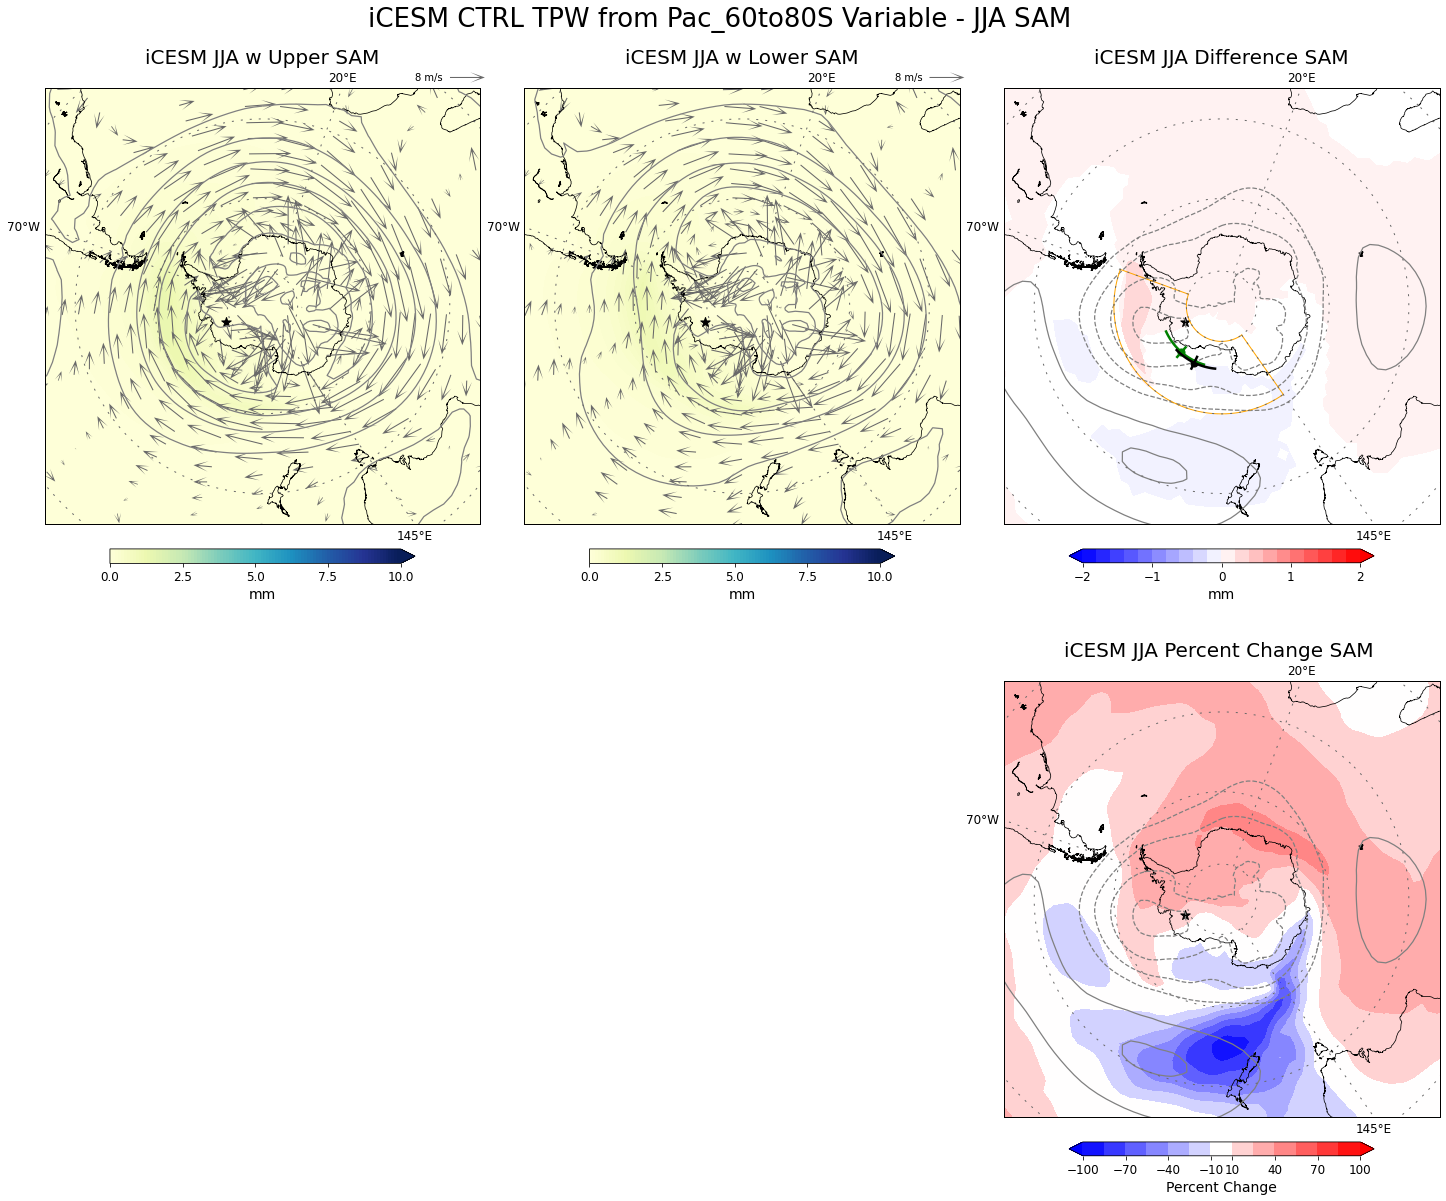

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('iCESM CTRL TPW from Pac_60to80S Variable - JJA SAM', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
meridians2 = [-70.,20.,145]
levels_shade = np.arange(0,10.1,.1)
levels_shade_diff = np.arange(-2,2.2,.2)
# levels_shade_diff_percentage = np.arange(-400,440,40)
# levels_shade_diff_percentage = [-500,-400,-300,-200,-100,100,200,300,400,500]
levels_shade_diff_percentage = [-100,-85,-70,-55,-40,-25,-10,10,25,40,55,70,85,100]
levels_contour = np.arange(970,1050,10)
levels_contour_diff = [-12,-9,-6,-3,3,6,9,12] #np.arange(-12,15,3)

plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_w_upper_SAM_ctrl,lat_cyclic_w_upper_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_ctrl,lat_slp_cyclic_w_upper_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_upper_SAM_ctrl, lat_orig_w_upper_SAM_ctrl
m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='dimgray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='dimgray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.shape)
CS = m.contourf(x,y,jja_tpw_w_upper_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='max')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cmap1 = copy.copy(plt.cm.rainbow)
# # CS.cmap.set_under('white')
cbar.set_label('mm',size=14)
cbar.set_ticks(np.arange(0,12.5,2.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([0,10])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(jja_slp_w_upper_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector(jja_u10_w_upper_SAM_detrended_cyclic_ctrl,jja_v10_w_upper_SAM_detrended_cyclic_ctrl,lon_slp,lat_slp,returnxy=True)
Q = m.quiver(x[4::2,2::7],y[4::2,2::7],(-1)*urot[4::2,2::7],(-1)*vrot[4::2,2::7],latlon=False, scale=100, width=0.0024, headwidth=10, headlength=14, color='dimgray')
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=8, label='8 m/s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM JJA w Upper SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='dimgray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='dimgray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,jja_tpw_w_lower_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='max')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # # CS.cmap.set_under('white')
cbar.set_label('mm',size=14)
cbar.set_ticks(np.arange(0,12.5,2.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([0,10])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(jja_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector(jja_u10_w_lower_SAM_detrended_cyclic_ctrl,jja_v10_w_lower_SAM_detrended_cyclic_ctrl,lon_slp,lat_slp,returnxy=True)
Q = m.quiver(x[4::2,2::7],y[4::2,2::7],(-1)*urot[4::2,2::7],(-1)*vrot[4::2,2::7],latlon=False, scale=100, width=0.0024, headwidth=10, headlength=14, color='dimgray')
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=8, label='8 m/s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM JJA w Lower SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)

#add tagged outline
#upper parallel
lat_line = np.linspace(-60,-60,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1) 
#lower parallel
lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#westward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(145,145,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#eastward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(290,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)

x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='dimgray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='dimgray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
# CS = m.contourf(x,y,(jja_tpw_w_upper_SAM_detrended_cyclic_ctrl-jja_tpw_w_lower_SAM_detrended_cyclic_ctrl),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
CS = m.contourf(x,y,np.where(np.abs(diff_jja_tpw_sig_contour_ctrl) >= 2.03, (jja_tpw_w_upper_SAM_detrended_cyclic_ctrl-jja_tpw_w_lower_SAM_detrended_cyclic_ctrl), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('mm',size=14)
cbar.set_ticks(np.arange(-2,3,1))
cbar.ax.tick_params(labelsize=12)
plt.clim([-2,2])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(jja_slp_w_upper_SAM_detrended_cyclic_ctrl - jja_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector((jja_u10_w_upper_SAM_detrended_cyclic_ctrl-jja_u10_w_lower_SAM_detrended_cyclic_ctrl),(jja_v10_w_upper_SAM_detrended_cyclic_ctrl-jja_v10_w_lower_SAM_detrended_cyclic_ctrl),lon_slp,lat_slp,returnxy=True)
# Q = m.quiver(x[4::2,2::7],y[4::2,2::7],(-1)*urot[6::2,4::7],(-1)*vrot[6::2,4::7],latlon=False, scale=37, width=0.0024, headwidth=10, headlength=14, color='dimgray')
# qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=3, label='3 m/s', labelpos='W')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='black', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM JJA Difference SAM',y=1.045,fontsize=20)


ax[1,0].axis('off')
ax[1,1].axis('off')



plt.subplot(2, 3, 6)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='dimgray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='dimgray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,((jja_tpw_w_upper_SAM_detrended_cyclic_ctrl-jja_tpw_w_lower_SAM_detrended_cyclic_ctrl)/jja_tpw_w_upper_SAM_detrended_cyclic_ctrl)*100,levels_shade_diff_percentage,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('Percent Change',size=14)
# cbar.set_ticks(np.arange(-500,600,200))
cbar.set_ticks([-100,-70,-40,-10,10,40,70,100])
cbar.ax.tick_params(labelsize=12)
plt.clim([-100,100])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(jja_slp_w_upper_SAM_detrended_cyclic_ctrl - jja_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector((jja_u10_w_upper_SAM_detrended_cyclic_ctrl-jja_u10_w_lower_SAM_detrended_cyclic_ctrl),(jja_v10_w_upper_SAM_detrended_cyclic_ctrl-jja_v10_w_lower_SAM_detrended_cyclic_ctrl),lon_slp,lat_slp,returnxy=True)
# Q = m.quiver(x[4::2,2::7],y[4::2,2::7],(-1)*urot[6::2,4::7],(-1)*vrot[6::2,4::7],latlon=False, scale=37, width=0.0024, headwidth=10, headlength=14, color='dimgray')
# qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=3, label='3 m/s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM JJA Percent Change SAM ',y=1.045,fontsize=20)


print(jja_tpw_w_upper_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),jja_tpw_w_lower_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),(jja_tpw_w_upper_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')-jja_tpw_w_lower_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')))
print(((jja_tpw_w_upper_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values - jja_tpw_w_lower_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)/jja_tpw_w_upper_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)*100)

# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_tpw_at_wdc = jja_tpw_w_upper_SAM_detrended_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_tpw_at_wdc = jja_tpw_w_lower_SAM_detrended_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
print(upper_tpw_at_wdc.shape)
print(lower_tpw_at_wdc.shape)
print(upper_tpw_at_wdc.mean())
print(lower_tpw_at_wdc.mean())
print(upper_tpw_at_wdc.var())
print(lower_tpw_at_wdc.var())

print(ttest_ind(upper_tpw_at_wdc, lower_tpw_at_wdc, equal_var = False))

# plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_TPW_wrt_JJA_SAM_Quartiles_Pac_60to80S_07May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

## For d180p

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(96, 145)
(96, 145)
(19, 96, 145)


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:138: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:250: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<xarray.DataArray ()>
array(-2.3740551, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(-1.4088742, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0., dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
68.50725412368774
(19,)
(19,)
<xarray.DataArray ()>
array(-2.374055, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(-1.4088744, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.28384882)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.16211736)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
Ttest_indResult(statistic=-6.131882686002876, pvalue=6.161558858349719e-07)


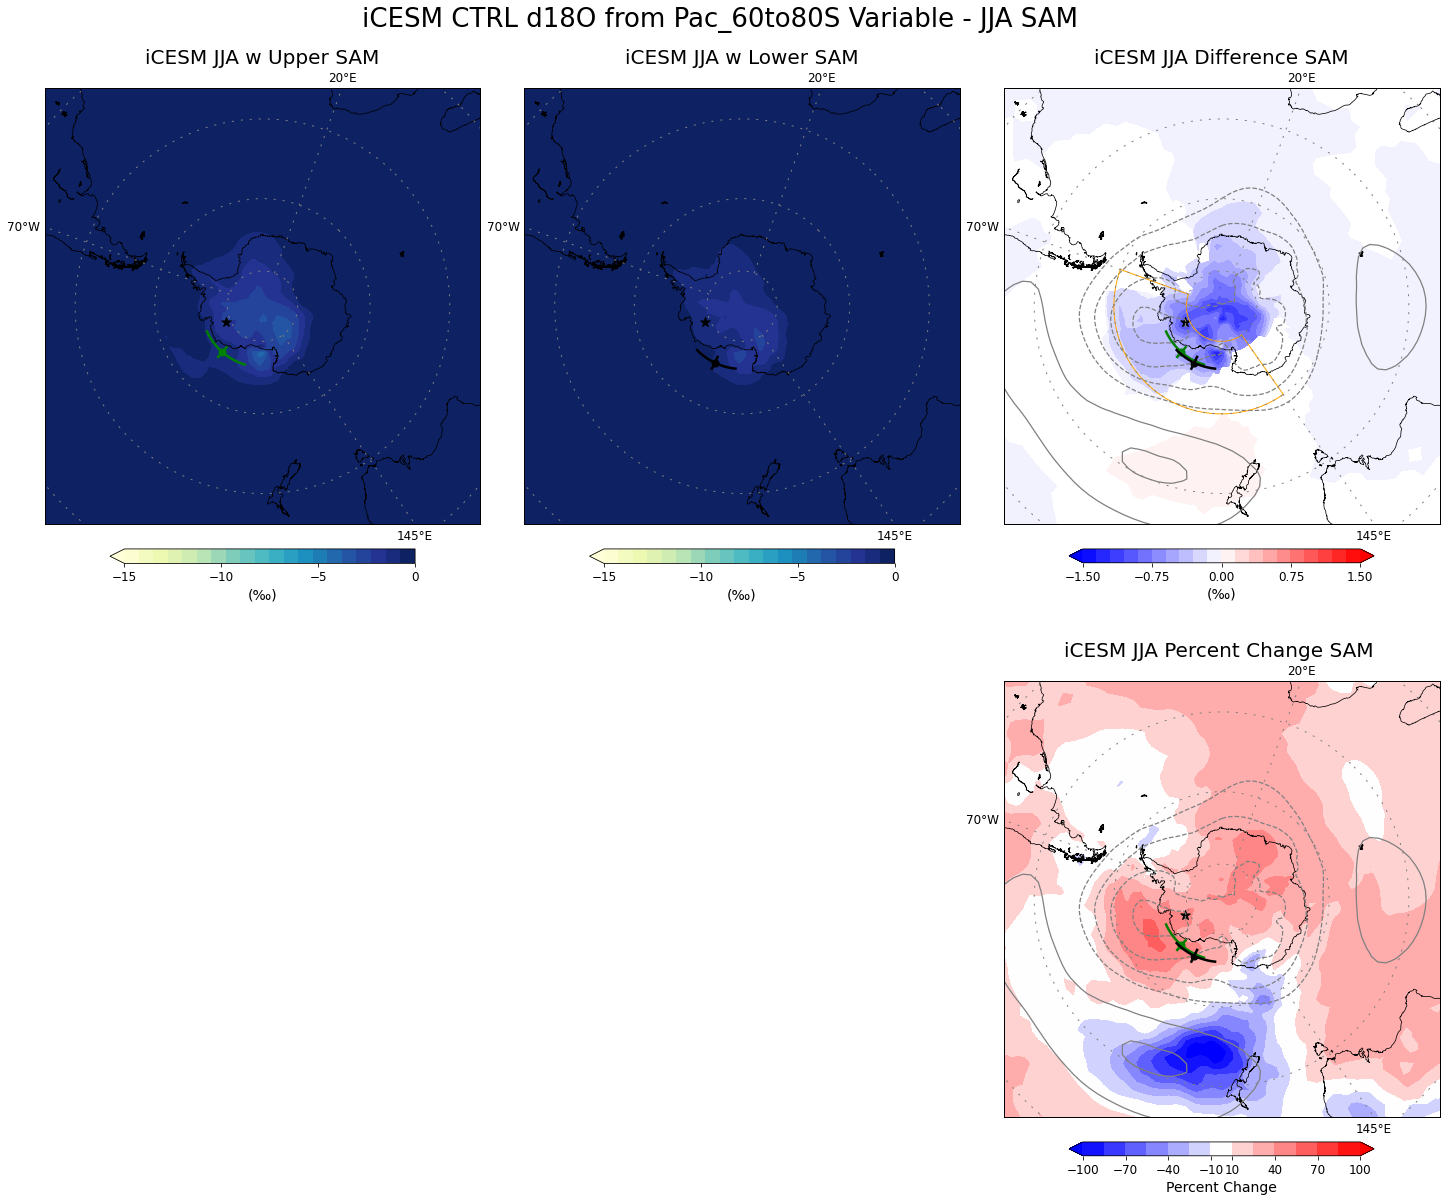

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('iCESM CTRL d18O from Pac_60to80S Variable - JJA SAM', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
meridians2 = [-70.,20.,145]
levels_shade = np.arange(-15,0.75,0.75)
levels_shade_diff = np.arange(-1.5,1.65,.15)
# levels_shade_diff_percentage = np.arange(-400,440,40)
# levels_shade_diff_percentage = [-500,-400,-300,-200,-100,100,200,300,400,500]
levels_shade_diff_percentage = [-100,-85,-70,-55,-40,-25,-10,10,25,40,55,70,85,100]
levels_contour_model_diff = [-2.03,2.03] #two-tailed significant T value for df = 36 or 38 --- works for icesm winter, summer, annual mean
levels_contour_reanalysis_diff = [-2.11,2.11] #two-tailed significant T value for df = 18 --- works for reanalysis winter, summer, annual mean

plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_w_upper_SAM_ctrl,lat_cyclic_w_upper_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_ctrl,lat_slp_cyclic_w_upper_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_upper_SAM_ctrl, lat_orig_w_upper_SAM_ctrl
m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.shape)
CS = m.contourf(x,y,jja_d18O_w_upper_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='min')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cmap1 = copy.copy(plt.cm.rainbow)
# # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-15,5,5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-15,0])
# x_slp, y_slp = m(lon_slp, lat_slp)
# CS2 = m.contour(x_slp,y_slp,(jja_slp_w_upper_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM JJA w Upper SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,jja_d18O_w_lower_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='min')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-15,5,5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-15,0])
# x_slp, y_slp = m(lon_slp, lat_slp)
# CS2 = m.contour(x_slp,y_slp,(jja_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')


#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM JJA w Lower SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)

#add tagged outline
#upper parallel
lat_line = np.linspace(-60,-60,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1) 
#lower parallel
lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#westward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(145,145,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#eastward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(290,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)

x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
# CS = m.contourf(x,y,(jja_d18O_w_upper_SAM_detrended_cyclic_ctrl-jja_d18O_w_lower_SAM_detrended_cyclic_ctrl),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
CS = m.contourf(x,y,np.where(np.abs(diff_jja_d18O_sig_contour_ctrl) >= 2.03, (jja_d18O_w_upper_SAM_detrended_cyclic_ctrl-jja_d18O_w_lower_SAM_detrended_cyclic_ctrl), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
# CS = m.contourf(x,y,np.where(np.abs(diff_jja_tpw_sig_contour_ctrl) >= 2.03, (jja_tpw_w_upper_SAM_detrended_cyclic_ctrl-jja_tpw_w_lower_SAM_detrended_cyclic_ctrl), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-1.5,2.25,0.75))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(jja_slp_w_upper_SAM_detrended_cyclic_ctrl - jja_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='black', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM JJA Difference SAM',y=1.045,fontsize=20)


ax[1,0].axis('off')
ax[1,1].axis('off')



plt.subplot(2, 3, 6)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,((jja_d18O_w_upper_SAM_detrended_cyclic_ctrl-jja_d18O_w_lower_SAM_detrended_cyclic_ctrl)/jja_d18O_w_upper_SAM_detrended_cyclic_ctrl)*100,levels_shade_diff_percentage,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('Percent Change',size=14)
# cbar.set_ticks(np.arange(-500,600,200))
cbar.set_ticks([-100,-70,-40,-10,10,40,70,100])
cbar.ax.tick_params(labelsize=12)
plt.clim([-100,100])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(jja_slp_w_upper_SAM_detrended_cyclic_ctrl - jja_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM JJA Percent Change SAM ',y=1.045,fontsize=20)



print(jja_d18O_w_upper_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),jja_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),(jja_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')-jja_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')))
print(((jja_d18O_w_upper_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values - jja_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)/jja_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)*100)


# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_d18Op_at_wdc = jja_d18O_w_upper_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_d18Op_at_wdc = jja_d18O_w_lower_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')

print(upper_d18Op_at_wdc.shape)
print(lower_d18Op_at_wdc.shape)
print(upper_d18Op_at_wdc.mean())
print(lower_d18Op_at_wdc.mean())
print(upper_d18Op_at_wdc.var())
print(lower_d18Op_at_wdc.var())

print(ttest_ind(upper_d18Op_at_wdc, lower_d18Op_at_wdc, equal_var = False))

# plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_d18O_wrt_JJA_SAM_Quartiles_Pac_60to80S_07May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

## For d180wv

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(96, 145)
(96, 145)
(19, 96, 145)


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:138: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:250: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<xarray.DataArray ()>
array(-4.93638683)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(-3.02577974)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0.)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
63.14428847061598
(19,)
(19,)
<xarray.DataArray ()>
array(-4.93638683)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(-3.02577974)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.51731629)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.24649821)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
Ttest_indResult(statistic=-9.274995111981493, pvalue=1.3913299243608014e-10)


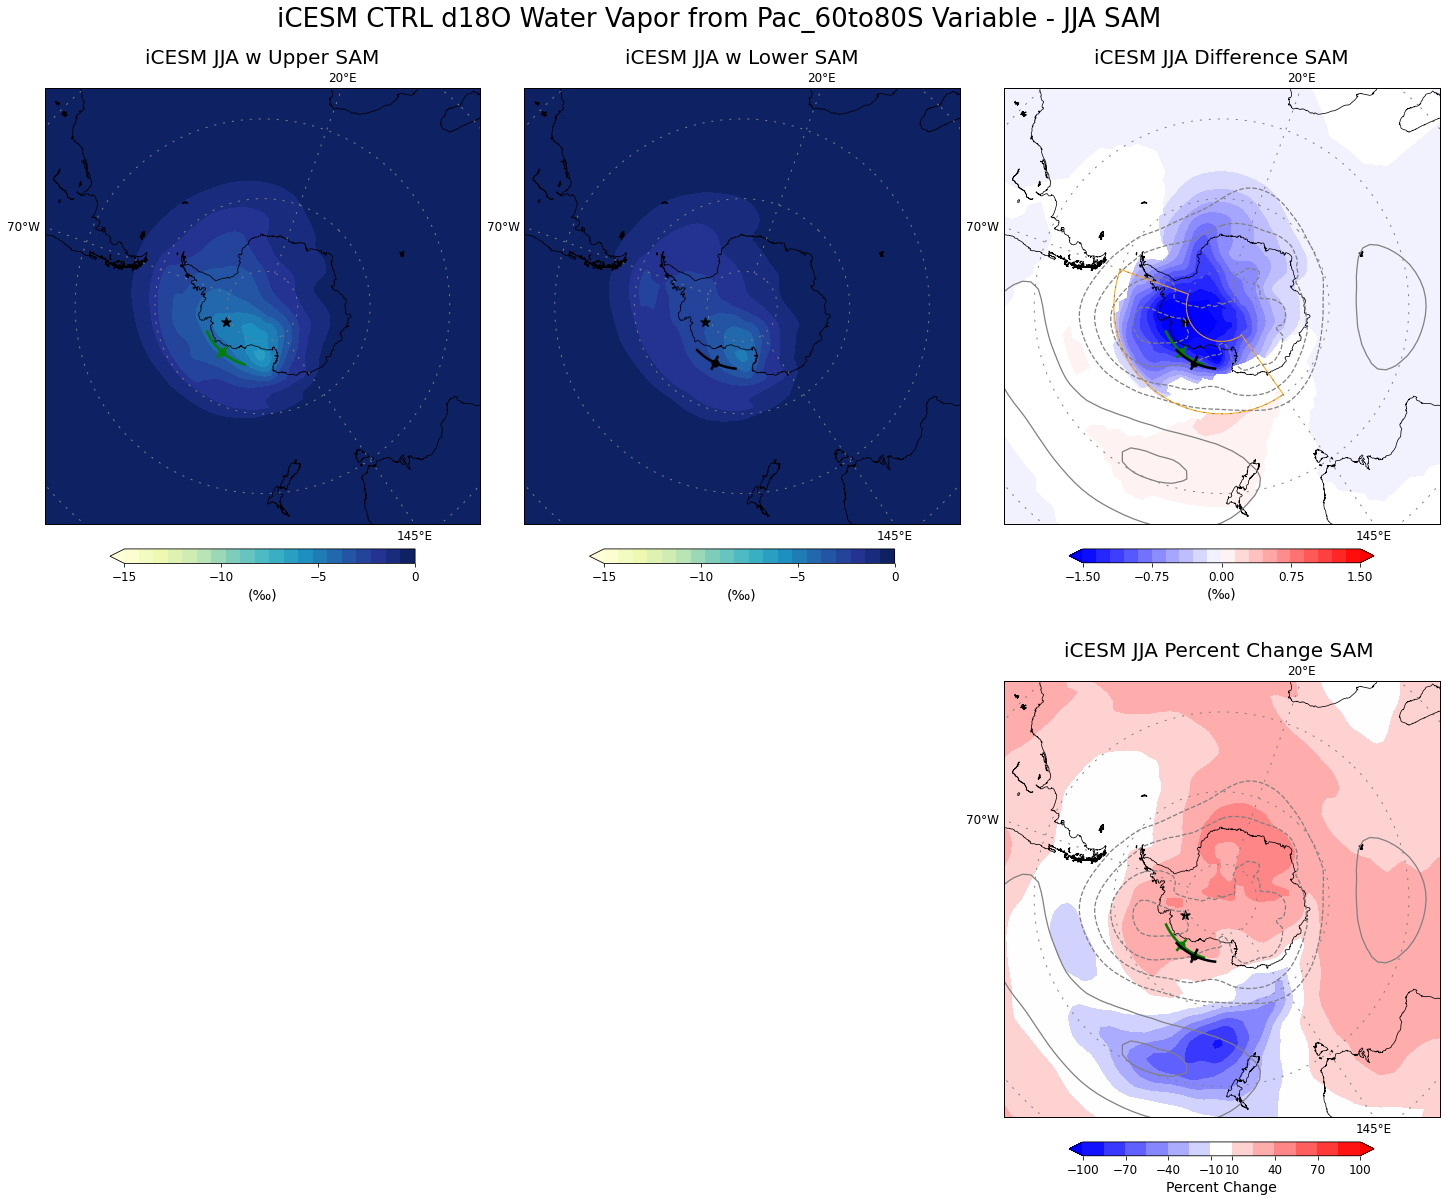

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('iCESM CTRL d18O Water Vapor from Pac_60to80S Variable - JJA SAM', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
meridians2 = [-70.,20.,145]
levels_shade = np.arange(-15,0.75,0.75)
levels_shade_diff = np.arange(-1.5,1.65,.15)
# levels_shade_diff_percentage = np.arange(-400,440,40)
# levels_shade_diff_percentage = [-500,-400,-300,-200,-100,100,200,300,400,500]
levels_shade_diff_percentage = [-100,-85,-70,-55,-40,-25,-10,10,25,40,55,70,85,100]
levels_contour_model_diff = [-2.03,2.03] #two-tailed significant T value for df = 36 or 38 --- works for icesm winter, summer, annual mean
levels_contour_reanalysis_diff = [-2.11,2.11] #two-tailed significant T value for df = 18 --- works for reanalysis winter, summer, annual mean

plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_w_upper_SAM_ctrl,lat_cyclic_w_upper_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_ctrl,lat_slp_cyclic_w_upper_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_upper_SAM_ctrl, lat_orig_w_upper_SAM_ctrl
m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.shape)
CS = m.contourf(x,y,jja_d18O_V_w_upper_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='min')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cmap1 = copy.copy(plt.cm.rainbow)
# # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-15,5,5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-15,0])
# x_slp, y_slp = m(lon_slp, lat_slp)
# CS2 = m.contour(x_slp,y_slp,(jja_slp_w_upper_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM JJA w Upper SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,jja_d18O_V_w_lower_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='min')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-15,5,5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-15,0])
# x_slp, y_slp = m(lon_slp, lat_slp)
# CS2 = m.contour(x_slp,y_slp,(jja_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')


#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM JJA w Lower SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)

#add tagged outline
#upper parallel
lat_line = np.linspace(-60,-60,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1) 
#lower parallel
lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#westward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(145,145,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#eastward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(290,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)

x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
# CS = m.contourf(x,y,(jja_d18O_V_w_upper_SAM_detrended_cyclic_ctrl-jja_d18O_V_w_lower_SAM_detrended_cyclic_ctrl),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
CS = m.contourf(x,y,np.where(np.abs(diff_jja_d18O_V_sig_contour_ctrl) >= 2.03, (jja_d18O_V_w_upper_SAM_detrended_cyclic_ctrl-jja_d18O_V_w_lower_SAM_detrended_cyclic_ctrl), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
# CS = m.contourf(x,y,np.where(np.abs(diff_jja_tpw_sig_contour_ctrl) >= 2.03, (jja_tpw_w_upper_SAM_detrended_cyclic_ctrl-jja_tpw_w_lower_SAM_detrended_cyclic_ctrl), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-1.5,2.25,0.75))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(jja_slp_w_upper_SAM_detrended_cyclic_ctrl - jja_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='black', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM JJA Difference SAM',y=1.045,fontsize=20)


ax[1,0].axis('off')
ax[1,1].axis('off')



plt.subplot(2, 3, 6)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,((jja_d18O_V_w_upper_SAM_detrended_cyclic_ctrl-jja_d18O_V_w_lower_SAM_detrended_cyclic_ctrl)/jja_d18O_V_w_upper_SAM_detrended_cyclic_ctrl)*100,levels_shade_diff_percentage,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('Percent Change',size=14)
# cbar.set_ticks(np.arange(-500,600,200))
cbar.set_ticks([-100,-70,-40,-10,10,40,70,100])
cbar.ax.tick_params(labelsize=12)
plt.clim([-100,100])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(jja_slp_w_upper_SAM_detrended_cyclic_ctrl - jja_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM JJA Percent Change SAM ',y=1.045,fontsize=20)



print(jja_d18O_V_w_upper_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),jja_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),(jja_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')-jja_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')))
print(((jja_d18O_V_w_upper_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values - jja_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)/jja_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)*100)


# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_d18Owv_at_wdc = jja_d18O_V_w_upper_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_d18Owv_at_wdc = jja_d18O_V_w_lower_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')

print(upper_d18Owv_at_wdc.shape)
print(lower_d18Owv_at_wdc.shape)
print(upper_d18Owv_at_wdc.mean())
print(lower_d18Owv_at_wdc.mean())
print(upper_d18Owv_at_wdc.var())
print(lower_d18Owv_at_wdc.var())

print(ttest_ind(upper_d18Owv_at_wdc, lower_d18Owv_at_wdc, equal_var = False))

plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_d18O_Vapor_wrt_JJA_SAM_Quartiles_Pac_60to80S_07May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

## CTRL DJF

## For IVT

In [48]:
# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_IVT_at_wdc = np.sqrt(djf_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2 + djf_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2)
lower_IVT_at_wdc = np.sqrt(djf_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2 + djf_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2)

print(upper_IVT_at_wdc.shape)
print(lower_IVT_at_wdc.shape)
print(upper_IVT_at_wdc.mean())
print(lower_IVT_at_wdc.mean())
print(upper_IVT_at_wdc.var())
print(lower_IVT_at_wdc.var())

ttest_ind(upper_IVT_at_wdc, lower_IVT_at_wdc, equal_var = False)

(18,)
(18,)
<xarray.DataArray ()>
array(0.34385108)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.32170195)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.02581329)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.0251512)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5


Ttest_indResult(statistic=0.40452679616121934, pvalue=0.6883594865972604)

In [49]:
# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_tpw_at_wdc = djf_tpw_w_upper_SAM_detrended_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_tpw_at_wdc = djf_tpw_w_lower_SAM_detrended_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
print(upper_tpw_at_wdc.shape)
print(lower_tpw_at_wdc.shape)
print(upper_tpw_at_wdc.mean())
print(lower_tpw_at_wdc.mean())
print(upper_tpw_at_wdc.var())
print(lower_tpw_at_wdc.var())

ttest_ind(upper_tpw_at_wdc, lower_tpw_at_wdc, equal_var = False)

(18,)
(18,)
<xarray.DataArray ()>
array(0.20068352)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.21619665)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.00046503)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.00305481)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5


Ttest_indResult(statistic=-1.078107653320883, pvalue=0.2926347145984771)

In [50]:
# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_d18Op_at_wdc = djf_d18O_w_upper_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_d18Op_at_wdc = djf_d18O_w_lower_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')

print(upper_d18Op_at_wdc.shape)
print(lower_d18Op_at_wdc.shape)
print(upper_d18Op_at_wdc.mean())
print(lower_d18Op_at_wdc.mean())
print(upper_d18Op_at_wdc.var())
print(lower_d18Op_at_wdc.var())

ttest_ind(upper_d18Op_at_wdc, lower_d18Op_at_wdc, equal_var = False)

(18,)
(18,)
<xarray.DataArray ()>
array(-1.116989, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(-0.94009674, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.08216821)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.06799852)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5


Ttest_indResult(statistic=-1.8821163930987268, pvalue=0.06847930923853257)

In [51]:
# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_d18Owv_at_wdc = djf_d18O_V_w_upper_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_d18Owv_at_wdc = djf_d18O_V_w_lower_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')

print(upper_d18Owv_at_wdc.shape)
print(lower_d18Owv_at_wdc.shape)
print(upper_d18Owv_at_wdc.mean())
print(lower_d18Owv_at_wdc.mean())
print(upper_d18Owv_at_wdc.var())
print(lower_d18Owv_at_wdc.var())

ttest_ind(upper_d18Owv_at_wdc, lower_d18Owv_at_wdc, equal_var = False)

(18,)
(18,)
<xarray.DataArray ()>
array(-2.42052358)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(-2.19725905)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.10562941)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.20624547)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5


Ttest_indResult(statistic=-1.6483673710652762, pvalue=0.10944414663648315)

In [52]:
#Prepping data for plotting and differencing of iCESM and MERRA--which are on different grids
#need to add cyclic as well

#iCESM CTRL data
#just need to add cyclic and keep original for vectors
# MAGNITUDE TIME MEAN IS WITHHELD UNTIL PLOTTING, THIS ENSURES CONSISTENCY IN RESULTS BTW THE SIG STATS AND THE PLOT
mag_mean_Pac_60to80S_w_upper_SAM_ctrl = np.sqrt(djf_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl**2 + djf_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl**2)
mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl, lons = add_cyclic_point(mag_mean_Pac_60to80S_w_upper_SAM_ctrl.values, mag_mean_Pac_60to80S_w_upper_SAM_ctrl.coords['lon'].values, axis=-1)
lon_orig_w_upper_SAM_ctrl, lat_orig_w_upper_SAM_ctrl = np.meshgrid(mag_mean_Pac_60to80S_w_upper_SAM_ctrl.coords['lon'].values,mag_mean_Pac_60to80S_w_upper_SAM_ctrl.coords['lat'].values)
lon_cyclic_w_upper_SAM_ctrl, lat_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons,mag_mean_Pac_60to80S_w_upper_SAM_ctrl.coords['lat'].values)
djf_tpw_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_tpw_w_upper_SAM_detrended_ctrl.mean(axis=0).values, djf_tpw_w_upper_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_tpw_cyclic_w_upper_SAM_ctrl, lat_tpw_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, djf_tpw_w_upper_SAM_detrended_ctrl.coords['lat'].values)
#slp and wind are on atmo grid, <- took care of this during plotting
djf_slp_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_slp_w_upper_SAM_detrended_ctrl.mean(axis=0).values, djf_slp_w_upper_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_upper_SAM_ctrl, lat_slp_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, djf_slp_w_upper_SAM_detrended_ctrl.coords['lat'].values)
djf_u10_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_u10_w_upper_SAM_detrended_ctrl.mean(axis=0).values, djf_u10_w_upper_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_upper_SAM_ctrl, lat_u10_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, djf_u10_w_upper_SAM_detrended_ctrl.coords['lat'].values)
djf_v10_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_v10_w_upper_SAM_detrended_ctrl.mean(axis=0).values, djf_v10_w_upper_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_upper_SAM_ctrl, lat_v10_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, djf_v10_w_upper_SAM_detrended_ctrl.coords['lat'].values)
djf_d18O_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_d18O_w_upper_SAM_raw_ctrl.mean(axis=0).values, djf_d18O_w_upper_SAM_raw_ctrl.coords['lon'].values, axis=-1)
lon_d18O_cyclic_w_upper_SAM_ctrl, lat_d18O_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, djf_d18O_w_upper_SAM_raw_ctrl.coords['lat'].values)
djf_d18O_V_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_d18O_V_w_upper_SAM_raw_ctrl.mean(axis=0).values, djf_d18O_V_w_upper_SAM_raw_ctrl.coords['lon'].values, axis=-1)
lon_d18O_V_cyclic_w_upper_SAM_ctrl, lat_d18O_V_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, djf_d18O_V_w_upper_SAM_raw_ctrl.coords['lat'].values)


mag_mean_Pac_60to80S_w_lower_SAM_ctrl = np.sqrt(djf_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl**2 + djf_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl**2)
mag_mean_Pac_60to80S_cyclic_w_lower_SAM_ctrl, lons = add_cyclic_point(mag_mean_Pac_60to80S_w_lower_SAM_ctrl.values, mag_mean_Pac_60to80S_w_lower_SAM_ctrl.coords['lon'].values, axis=-1)
lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl = np.meshgrid(mag_mean_Pac_60to80S_w_lower_SAM_ctrl.coords['lon'].values,mag_mean_Pac_60to80S_w_lower_SAM_ctrl.coords['lat'].values)
lon_cyclic_w_lower_SAM_ctrl, lat_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons,mag_mean_Pac_60to80S_w_lower_SAM_ctrl.coords['lat'].values)
djf_tpw_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_tpw_w_lower_SAM_detrended_ctrl.mean(axis=0).values, djf_tpw_w_lower_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_tpw_cyclic_w_lower_SAM_ctrl, lat_tpw_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, djf_tpw_w_lower_SAM_detrended_ctrl.coords['lat'].values)
djf_slp_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_slp_w_lower_SAM_detrended_ctrl.mean(axis=0).values, djf_slp_w_lower_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_lower_SAM_ctrl, lat_slp_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, djf_slp_w_lower_SAM_detrended_ctrl.coords['lat'].values)
djf_u10_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_u10_w_lower_SAM_detrended_ctrl.mean(axis=0).values, djf_u10_w_lower_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_lower_SAM_ctrl, lat_u10_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, djf_u10_w_lower_SAM_detrended_ctrl.coords['lat'].values)
djf_v10_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_v10_w_lower_SAM_detrended_ctrl.mean(axis=0).values, djf_v10_w_lower_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_lower_SAM_ctrl, lat_v10_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, djf_v10_w_lower_SAM_detrended_ctrl.coords['lat'].values)
djf_d18O_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).values, djf_d18O_w_lower_SAM_raw_ctrl.coords['lon'].values, axis=-1)
lon_d18O_cyclic_w_lower_SAM_ctrl, lat_d18O_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, djf_d18O_w_lower_SAM_raw_ctrl.coords['lat'].values)
djf_d18O_V_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(djf_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).values, djf_d18O_V_w_lower_SAM_raw_ctrl.coords['lon'].values, axis=-1)
lon_d18O_V_cyclic_w_lower_SAM_ctrl, lat_d18O_V_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, djf_d18O_V_w_lower_SAM_raw_ctrl.coords['lat'].values)


#gather variable for contour of significant change of d18O
djf_d18O_change_due_to_SAM_ttest_stats_ctrl, djf_d18O_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    djf_d18O_w_upper_SAM_raw_ctrl, djf_d18O_w_lower_SAM_raw_ctrl, axis=0)

diff_djf_d18O_sig_contour_ctrl, lons = add_cyclic_point(djf_d18O_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

#gather variable for contour of significant change of d18O of water vapor
djf_d18O_V_change_due_to_SAM_ttest_stats_ctrl, djf_d18O_V_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    djf_d18O_V_w_upper_SAM_raw_ctrl, djf_d18O_w_lower_SAM_raw_ctrl, axis=0)

diff_djf_d18O_V_sig_contour_ctrl, lons = add_cyclic_point(djf_d18O_V_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

#gather variable for contour of significant change of tpw
djf_tpw_change_due_to_SAM_ttest_stats_ctrl, djf_tpw_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    djf_tpw_w_upper_SAM_detrended_ctrl, djf_tpw_w_lower_SAM_detrended_ctrl, axis=0)

diff_djf_tpw_sig_contour_ctrl, lons = add_cyclic_point(djf_tpw_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

#gather variable for contour of significant change of ivt
djf_ivt_change_due_to_SAM_ttest_stats_ctrl, djf_ivt_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    mag_mean_Pac_60to80S_w_upper_SAM_ctrl, mag_mean_Pac_60to80S_w_lower_SAM_ctrl, axis=0)

diff_djf_ivt_sig_contour_ctrl, lons = add_cyclic_point(djf_ivt_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(96, 145)
(96, 145)
(18, 96, 145)


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<xarray.DataArray ()>
array(0.34385108)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0.32170195)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0.02214913)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
6.441489299247238
(18,)
(18,)
<xarray.DataArray ()>
array(0.34385108)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.32170195)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.02581329)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.0251512)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
Ttest_indResult(statistic=0.40452679616121934, pvalue=0.6883594865972604)


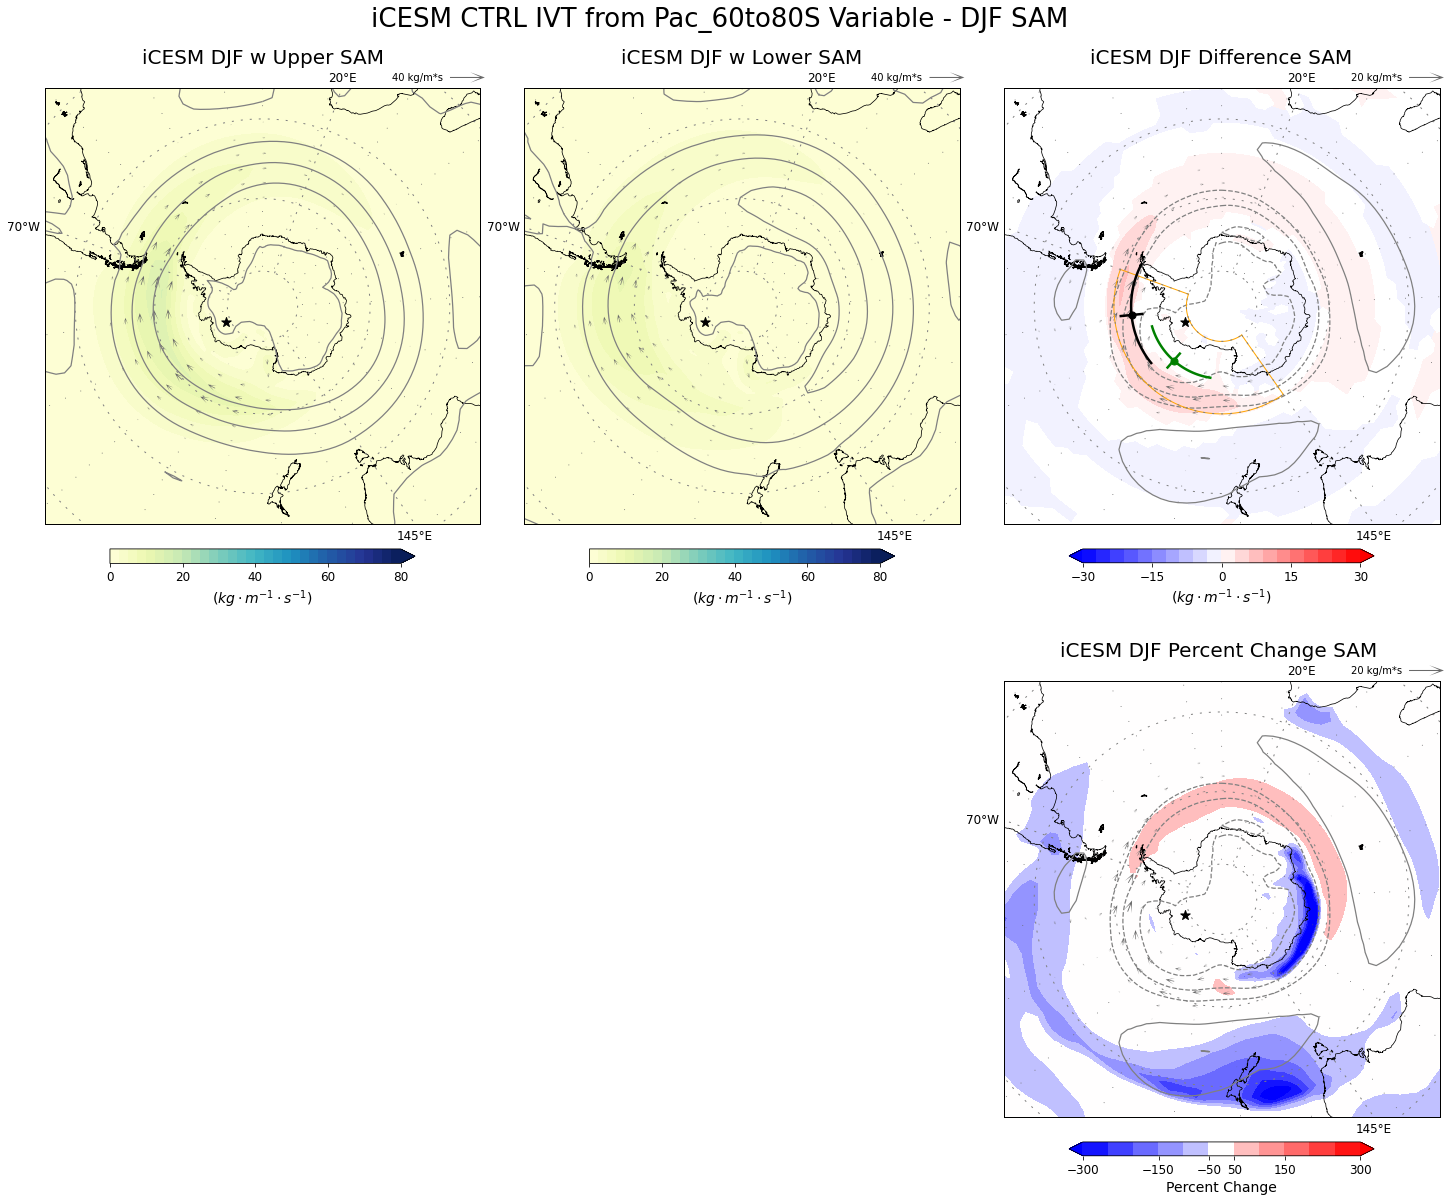

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('iCESM CTRL IVT from Pac_60to80S Variable - DJF SAM', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
meridians2 = [-70.,20.,145]
levels_shade = np.arange(0,82.5,2.5)
levels_shade_diff = np.arange(-30,33,3)
# levels_shade_diff_percentage = np.arange(-400,440,40)
levels_shade_diff_percentage = [-300,-250,-200,-150,-100,-50,50,100,150,200,250,300]
# levels_shade_diff_percentage = [-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,50,100,150,200,250,300,350,400,450,500]
levels_contour = np.arange(970,1050,10)
levels_contour_diff = [-12,-9,-6,-3,3,6,9,12] #np.arange(-12,15,3)
levels_contour_model_diff = [-2.03,2.03] #two-tailed significant T value for df = 36 or 38 --- works for icesm winter, summer, annual mean
levels_contour_reanalysis_diff = [-2.11,2.11] #two-tailed significant T value for df = 18 --- works for reanalysis winter, summer, annual mean

plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_w_upper_SAM_ctrl,lat_cyclic_w_upper_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_ctrl,lat_slp_cyclic_w_upper_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_upper_SAM_ctrl, lat_orig_w_upper_SAM_ctrl
m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.shape)
CS = m.contourf(x,y,mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.mean(axis=0),levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='max')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cmap1 = copy.copy(plt.cm.rainbow)
# # CS.cmap.set_under('white')
cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(0,100,20))
cbar.ax.tick_params(labelsize=12)
plt.clim([0,80])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(djf_slp_w_upper_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector(djf_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl.mean(axis=0),djf_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl.mean(axis=0),lon_vec,lat_vec,returnxy=True)
Q = m.quiver(x[6::2,0::7],y[6::2,0::7],(-1)*urot[6::2,0::7],(-1)*vrot[6::2,0::7],latlon=False, scale=500, width=0.0024, headwidth=10, headlength=14, color='dimgray') 
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=40, label='40 kg/m*s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM DJF w Upper SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,mag_mean_Pac_60to80S_cyclic_w_lower_SAM_ctrl.mean(axis=0),levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='max')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(0,100,20))
cbar.ax.tick_params(labelsize=12)
plt.clim([0,80])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(djf_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector(djf_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl.mean(axis=0),djf_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl.mean(axis=0),lon_vec,lat_vec,returnxy=True)
Q = m.quiver(x[6::2,0::7],y[6::2,0::7],(-1)*urot[6::2,0::7],(-1)*vrot[6::2,0::7],latlon=False, scale=500, width=0.0024, headwidth=10, headlength=14, color='dimgray') 
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=40, label='40 kg/m*s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM DJF w Lower SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)

#add tagged outline
#upper parallel
lat_line = np.linspace(-60,-60,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1) 
#lower parallel
lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#westward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(145,145,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#eastward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(290,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)

x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
# CS = m.contourf(x,y,(mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.mean(axis=0)-mag_mean_Pac_60to80S_cyclic_w_lower_SAM_ctrl.mean(axis=0)),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
CS = m.contourf(x,y,np.where(np.abs(diff_djf_ivt_sig_contour_ctrl) >= 2.03, (mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.mean(axis=0)-mag_mean_Pac_60to80S_cyclic_w_lower_SAM_ctrl.mean(axis=0)), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-30,45,15))
cbar.ax.tick_params(labelsize=12)
plt.clim([-30,30])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(djf_slp_w_upper_SAM_detrended_cyclic_ctrl - djf_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector((djf_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl.mean(axis=0) - djf_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl.mean(axis=0)),(djf_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl.mean(axis=0) - djf_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl.mean(axis=0)),lon_vec,lat_vec,returnxy=True)
Q = m.quiver(x[6::2,0::7],y[6::2,0::7],(-1)*urot[6::2,0::7],(-1)*vrot[6::2,0::7],latlon=False, scale=250, width=0.0024, headwidth=10, headlength=14, color='dimgray') 
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=20, label='20 kg/m*s', labelpos='W')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM DJF Difference SAM',y=1.045,fontsize=20)


ax[1,0].axis('off')
ax[1,1].axis('off')



plt.subplot(2, 3, 6)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,((mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.mean(axis=0)-mag_mean_Pac_60to80S_cyclic_w_lower_SAM_ctrl.mean(axis=0))/mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.mean(axis=0))*100,levels_shade_diff_percentage,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('Percent Change',size=14)
# cbar.set_ticks(np.arange(-500,600,200))
# cbar.set_ticks([-500,-400,-300,-200,-100,100,200,300,400,500])
cbar.set_ticks([-300,-150,-50,50,150,300])
cbar.ax.tick_params(labelsize=12)
plt.clim([-300,300])
plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(djf_slp_w_upper_SAM_detrended_cyclic_ctrl - djf_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector((djf_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl.mean(axis=0) - djf_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl.mean(axis=0)),(djf_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl.mean(axis=0) - djf_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl.mean(axis=0)),lon_vec,lat_vec,returnxy=True)
Q = m.quiver(x[6::2,0::7],y[6::2,0::7],(-1)*urot[6::2,0::7],(-1)*vrot[6::2,0::7],latlon=False, scale=250, width=0.0024, headwidth=10, headlength=14, color='dimgray') 
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=20, label='20 kg/m*s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM DJF Percent Change SAM ',y=1.045,fontsize=20)


print(mag_mean_Pac_60to80S_w_upper_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),mag_mean_Pac_60to80S_w_lower_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),(mag_mean_Pac_60to80S_w_upper_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')-mag_mean_Pac_60to80S_w_lower_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')))
print(((mag_mean_Pac_60to80S_w_upper_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values - mag_mean_Pac_60to80S_w_lower_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)/mag_mean_Pac_60to80S_w_upper_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)*100)

# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_IVT_at_wdc = np.sqrt(djf_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2 + djf_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2)
lower_IVT_at_wdc = np.sqrt(djf_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2 + djf_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2)

print(upper_IVT_at_wdc.shape)
print(lower_IVT_at_wdc.shape)
print(upper_IVT_at_wdc.mean())
print(lower_IVT_at_wdc.mean())
print(upper_IVT_at_wdc.var())
print(lower_IVT_at_wdc.var())

print(ttest_ind(upper_IVT_at_wdc, lower_IVT_at_wdc, equal_var = False))

# plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_IVT_wrt_DJF_SAM_Quartiles_Pac_60to80S_07May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

## For TPW

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(96, 145)
(96, 145)
(18, 96, 145)


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:201: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<xarray.DataArray ()>
array(0.20068352)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0.21619665)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(-0.01551313)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
-7.730145046967983
(18,)
(18,)
<xarray.DataArray ()>
array(0.20068352)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.21619665)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.00046503)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.00305481)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
Ttest_indResult(statistic=-1.078107653320883, pvalue=0.2926347145984771)


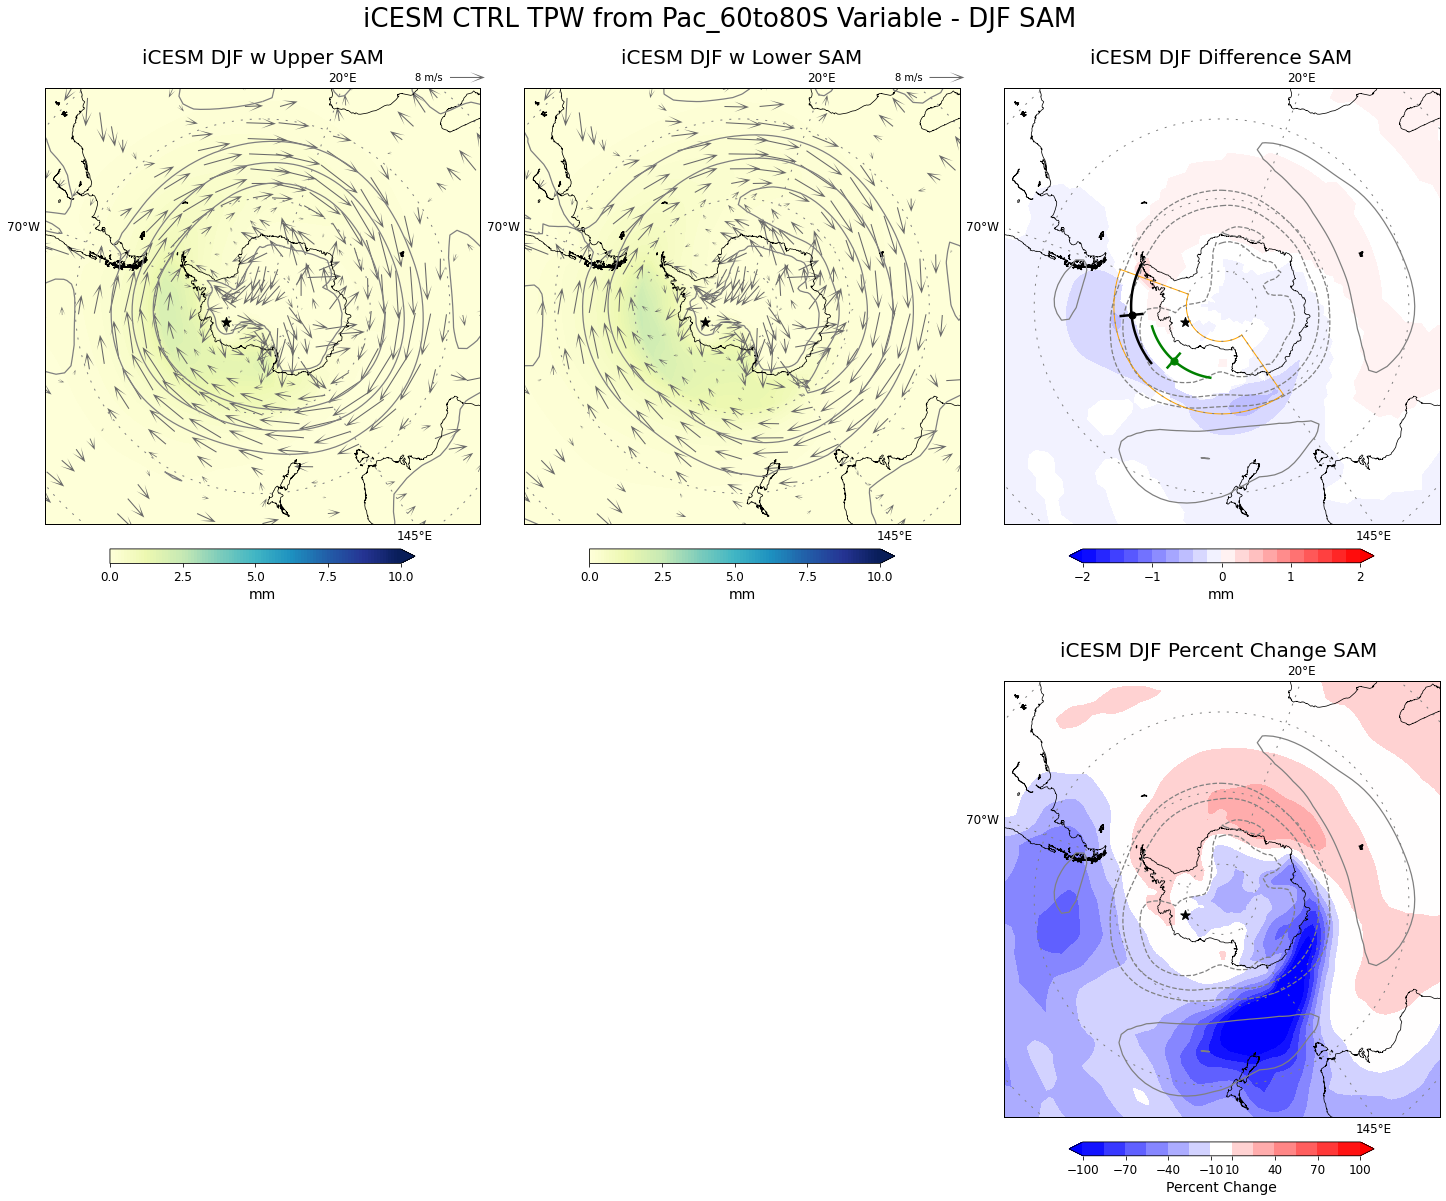

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('iCESM CTRL TPW from Pac_60to80S Variable - DJF SAM', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
meridians2 = [-70.,20.,145]
levels_shade = np.arange(0,10.1,.1)
levels_shade_diff = np.arange(-2,2.2,.2)
# levels_shade_diff_percentage = np.arange(-400,440,40)
# levels_shade_diff_percentage = [-500,-400,-300,-200,-100,100,200,300,400,500]
levels_shade_diff_percentage = [-100,-85,-70,-55,-40,-25,-10,10,25,40,55,70,85,100]
levels_contour = np.arange(970,1050,10)
levels_contour_diff = [-12,-9,-6,-3,3,6,9,12] #np.arange(-12,15,3)

plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_w_upper_SAM_ctrl,lat_cyclic_w_upper_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_ctrl,lat_slp_cyclic_w_upper_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_upper_SAM_ctrl, lat_orig_w_upper_SAM_ctrl
m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.shape)
CS = m.contourf(x,y,djf_tpw_w_upper_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='max')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cmap1 = copy.copy(plt.cm.rainbow)
# # CS.cmap.set_under('white')
cbar.set_label('mm',size=14)
cbar.set_ticks(np.arange(0,12.5,2.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([0,10])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(djf_slp_w_upper_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector(djf_u10_w_upper_SAM_detrended_cyclic_ctrl,djf_v10_w_upper_SAM_detrended_cyclic_ctrl,lon_slp,lat_slp,returnxy=True)
Q = m.quiver(x[4::2,2::7],y[4::2,2::7],(-1)*urot[4::2,2::7],(-1)*vrot[4::2,2::7],latlon=False, scale=100, width=0.0024, headwidth=10, headlength=14, color='dimgray')
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=8, label='8 m/s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM DJF w Upper SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,djf_tpw_w_lower_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='max')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # # CS.cmap.set_under('white')
cbar.set_label('mm',size=14)
cbar.set_ticks(np.arange(0,12.5,2.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([0,10])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(djf_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector(djf_u10_w_lower_SAM_detrended_cyclic_ctrl,djf_v10_w_lower_SAM_detrended_cyclic_ctrl,lon_slp,lat_slp,returnxy=True)
Q = m.quiver(x[4::2,2::7],y[4::2,2::7],(-1)*urot[4::2,2::7],(-1)*vrot[4::2,2::7],latlon=False, scale=100, width=0.0024, headwidth=10, headlength=14, color='dimgray')
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=8, label='8 m/s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM DJF w Lower SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)

#add tagged outline
#upper parallel
lat_line = np.linspace(-60,-60,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1) 
#lower parallel
lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#westward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(145,145,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#eastward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(290,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)

x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
# CS = m.contourf(x,y,(djf_tpw_w_upper_SAM_detrended_cyclic_ctrl-djf_tpw_w_lower_SAM_detrended_cyclic_ctrl),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
CS = m.contourf(x,y,np.where(np.abs(diff_djf_tpw_sig_contour_ctrl) >= 2.03, (djf_tpw_w_upper_SAM_detrended_cyclic_ctrl-djf_tpw_w_lower_SAM_detrended_cyclic_ctrl), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('mm',size=14)
cbar.set_ticks(np.arange(-2,3,1))
cbar.ax.tick_params(labelsize=12)
plt.clim([-2,2])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(djf_slp_w_upper_SAM_detrended_cyclic_ctrl - djf_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector((djf_u10_w_upper_SAM_detrended_cyclic_ctrl-djf_u10_w_lower_SAM_detrended_cyclic_ctrl),(djf_v10_w_upper_SAM_detrended_cyclic_ctrl-djf_v10_w_lower_SAM_detrended_cyclic_ctrl),lon_slp,lat_slp,returnxy=True)
# Q = m.quiver(x[4::2,2::7],y[4::2,2::7],(-1)*urot[6::2,4::7],(-1)*vrot[6::2,4::7],latlon=False, scale=37, width=0.0024, headwidth=10, headlength=14, color='dimgray')
# qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=3, label='3 m/s', labelpos='W')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM DJF Difference SAM',y=1.045,fontsize=20)


ax[1,0].axis('off')
ax[1,1].axis('off')



plt.subplot(2, 3, 6)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,((djf_tpw_w_upper_SAM_detrended_cyclic_ctrl-djf_tpw_w_lower_SAM_detrended_cyclic_ctrl)/djf_tpw_w_upper_SAM_detrended_cyclic_ctrl)*100,levels_shade_diff_percentage,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('Percent Change',size=14)
# cbar.set_ticks(np.arange(-500,600,200))
cbar.set_ticks([-100,-70,-40,-10,10,40,70,100])
cbar.ax.tick_params(labelsize=12)
plt.clim([-100,100])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(djf_slp_w_upper_SAM_detrended_cyclic_ctrl - djf_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector((djf_u10_w_upper_SAM_detrended_cyclic_ctrl-djf_u10_w_lower_SAM_detrended_cyclic_ctrl),(djf_v10_w_upper_SAM_detrended_cyclic_ctrl-djf_v10_w_lower_SAM_detrended_cyclic_ctrl),lon_slp,lat_slp,returnxy=True)
# Q = m.quiver(x[4::2,2::7],y[4::2,2::7],(-1)*urot[6::2,4::7],(-1)*vrot[6::2,4::7],latlon=False, scale=37, width=0.0024, headwidth=10, headlength=14, color='dimgray')
# qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=3, label='3 m/s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM DJF Percent Change SAM ',y=1.045,fontsize=20)


print(djf_tpw_w_upper_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),djf_tpw_w_lower_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),(djf_tpw_w_upper_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')-djf_tpw_w_lower_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')))
print(((djf_tpw_w_upper_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values - djf_tpw_w_lower_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)/djf_tpw_w_upper_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)*100)

# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_tpw_at_wdc = djf_tpw_w_upper_SAM_detrended_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_tpw_at_wdc = djf_tpw_w_lower_SAM_detrended_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
print(upper_tpw_at_wdc.shape)
print(lower_tpw_at_wdc.shape)
print(upper_tpw_at_wdc.mean())
print(lower_tpw_at_wdc.mean())
print(upper_tpw_at_wdc.var())
print(lower_tpw_at_wdc.var())

print(ttest_ind(upper_tpw_at_wdc, lower_tpw_at_wdc, equal_var = False))

# plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_TPW_wrt_DJF_SAM_Quartiles_Pac_60to80S_07May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

## For d180p

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(96, 145)
(96, 145)
(18, 96, 145)


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:138: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:251: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<xarray.DataArray ()>
array(-1.116989, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(-0.94009674, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0., dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
18.81639063358307
(18,)
(18,)
<xarray.DataArray ()>
array(-1.116989, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(-0.94009674, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.08216821)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.06799852)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
Ttest_indResult(statistic=-1.8821163930987268, pvalue=0.06847930923853257)


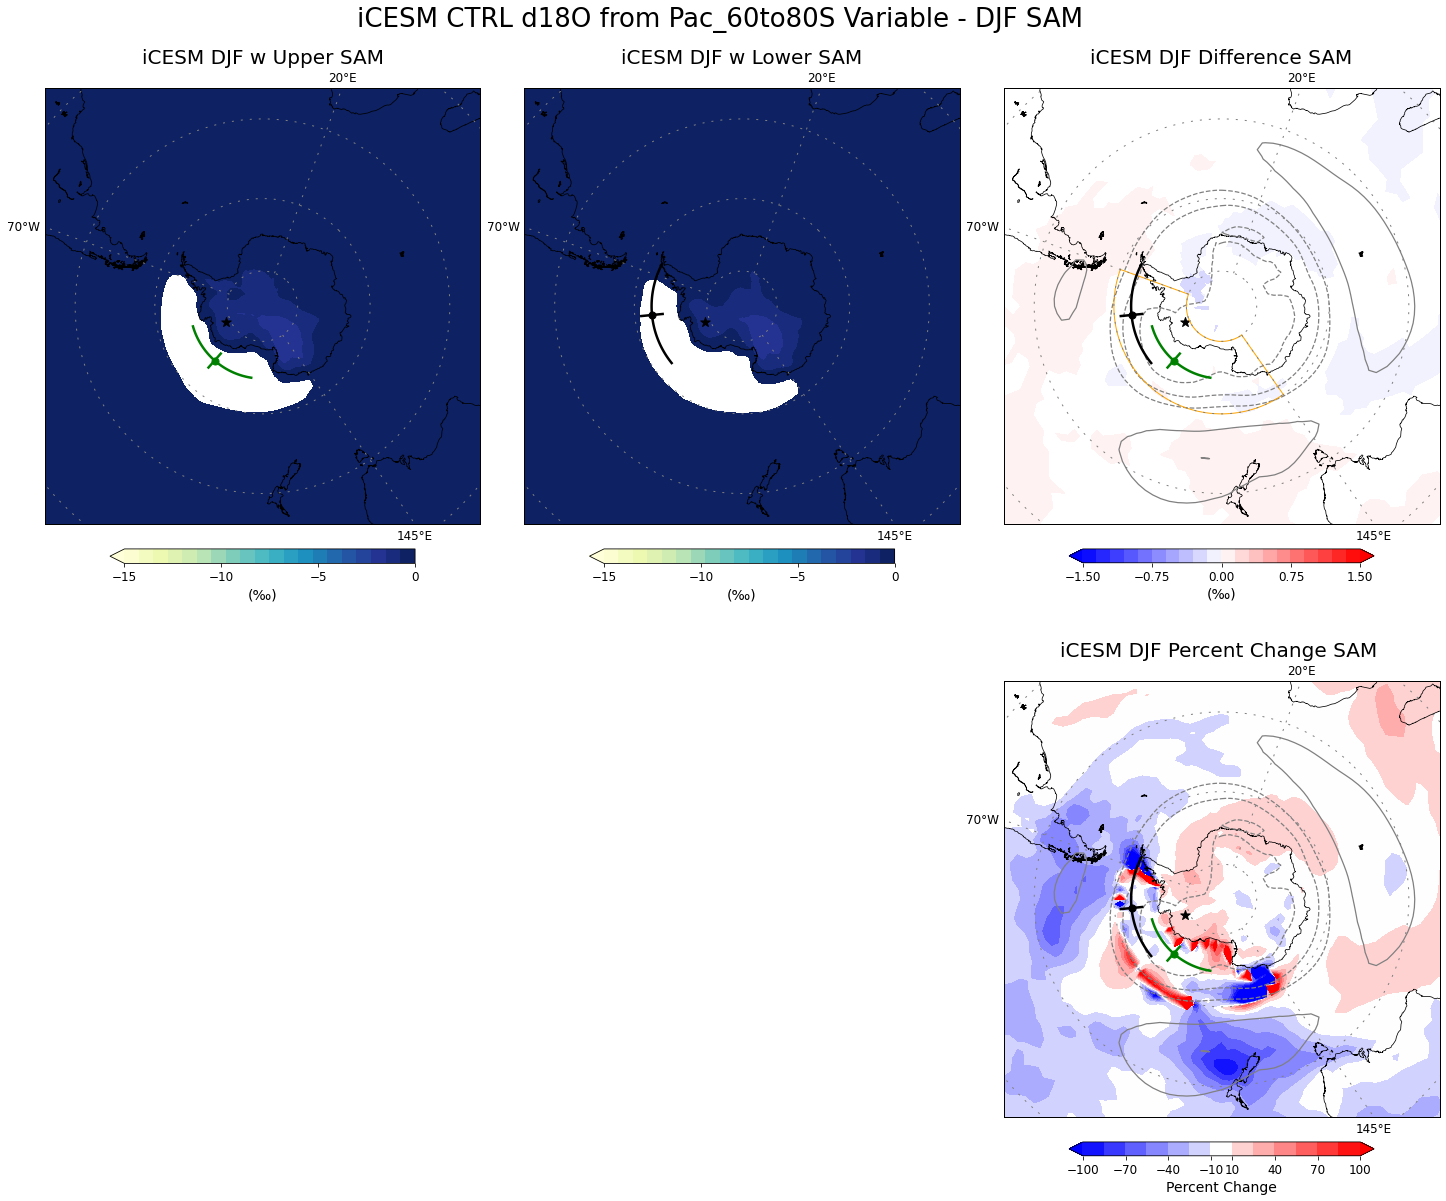

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('iCESM CTRL d18O from Pac_60to80S Variable - DJF SAM', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
meridians2 = [-70.,20.,145]
levels_shade = np.arange(-15,0.75,0.75)
levels_shade_diff = np.arange(-1.5,1.65,.15)
# levels_shade_diff_percentage = np.arange(-400,440,40)
# levels_shade_diff_percentage = [-500,-400,-300,-200,-100,100,200,300,400,500]
levels_shade_diff_percentage = [-100,-85,-70,-55,-40,-25,-10,10,25,40,55,70,85,100]
levels_contour_model_diff = [-2.03,2.03] #two-tailed significant T value for df = 36 or 38 --- works for icesm winter, summer, annual mean
levels_contour_reanalysis_diff = [-2.11,2.11] #two-tailed significant T value for df = 18 --- works for reanalysis winter, summer, annual mean

plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_w_upper_SAM_ctrl,lat_cyclic_w_upper_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_ctrl,lat_slp_cyclic_w_upper_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_upper_SAM_ctrl, lat_orig_w_upper_SAM_ctrl
m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.shape)
CS = m.contourf(x,y,djf_d18O_w_upper_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='min')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cmap1 = copy.copy(plt.cm.rainbow)
# # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-15,5,5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-15,0])
# x_slp, y_slp = m(lon_slp, lat_slp)
# CS2 = m.contour(x_slp,y_slp,(djf_slp_w_upper_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM DJF w Upper SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,djf_d18O_w_lower_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='min')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-15,5,5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-15,0])
# x_slp, y_slp = m(lon_slp, lat_slp)
# CS2 = m.contour(x_slp,y_slp,(djf_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')


#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM DJF w Lower SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)

#add tagged outline
#upper parallel
lat_line = np.linspace(-60,-60,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1) 
#lower parallel
lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#westward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(145,145,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#eastward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(290,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)

x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
# CS = m.contourf(x,y,(djf_d18O_w_upper_SAM_detrended_cyclic_ctrl-djf_d18O_w_lower_SAM_detrended_cyclic_ctrl),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
CS = m.contourf(x,y,np.where(np.abs(diff_djf_d18O_sig_contour_ctrl) >= 2.03, (djf_d18O_w_upper_SAM_detrended_cyclic_ctrl-djf_d18O_w_lower_SAM_detrended_cyclic_ctrl), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
# CS = m.contourf(x,y,np.where(np.abs(diff_djf_tpw_sig_contour_ctrl) >= 2.03, (djf_tpw_w_upper_SAM_detrended_cyclic_ctrl-djf_tpw_w_lower_SAM_detrended_cyclic_ctrl), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-1.5,2.25,0.75))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(djf_slp_w_upper_SAM_detrended_cyclic_ctrl - djf_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM DJF Difference SAM',y=1.045,fontsize=20)


ax[1,0].axis('off')
ax[1,1].axis('off')



plt.subplot(2, 3, 6)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,((djf_d18O_w_upper_SAM_detrended_cyclic_ctrl-djf_d18O_w_lower_SAM_detrended_cyclic_ctrl)/djf_d18O_w_upper_SAM_detrended_cyclic_ctrl)*100,levels_shade_diff_percentage,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('Percent Change',size=14)
# cbar.set_ticks(np.arange(-500,600,200))
cbar.set_ticks([-100,-70,-40,-10,10,40,70,100])
cbar.ax.tick_params(labelsize=12)
plt.clim([-100,100])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(djf_slp_w_upper_SAM_detrended_cyclic_ctrl - djf_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM DJF Percent Change SAM ',y=1.045,fontsize=20)



print(djf_d18O_w_upper_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),djf_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),(djf_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')-djf_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')))
print(((djf_d18O_w_upper_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values - djf_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)/djf_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)*100)


# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_d18Op_at_wdc = djf_d18O_w_upper_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_d18Op_at_wdc = djf_d18O_w_lower_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')

print(upper_d18Op_at_wdc.shape)
print(lower_d18Op_at_wdc.shape)
print(upper_d18Op_at_wdc.mean())
print(lower_d18Op_at_wdc.mean())
print(upper_d18Op_at_wdc.var())
print(lower_d18Op_at_wdc.var())

print(ttest_ind(upper_d18Op_at_wdc, lower_d18Op_at_wdc, equal_var = False))

# plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_d18O_wrt_DJF_SAM_Quartiles_Pac_60to80S_07May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

## For d180wv

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(96, 145)
(96, 145)
(18, 96, 145)


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:138: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:251: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<xarray.DataArray ()>
array(-2.42052358)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(-2.19725905)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0.)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
10.161047542188163
(18,)
(18,)
<xarray.DataArray ()>
array(-2.42052358)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(-2.19725905)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.10562941)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.20624547)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
Ttest_indResult(statistic=-1.6483673710652762, pvalue=0.10944414663648315)


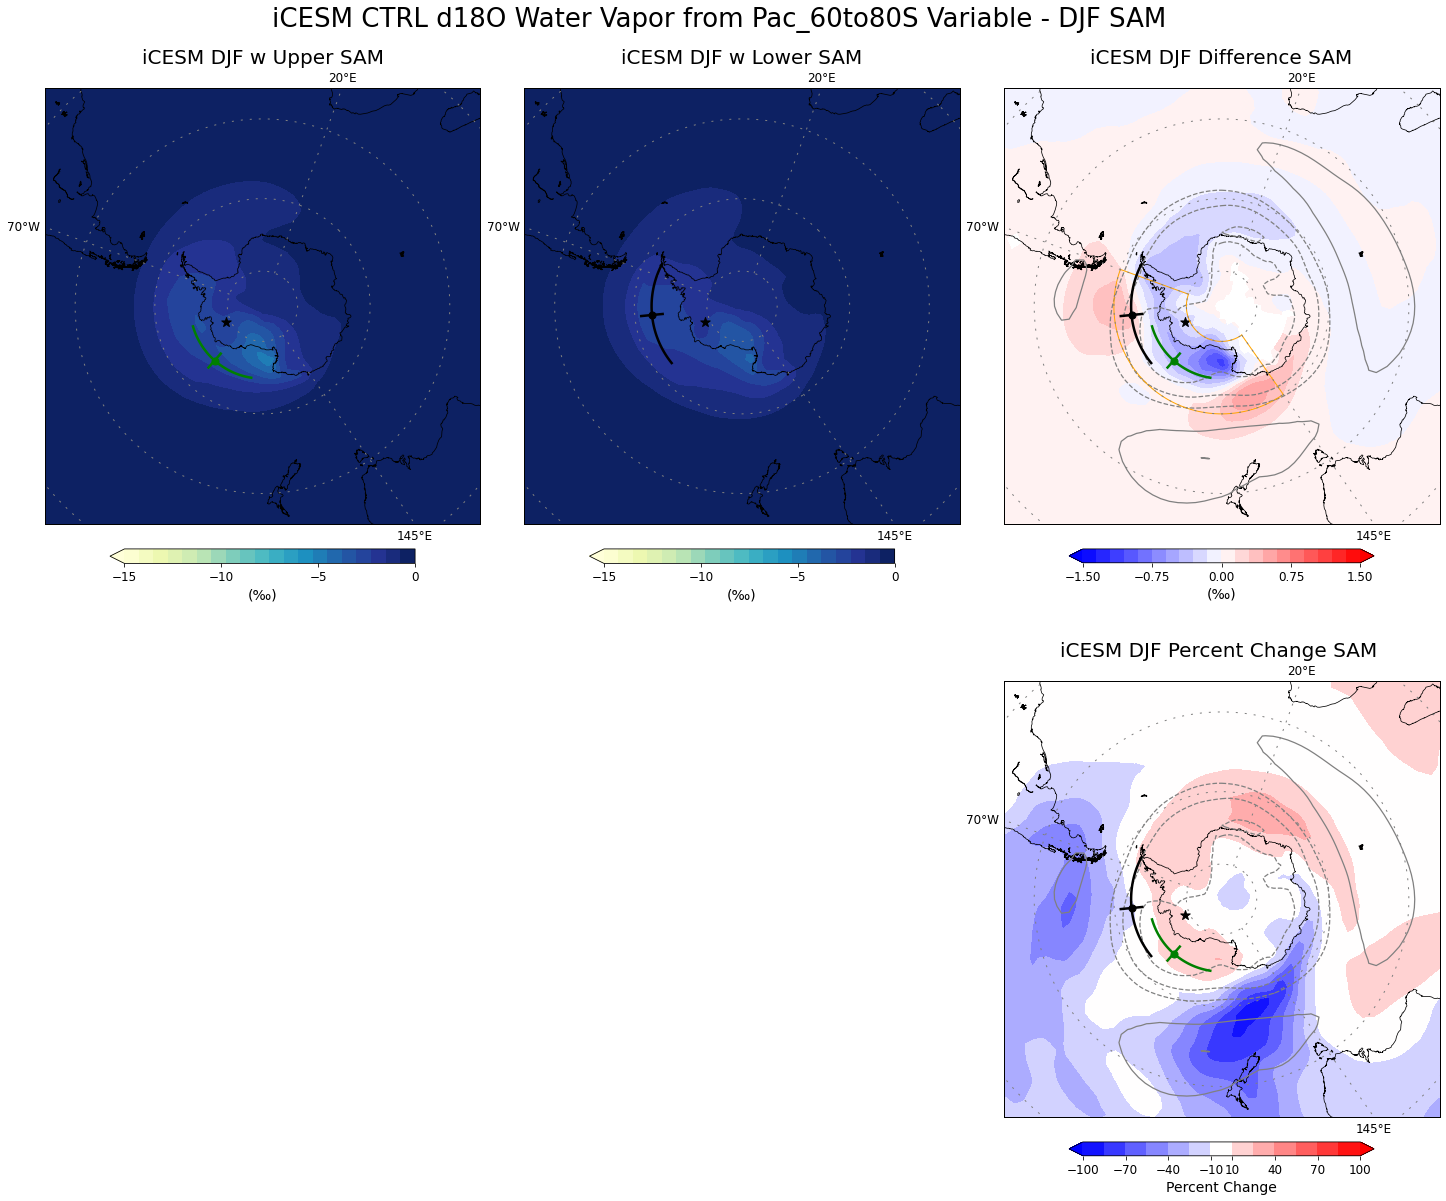

In [56]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('iCESM CTRL d18O Water Vapor from Pac_60to80S Variable - DJF SAM', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
meridians2 = [-70.,20.,145]
levels_shade = np.arange(-15,0.75,0.75)
levels_shade_diff = np.arange(-1.5,1.65,.15)
# levels_shade_diff_percentage = np.arange(-400,440,40)
# levels_shade_diff_percentage = [-500,-400,-300,-200,-100,100,200,300,400,500]
levels_shade_diff_percentage = [-100,-85,-70,-55,-40,-25,-10,10,25,40,55,70,85,100]
levels_contour_model_diff = [-2.03,2.03] #two-tailed significant T value for df = 36 or 38 --- works for icesm winter, summer, annual mean
levels_contour_reanalysis_diff = [-2.11,2.11] #two-tailed significant T value for df = 18 --- works for reanalysis winter, summer, annual mean

plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_w_upper_SAM_ctrl,lat_cyclic_w_upper_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_ctrl,lat_slp_cyclic_w_upper_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_upper_SAM_ctrl, lat_orig_w_upper_SAM_ctrl
m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.shape)
CS = m.contourf(x,y,djf_d18O_V_w_upper_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='min')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cmap1 = copy.copy(plt.cm.rainbow)
# # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-15,5,5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-15,0])
# x_slp, y_slp = m(lon_slp, lat_slp)
# CS2 = m.contour(x_slp,y_slp,(djf_slp_w_upper_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM DJF w Upper SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,djf_d18O_V_w_lower_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='min')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-15,5,5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-15,0])
# x_slp, y_slp = m(lon_slp, lat_slp)
# CS2 = m.contour(x_slp,y_slp,(djf_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')


#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM DJF w Lower SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)

#add tagged outline
#upper parallel
lat_line = np.linspace(-60,-60,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1) 
#lower parallel
lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#westward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(145,145,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#eastward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(290,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)

x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
# CS = m.contourf(x,y,(djf_d18O_V_w_upper_SAM_detrended_cyclic_ctrl-djf_d18O_V_w_lower_SAM_detrended_cyclic_ctrl),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
CS = m.contourf(x,y,np.where(np.abs(diff_djf_d18O_V_sig_contour_ctrl) >= 2.03, (djf_d18O_V_w_upper_SAM_detrended_cyclic_ctrl-djf_d18O_V_w_lower_SAM_detrended_cyclic_ctrl), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
# CS = m.contourf(x,y,np.where(np.abs(diff_djf_tpw_sig_contour_ctrl) >= 2.03, (djf_tpw_w_upper_SAM_detrended_cyclic_ctrl-djf_tpw_w_lower_SAM_detrended_cyclic_ctrl), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-1.5,2.25,0.75))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(djf_slp_w_upper_SAM_detrended_cyclic_ctrl - djf_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM DJF Difference SAM',y=1.045,fontsize=20)


ax[1,0].axis('off')
ax[1,1].axis('off')



plt.subplot(2, 3, 6)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,((djf_d18O_V_w_upper_SAM_detrended_cyclic_ctrl-djf_d18O_V_w_lower_SAM_detrended_cyclic_ctrl)/djf_d18O_V_w_upper_SAM_detrended_cyclic_ctrl)*100,levels_shade_diff_percentage,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('Percent Change',size=14)
# cbar.set_ticks(np.arange(-500,600,200))
cbar.set_ticks([-100,-70,-40,-10,10,40,70,100])
cbar.ax.tick_params(labelsize=12)
plt.clim([-100,100])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(djf_slp_w_upper_SAM_detrended_cyclic_ctrl - djf_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM DJF Percent Change SAM ',y=1.045,fontsize=20)



print(djf_d18O_V_w_upper_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),djf_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),(djf_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')-djf_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')))
print(((djf_d18O_V_w_upper_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values - djf_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)/djf_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)*100)


# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_d18Owv_at_wdc = djf_d18O_V_w_upper_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_d18Owv_at_wdc = djf_d18O_V_w_lower_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')

print(upper_d18Owv_at_wdc.shape)
print(lower_d18Owv_at_wdc.shape)
print(upper_d18Owv_at_wdc.mean())
print(lower_d18Owv_at_wdc.mean())
print(upper_d18Owv_at_wdc.var())
print(lower_d18Owv_at_wdc.var())

print(ttest_ind(upper_d18Owv_at_wdc, lower_d18Owv_at_wdc, equal_var = False))

plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_d18O_Vapor_wrt_DJF_SAM_Quartiles_Pac_60to80S_07May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

## CTRL Ann_Mean

## For IVT

In [57]:
# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_IVT_at_wdc = np.sqrt(ann_mean_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2 + ann_mean_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2)
lower_IVT_at_wdc = np.sqrt(ann_mean_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2 + ann_mean_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2)

print(upper_IVT_at_wdc.shape)
print(lower_IVT_at_wdc.shape)
print(upper_IVT_at_wdc.mean())
print(lower_IVT_at_wdc.mean())
print(upper_IVT_at_wdc.var())
print(lower_IVT_at_wdc.var())

ttest_ind(upper_IVT_at_wdc, lower_IVT_at_wdc, equal_var = False)

(19,)
(19,)
<xarray.DataArray ()>
array(0.73853381)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.50130739)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.03326726)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.0250814)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5


Ttest_indResult(statistic=4.1666195377679935, pvalue=0.00018994661232867854)

In [58]:
# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_tpw_at_wdc = ann_mean_tpw_w_upper_SAM_detrended_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_tpw_at_wdc = ann_mean_tpw_w_lower_SAM_detrended_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
print(upper_tpw_at_wdc.shape)
print(lower_tpw_at_wdc.shape)
print(upper_tpw_at_wdc.mean())
print(lower_tpw_at_wdc.mean())
print(upper_tpw_at_wdc.var())
print(lower_tpw_at_wdc.var())

ttest_ind(upper_tpw_at_wdc, lower_tpw_at_wdc, equal_var = False)

(19,)
(19,)
<xarray.DataArray ()>
array(0.17891102)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.17670801)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.0003681)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.00041733)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5


Ttest_indResult(statistic=0.33350099151498275, pvalue=0.7406984718705019)

In [59]:
# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_d18Op_at_wdc = ann_mean_d18O_w_upper_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_d18Op_at_wdc = ann_mean_d18O_w_lower_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')

print(upper_d18Op_at_wdc.shape)
print(lower_d18Op_at_wdc.shape)
print(upper_d18Op_at_wdc.mean())
print(lower_d18Op_at_wdc.mean())
print(upper_d18Op_at_wdc.var())
print(lower_d18Op_at_wdc.var())

ttest_ind(upper_d18Op_at_wdc, lower_d18Op_at_wdc, equal_var = False)

(19,)
(19,)
<xarray.DataArray ()>
array(-1.9544567, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(-1.6627697, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.03770504)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.04177553)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5


Ttest_indResult(statistic=-4.3895788003663005, pvalue=9.571502626487702e-05)

In [60]:
# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_d18Owv_at_wdc = ann_mean_d18O_V_w_upper_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_d18Owv_at_wdc = ann_mean_d18O_V_w_lower_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')

print(upper_d18Owv_at_wdc.shape)
print(lower_d18Owv_at_wdc.shape)
print(upper_d18Owv_at_wdc.mean())
print(lower_d18Owv_at_wdc.mean())
print(upper_d18Owv_at_wdc.var())
print(lower_d18Owv_at_wdc.var())

ttest_ind(upper_d18Owv_at_wdc, lower_d18Owv_at_wdc, equal_var = False)

(19,)
(19,)
<xarray.DataArray ()>
array(-3.94751172)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(-3.42513079)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.15951296)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.11832533)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5


Ttest_indResult(statistic=-4.204627428168173, pvalue=0.00017043910722746807)

In [61]:
#Prepping data for plotting and differencing of iCESM and MERRA--which are on different grids
#need to add cyclic as well

#iCESM CTRL data
#just need to add cyclic and keep original for vectors
# MAGNITUDE TIME MEAN IS WITHHELD UNTIL PLOTTING, THIS ENSURES CONSISTENCY IN RESULTS BTW THE SIG STATS AND THE PLOT
mag_mean_Pac_60to80S_w_upper_SAM_ctrl = np.sqrt(ann_mean_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl**2 + ann_mean_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl**2)
mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl, lons = add_cyclic_point(mag_mean_Pac_60to80S_w_upper_SAM_ctrl.values, mag_mean_Pac_60to80S_w_upper_SAM_ctrl.coords['lon'].values, axis=-1)
lon_orig_w_upper_SAM_ctrl, lat_orig_w_upper_SAM_ctrl = np.meshgrid(mag_mean_Pac_60to80S_w_upper_SAM_ctrl.coords['lon'].values,mag_mean_Pac_60to80S_w_upper_SAM_ctrl.coords['lat'].values)
lon_cyclic_w_upper_SAM_ctrl, lat_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons,mag_mean_Pac_60to80S_w_upper_SAM_ctrl.coords['lat'].values)
ann_mean_tpw_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_tpw_w_upper_SAM_detrended_ctrl.mean(axis=0).values, ann_mean_tpw_w_upper_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_tpw_cyclic_w_upper_SAM_ctrl, lat_tpw_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, ann_mean_tpw_w_upper_SAM_detrended_ctrl.coords['lat'].values)
#slp and wind are on atmo grid, <- took care of this during plotting
ann_mean_slp_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_slp_w_upper_SAM_detrended_ctrl.mean(axis=0).values, ann_mean_slp_w_upper_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_upper_SAM_ctrl, lat_slp_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, ann_mean_slp_w_upper_SAM_detrended_ctrl.coords['lat'].values)
ann_mean_u10_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_u10_w_upper_SAM_detrended_ctrl.mean(axis=0).values, ann_mean_u10_w_upper_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_upper_SAM_ctrl, lat_u10_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, ann_mean_u10_w_upper_SAM_detrended_ctrl.coords['lat'].values)
ann_mean_v10_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_v10_w_upper_SAM_detrended_ctrl.mean(axis=0).values, ann_mean_v10_w_upper_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_upper_SAM_ctrl, lat_v10_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, ann_mean_v10_w_upper_SAM_detrended_ctrl.coords['lat'].values)
ann_mean_d18O_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_d18O_w_upper_SAM_raw_ctrl.mean(axis=0).values, ann_mean_d18O_w_upper_SAM_raw_ctrl.coords['lon'].values, axis=-1)
lon_d18O_cyclic_w_upper_SAM_ctrl, lat_d18O_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, ann_mean_d18O_w_upper_SAM_raw_ctrl.coords['lat'].values)
ann_mean_d18O_V_w_upper_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_d18O_V_w_upper_SAM_raw_ctrl.mean(axis=0).values, ann_mean_d18O_V_w_upper_SAM_raw_ctrl.coords['lon'].values, axis=-1)
lon_d18O_cyclic_V_w_upper_SAM_ctrl, lat_d18O_V_cyclic_w_upper_SAM_ctrl = np.meshgrid(lons, ann_mean_d18O_V_w_upper_SAM_raw_ctrl.coords['lat'].values)


mag_mean_Pac_60to80S_w_lower_SAM_ctrl = np.sqrt(ann_mean_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl**2 + ann_mean_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl**2)
mag_mean_Pac_60to80S_cyclic_w_lower_SAM_ctrl, lons = add_cyclic_point(mag_mean_Pac_60to80S_w_lower_SAM_ctrl.values, mag_mean_Pac_60to80S_w_lower_SAM_ctrl.coords['lon'].values, axis=-1)
lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl = np.meshgrid(mag_mean_Pac_60to80S_w_lower_SAM_ctrl.coords['lon'].values,mag_mean_Pac_60to80S_w_lower_SAM_ctrl.coords['lat'].values)
lon_cyclic_w_lower_SAM_ctrl, lat_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons,mag_mean_Pac_60to80S_w_lower_SAM_ctrl.coords['lat'].values)
ann_mean_tpw_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_tpw_w_lower_SAM_detrended_ctrl.mean(axis=0).values, ann_mean_tpw_w_lower_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_tpw_cyclic_w_lower_SAM_ctrl, lat_tpw_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, ann_mean_tpw_w_lower_SAM_detrended_ctrl.coords['lat'].values)
ann_mean_slp_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_slp_w_lower_SAM_detrended_ctrl.mean(axis=0).values, ann_mean_slp_w_lower_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_slp_cyclic_w_lower_SAM_ctrl, lat_slp_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, ann_mean_slp_w_lower_SAM_detrended_ctrl.coords['lat'].values)
ann_mean_u10_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_u10_w_lower_SAM_detrended_ctrl.mean(axis=0).values, ann_mean_u10_w_lower_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_u10_cyclic_w_lower_SAM_ctrl, lat_u10_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, ann_mean_u10_w_lower_SAM_detrended_ctrl.coords['lat'].values)
ann_mean_v10_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_v10_w_lower_SAM_detrended_ctrl.mean(axis=0).values, ann_mean_v10_w_lower_SAM_detrended_ctrl.coords['lon'].values, axis=-1)
lon_v10_cyclic_w_lower_SAM_ctrl, lat_v10_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, ann_mean_v10_w_lower_SAM_detrended_ctrl.coords['lat'].values)
ann_mean_d18O_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).values, ann_mean_d18O_w_lower_SAM_raw_ctrl.coords['lon'].values, axis=-1)
lon_d18O_cyclic_w_lower_SAM_ctrl, lat_d18O_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, ann_mean_d18O_w_lower_SAM_raw_ctrl.coords['lat'].values)
ann_mean_d18O_V_w_lower_SAM_detrended_cyclic_ctrl, lons = add_cyclic_point(ann_mean_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).values, ann_mean_d18O_V_w_lower_SAM_raw_ctrl.coords['lon'].values, axis=-1)
lon_d18O_cyclic_V_w_lower_SAM_ctrl, lat_d18O_V_cyclic_w_lower_SAM_ctrl = np.meshgrid(lons, ann_mean_d18O_V_w_lower_SAM_raw_ctrl.coords['lat'].values)


#gather variable for contour of significant change of d18O
ann_mean_d18O_change_due_to_SAM_ttest_stats_ctrl, ann_mean_d18O_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    ann_mean_d18O_w_upper_SAM_raw_ctrl, ann_mean_d18O_w_lower_SAM_raw_ctrl, axis=0)

diff_ann_mean_d18O_sig_contour_ctrl, lons = add_cyclic_point(ann_mean_d18O_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

#gather variable for contour of significant change of d18O Water Vapor
ann_mean_d18O_V_change_due_to_SAM_ttest_stats_ctrl, ann_mean_d18O_V_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    ann_mean_d18O_V_w_upper_SAM_raw_ctrl, ann_mean_d18O_V_w_lower_SAM_raw_ctrl, axis=0)

diff_ann_mean_d18O_V_sig_contour_ctrl, lons = add_cyclic_point(ann_mean_d18O_V_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

#gather variable for contour of significant change of tpw
ann_mean_tpw_change_due_to_SAM_ttest_stats_ctrl, ann_mean_tpw_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    ann_mean_tpw_w_upper_SAM_detrended_ctrl, ann_mean_tpw_w_lower_SAM_detrended_ctrl, axis=0)

diff_ann_mean_tpw_sig_contour_ctrl, lons = add_cyclic_point(ann_mean_tpw_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

#gather variable for contour of significant change of ivt
ann_mean_ivt_change_due_to_SAM_ttest_stats_ctrl, ann_mean_ivt_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    mag_mean_Pac_60to80S_w_upper_SAM_ctrl, mag_mean_Pac_60to80S_w_lower_SAM_ctrl, axis=0)

diff_ann_mean_ivt_sig_contour_ctrl, lons = add_cyclic_point(ann_mean_ivt_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(96, 145)
(96, 145)
(19, 96, 145)


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:203: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<xarray.DataArray ()>
array(0.73853381)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0.50130739)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0.23722642)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
32.121267196008205
(19,)
(19,)
<xarray.DataArray ()>
array(0.73853381)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.50130739)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.03326726)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.0250814)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
Ttest_indResult(statistic=4.1666195377679935, pvalue=0.00018994661232867854)


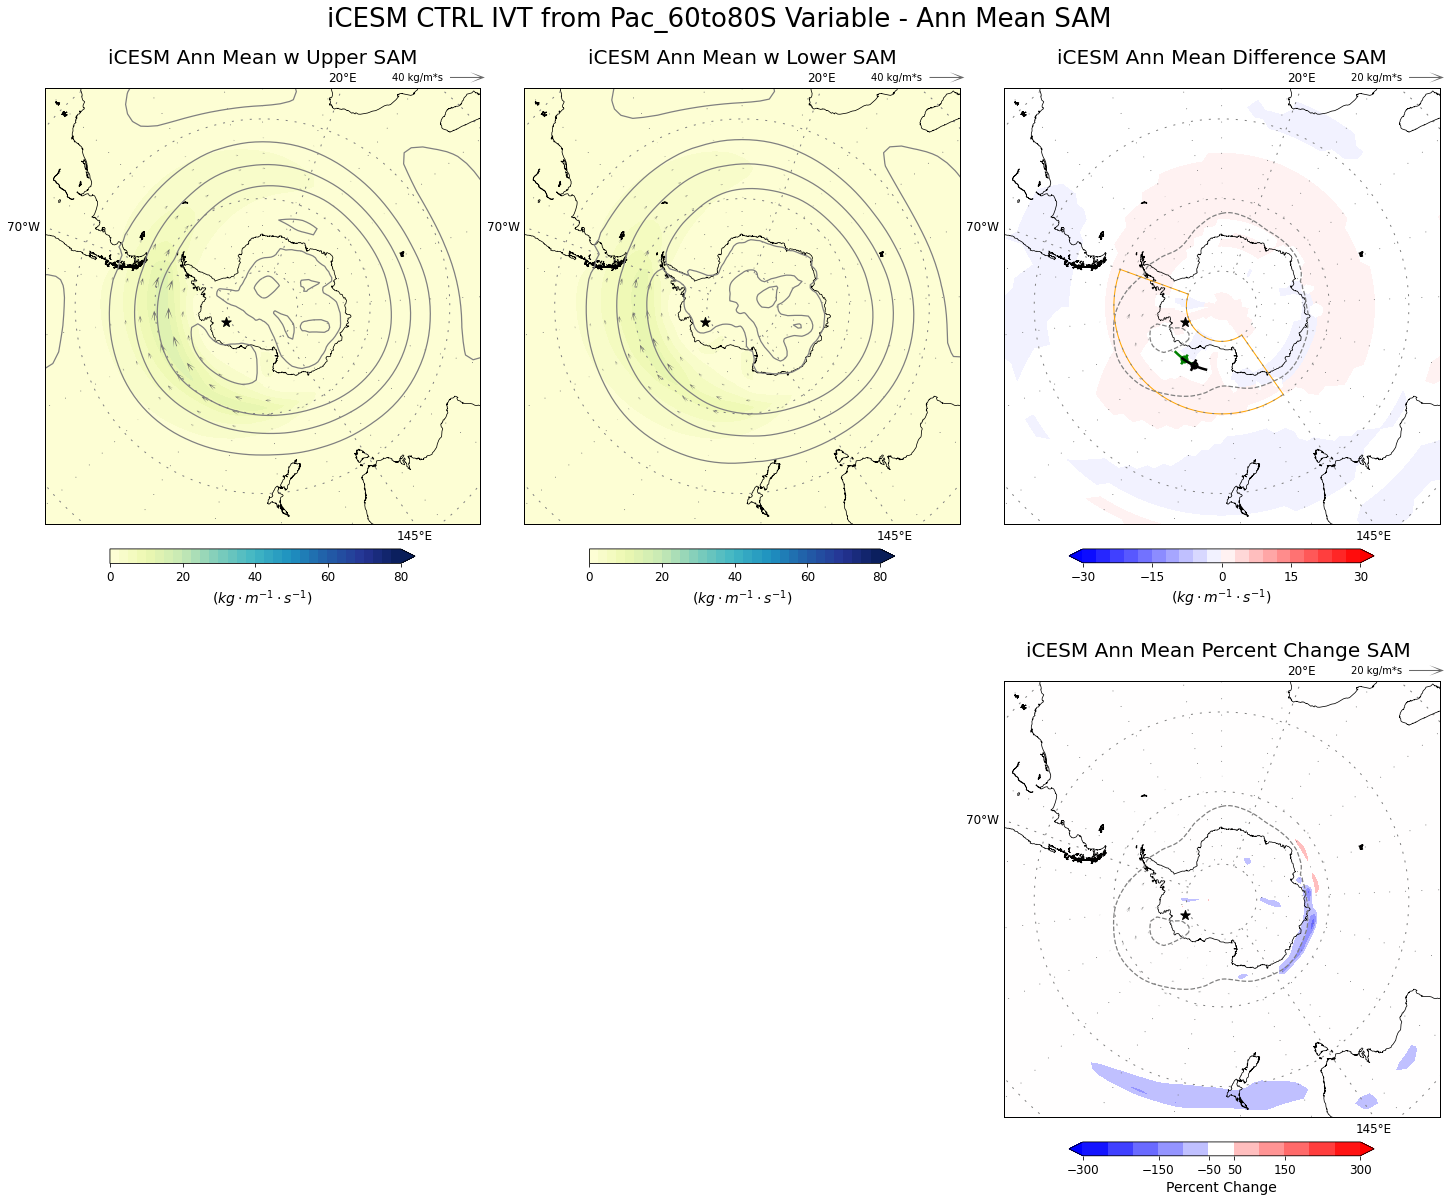

In [62]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('iCESM CTRL IVT from Pac_60to80S Variable - Ann Mean SAM', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
meridians2 = [-70.,20.,145]
levels_shade = np.arange(0,82.5,2.5)
levels_shade_diff = np.arange(-30,33,3)
# levels_shade_diff_percentage = np.arange(-400,440,40)
levels_shade_diff_percentage = [-300,-250,-200,-150,-100,-50,50,100,150,200,250,300]
# levels_shade_diff_percentage = [-500,-450,-400,-350,-300,-250,-200,-150,-100,-50,50,100,150,200,250,300,350,400,450,500]
levels_contour = np.arange(970,1050,10)
levels_contour_diff = [-12,-9,-6,-3,3,6,9,12] #np.arange(-12,15,3)
levels_contour_model_diff = [-2.03,2.03] #two-tailed significant T value for df = 36 or 38 --- works for icesm winter, summer, annual mean
levels_contour_reanalysis_diff = [-2.11,2.11] #two-tailed significant T value for df = 18 --- works for reanalysis winter, summer, annual mean

plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_w_upper_SAM_ctrl,lat_cyclic_w_upper_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_ctrl,lat_slp_cyclic_w_upper_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_upper_SAM_ctrl, lat_orig_w_upper_SAM_ctrl
m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.shape)
CS = m.contourf(x,y,mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.mean(axis=0),levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='max')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cmap1 = copy.copy(plt.cm.rainbow)
# # CS.cmap.set_under('white')
cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(0,100,20))
cbar.ax.tick_params(labelsize=12)
plt.clim([0,80])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_upper_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector(ann_mean_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl.mean(axis=0),ann_mean_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl.mean(axis=0),lon_vec,lat_vec,returnxy=True)
Q = m.quiver(x[6::2,0::7],y[6::2,0::7],(-1)*urot[6::2,0::7],(-1)*vrot[6::2,0::7],latlon=False, scale=500, width=0.0024, headwidth=10, headlength=14, color='dimgray') 
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=40, label='40 kg/m*s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM Ann Mean w Upper SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,mag_mean_Pac_60to80S_cyclic_w_lower_SAM_ctrl.mean(axis=0),levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='max')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(0,100,20))
cbar.ax.tick_params(labelsize=12)
plt.clim([0,80])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector(ann_mean_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl.mean(axis=0),ann_mean_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl.mean(axis=0),lon_vec,lat_vec,returnxy=True)
Q = m.quiver(x[6::2,0::7],y[6::2,0::7],(-1)*urot[6::2,0::7],(-1)*vrot[6::2,0::7],latlon=False, scale=500, width=0.0024, headwidth=10, headlength=14, color='dimgray') 
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=40, label='40 kg/m*s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM Ann Mean w Lower SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)

#add tagged outline
#upper parallel
lat_line = np.linspace(-60,-60,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1) 
#lower parallel
lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#westward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(145,145,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#eastward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(290,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)

x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
# CS = m.contourf(x,y,(mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.mean(axis=0)-mag_mean_Pac_60to80S_cyclic_w_lower_SAM_ctrl.mean(axis=0)),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
CS = m.contourf(x,y,np.where(np.abs(diff_ann_mean_ivt_sig_contour_ctrl) >= 2.03, (mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.mean(axis=0)-mag_mean_Pac_60to80S_cyclic_w_lower_SAM_ctrl.mean(axis=0)), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label(r'($kg \cdot m^{-1} \cdot s^{-1}$)',size=14)
cbar.set_ticks(np.arange(-30,45,15))
cbar.ax.tick_params(labelsize=12)
plt.clim([-30,30])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_upper_SAM_detrended_cyclic_ctrl - ann_mean_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector((ann_mean_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl.mean(axis=0) - ann_mean_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl.mean(axis=0)),(ann_mean_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl.mean(axis=0) - ann_mean_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl.mean(axis=0)),lon_vec,lat_vec,returnxy=True)
Q = m.quiver(x[6::2,0::7],y[6::2,0::7],(-1)*urot[6::2,0::7],(-1)*vrot[6::2,0::7],latlon=False, scale=250, width=0.0024, headwidth=10, headlength=14, color='dimgray') 
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=20, label='20 kg/m*s', labelpos='W')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM Ann Mean Difference SAM',y=1.045,fontsize=20)


ax[1,0].axis('off')
ax[1,1].axis('off')



plt.subplot(2, 3, 6)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,((mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.mean(axis=0)-mag_mean_Pac_60to80S_cyclic_w_lower_SAM_ctrl.mean(axis=0))/mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.mean(axis=0))*100,levels_shade_diff_percentage,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('Percent Change',size=14)
# cbar.set_ticks(np.arange(-500,600,200))
# cbar.set_ticks([-500,-400,-300,-200,-100,100,200,300,400,500])
cbar.set_ticks([-300,-150,-50,50,150,300])
cbar.ax.tick_params(labelsize=12)
plt.clim([-300,300])
plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_upper_SAM_detrended_cyclic_ctrl - ann_mean_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector((ann_mean_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl.mean(axis=0) - ann_mean_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl.mean(axis=0)),(ann_mean_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl.mean(axis=0) - ann_mean_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl.mean(axis=0)),lon_vec,lat_vec,returnxy=True)
Q = m.quiver(x[6::2,0::7],y[6::2,0::7],(-1)*urot[6::2,0::7],(-1)*vrot[6::2,0::7],latlon=False, scale=250, width=0.0024, headwidth=10, headlength=14, color='dimgray') 
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=20, label='20 kg/m*s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM Ann Mean Percent Change SAM ',y=1.045,fontsize=20)


print(mag_mean_Pac_60to80S_w_upper_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),mag_mean_Pac_60to80S_w_lower_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),(mag_mean_Pac_60to80S_w_upper_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')-mag_mean_Pac_60to80S_w_lower_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')))
print(((mag_mean_Pac_60to80S_w_upper_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values - mag_mean_Pac_60to80S_w_lower_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)/mag_mean_Pac_60to80S_w_upper_SAM_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)*100)

# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_IVT_at_wdc = np.sqrt(ann_mean_IVT_H2OV_Zonal_detrended_w_upper_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2 + ann_mean_IVT_H2OV_Meridional_detrended_w_upper_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2)
lower_IVT_at_wdc = np.sqrt(ann_mean_IVT_H2OV_Zonal_detrended_w_lower_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2 + ann_mean_IVT_H2OV_Meridional_detrended_w_lower_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')**2)

print(upper_IVT_at_wdc.shape)
print(lower_IVT_at_wdc.shape)
print(upper_IVT_at_wdc.mean())
print(lower_IVT_at_wdc.mean())
print(upper_IVT_at_wdc.var())
print(lower_IVT_at_wdc.var())

print(ttest_ind(upper_IVT_at_wdc, lower_IVT_at_wdc, equal_var = False))

# plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_IVT_wrt_Ann_Mean_SAM_Quartiles_Pac_60to80S_07May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

## For TPW

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(96, 145)
(96, 145)
(19, 96, 145)


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:201: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<xarray.DataArray ()>
array(0.17891102)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0.17670801)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0.00220301)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
1.231342622094009
(19,)
(19,)
<xarray.DataArray ()>
array(0.17891102)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.17670801)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.0003681)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.00041733)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
Ttest_indResult(statistic=0.33350099151498275, pvalue=0.7406984718705019)


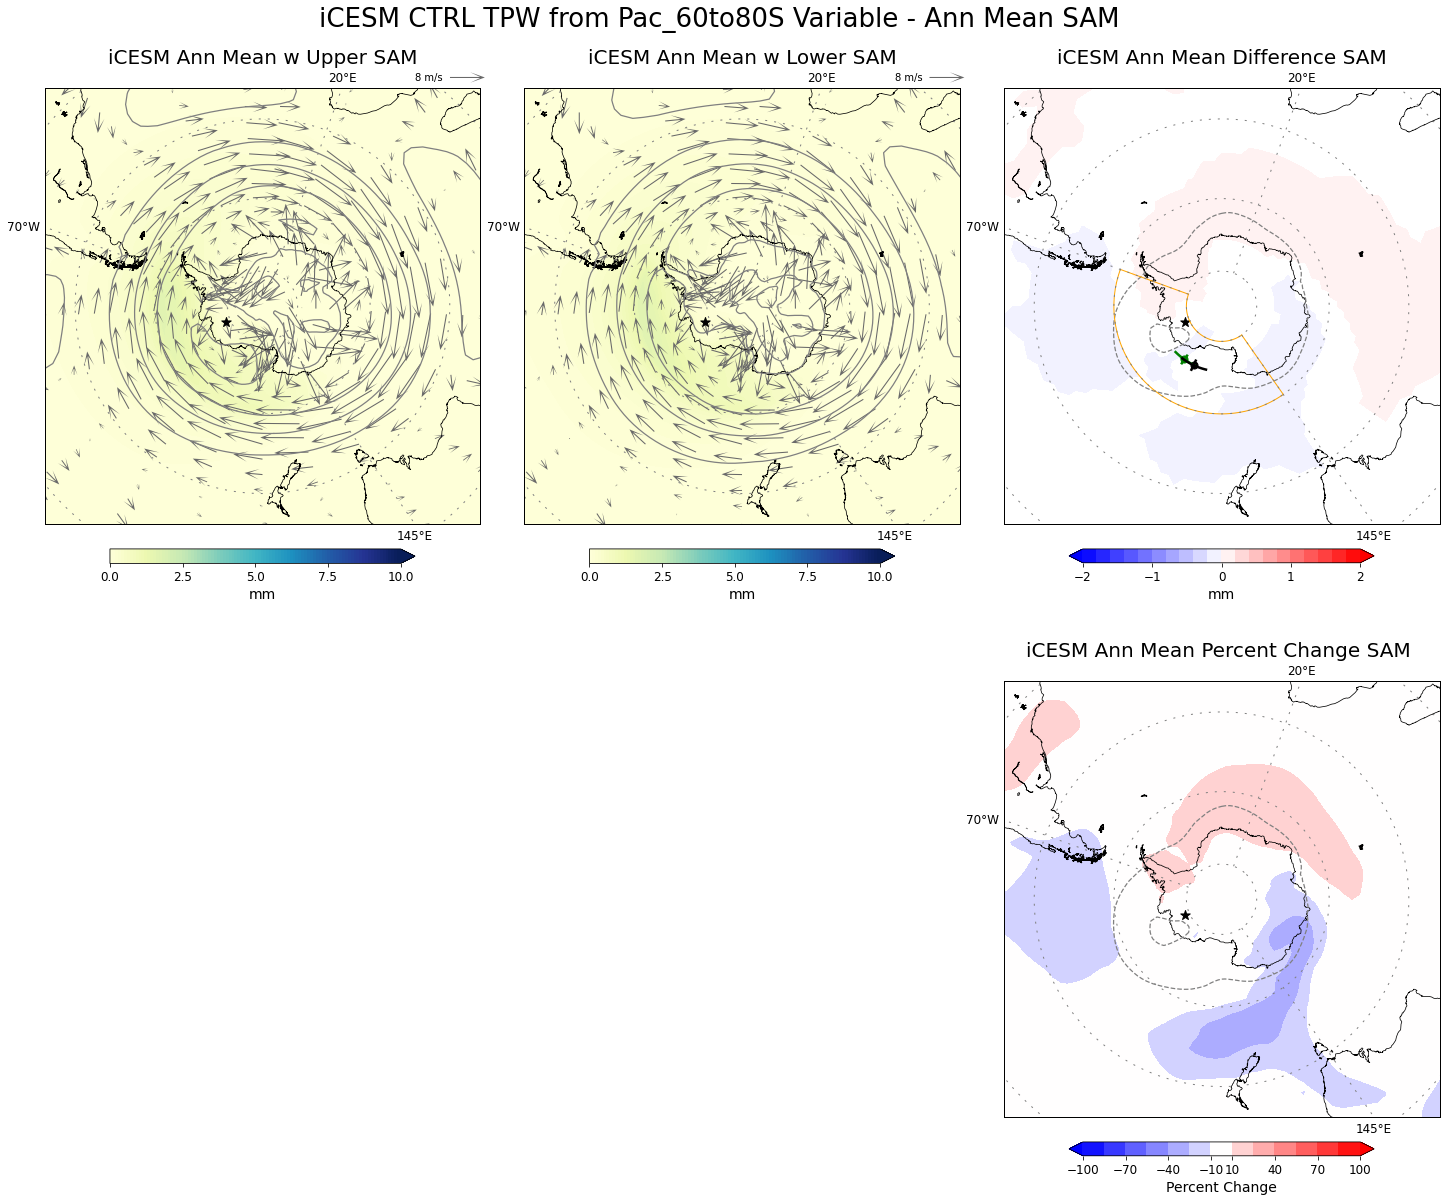

In [63]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('iCESM CTRL TPW from Pac_60to80S Variable - Ann Mean SAM', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
meridians2 = [-70.,20.,145]
levels_shade = np.arange(0,10.1,.1)
levels_shade_diff = np.arange(-2,2.2,.2)
# levels_shade_diff_percentage = np.arange(-400,440,40)
# levels_shade_diff_percentage = [-500,-400,-300,-200,-100,100,200,300,400,500]
levels_shade_diff_percentage = [-100,-85,-70,-55,-40,-25,-10,10,25,40,55,70,85,100]
levels_contour = np.arange(970,1050,10)
levels_contour_diff = [-12,-9,-6,-3,3,6,9,12] #np.arange(-12,15,3)

plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_w_upper_SAM_ctrl,lat_cyclic_w_upper_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_ctrl,lat_slp_cyclic_w_upper_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_upper_SAM_ctrl, lat_orig_w_upper_SAM_ctrl
m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.shape)
CS = m.contourf(x,y,ann_mean_tpw_w_upper_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='max')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cmap1 = copy.copy(plt.cm.rainbow)
# # CS.cmap.set_under('white')
cbar.set_label('mm',size=14)
cbar.set_ticks(np.arange(0,12.5,2.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([0,10])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_upper_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector(ann_mean_u10_w_upper_SAM_detrended_cyclic_ctrl,ann_mean_v10_w_upper_SAM_detrended_cyclic_ctrl,lon_slp,lat_slp,returnxy=True)
Q = m.quiver(x[4::2,2::7],y[4::2,2::7],(-1)*urot[4::2,2::7],(-1)*vrot[4::2,2::7],latlon=False, scale=100, width=0.0024, headwidth=10, headlength=14, color='dimgray')
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=8, label='8 m/s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM Ann Mean w Upper SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,ann_mean_tpw_w_lower_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='max')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # # CS.cmap.set_under('white')
cbar.set_label('mm',size=14)
cbar.set_ticks(np.arange(0,12.5,2.5))
cbar.ax.tick_params(labelsize=12)
plt.clim([0,10])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector(ann_mean_u10_w_lower_SAM_detrended_cyclic_ctrl,ann_mean_v10_w_lower_SAM_detrended_cyclic_ctrl,lon_slp,lat_slp,returnxy=True)
Q = m.quiver(x[4::2,2::7],y[4::2,2::7],(-1)*urot[4::2,2::7],(-1)*vrot[4::2,2::7],latlon=False, scale=100, width=0.0024, headwidth=10, headlength=14, color='dimgray')
qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=8, label='8 m/s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM Ann Mean w Lower SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)

#add tagged outline
#upper parallel
lat_line = np.linspace(-60,-60,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1) 
#lower parallel
lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#westward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(145,145,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#eastward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(290,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)

x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
# CS = m.contourf(x,y,(ann_mean_tpw_w_upper_SAM_detrended_cyclic_ctrl-ann_mean_tpw_w_lower_SAM_detrended_cyclic_ctrl),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
CS = m.contourf(x,y,np.where(np.abs(diff_ann_mean_tpw_sig_contour_ctrl) >= 2.03, (ann_mean_tpw_w_upper_SAM_detrended_cyclic_ctrl-ann_mean_tpw_w_lower_SAM_detrended_cyclic_ctrl), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('mm',size=14)
cbar.set_ticks(np.arange(-2,3,1))
cbar.ax.tick_params(labelsize=12)
plt.clim([-2,2])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_upper_SAM_detrended_cyclic_ctrl - ann_mean_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector((ann_mean_u10_w_upper_SAM_detrended_cyclic_ctrl-ann_mean_u10_w_lower_SAM_detrended_cyclic_ctrl),(ann_mean_v10_w_upper_SAM_detrended_cyclic_ctrl-ann_mean_v10_w_lower_SAM_detrended_cyclic_ctrl),lon_slp,lat_slp,returnxy=True)
# Q = m.quiver(x[4::2,2::7],y[4::2,2::7],(-1)*urot[6::2,4::7],(-1)*vrot[6::2,4::7],latlon=False, scale=37, width=0.0024, headwidth=10, headlength=14, color='dimgray')
# qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=3, label='3 m/s', labelpos='W')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM Ann Mean Difference SAM',y=1.045,fontsize=20)


ax[1,0].axis('off')
ax[1,1].axis('off')



plt.subplot(2, 3, 6)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,((ann_mean_tpw_w_upper_SAM_detrended_cyclic_ctrl-ann_mean_tpw_w_lower_SAM_detrended_cyclic_ctrl)/ann_mean_tpw_w_upper_SAM_detrended_cyclic_ctrl)*100,levels_shade_diff_percentage,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('Percent Change',size=14)
# cbar.set_ticks(np.arange(-500,600,200))
cbar.set_ticks([-100,-70,-40,-10,10,40,70,100])
cbar.ax.tick_params(labelsize=12)
plt.clim([-100,100])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_upper_SAM_detrended_cyclic_ctrl - ann_mean_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')
urot,vrot,x,y = m.rotate_vector((ann_mean_u10_w_upper_SAM_detrended_cyclic_ctrl-ann_mean_u10_w_lower_SAM_detrended_cyclic_ctrl),(ann_mean_v10_w_upper_SAM_detrended_cyclic_ctrl-ann_mean_v10_w_lower_SAM_detrended_cyclic_ctrl),lon_slp,lat_slp,returnxy=True)
# Q = m.quiver(x[4::2,2::7],y[4::2,2::7],(-1)*urot[6::2,4::7],(-1)*vrot[6::2,4::7],latlon=False, scale=37, width=0.0024, headwidth=10, headlength=14, color='dimgray')
# qk = plt.quiverkey(Q, X=0.93, Y=1.025, U=3, label='3 m/s', labelpos='W')
# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM Ann Mean Percent Change SAM ',y=1.045,fontsize=20)


print(ann_mean_tpw_w_upper_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),ann_mean_tpw_w_lower_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),(ann_mean_tpw_w_upper_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')-ann_mean_tpw_w_lower_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')))
print(((ann_mean_tpw_w_upper_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values - ann_mean_tpw_w_lower_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)/ann_mean_tpw_w_upper_SAM_detrended_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)*100)

# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_tpw_at_wdc = ann_mean_tpw_w_upper_SAM_detrended_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_tpw_at_wdc = ann_mean_tpw_w_lower_SAM_detrended_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
print(upper_tpw_at_wdc.shape)
print(lower_tpw_at_wdc.shape)
print(upper_tpw_at_wdc.mean())
print(lower_tpw_at_wdc.mean())
print(upper_tpw_at_wdc.var())
print(lower_tpw_at_wdc.var())

print(ttest_ind(upper_tpw_at_wdc, lower_tpw_at_wdc, equal_var = False))

# plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_TPW_wrt_Ann_Mean_SAM_Quartiles_Pac_60to80S_07May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

## For d180p

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(96, 145)
(96, 145)
(19, 96, 145)


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:138: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:252: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<xarray.DataArray ()>
array(-1.9544566, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(-1.6627698, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0., dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
17.542222142219543
(19,)
(19,)
<xarray.DataArray ()>
array(-1.9544567, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(-1.6627697, dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.03770504)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.04177553)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
Ttest_indResult(statistic=-4.3895788003663005, pvalue=9.571502626487702e-05)


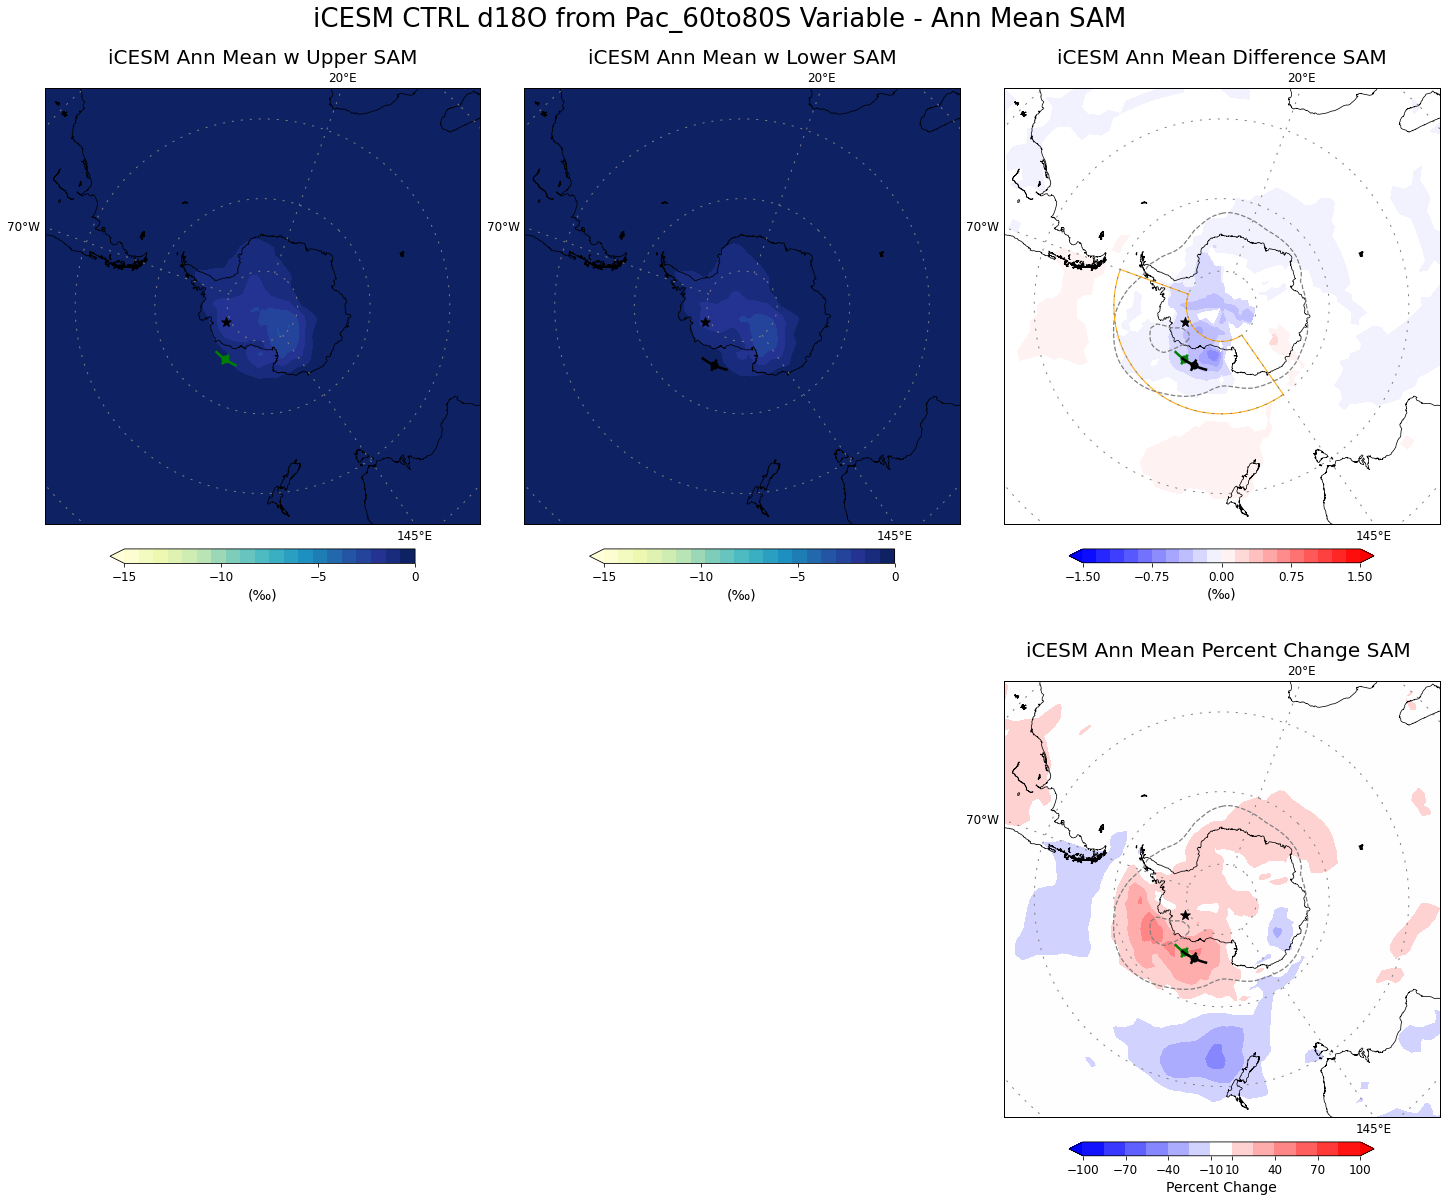

In [64]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('iCESM CTRL d18O from Pac_60to80S Variable - Ann Mean SAM', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
meridians2 = [-70.,20.,145]
levels_shade = np.arange(-15,0.75,0.75)
levels_shade_diff = np.arange(-1.5,1.65,.15)
# levels_shade_diff_percentage = np.arange(-400,440,40)
# levels_shade_diff_percentage = [-500,-400,-300,-200,-100,100,200,300,400,500]
levels_shade_diff_percentage = [-100,-85,-70,-55,-40,-25,-10,10,25,40,55,70,85,100]
levels_contour_model_diff = [-2.03,2.03] #two-tailed significant T value for df = 36 or 38 --- works for icesm winter, summer, annual mean
levels_contour_reanalysis_diff = [-2.11,2.11] #two-tailed significant T value for df = 18 --- works for reanalysis winter, summer, annual mean

plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_w_upper_SAM_ctrl,lat_cyclic_w_upper_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_ctrl,lat_slp_cyclic_w_upper_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_upper_SAM_ctrl, lat_orig_w_upper_SAM_ctrl
m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.shape)
CS = m.contourf(x,y,ann_mean_d18O_w_upper_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='min')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cmap1 = copy.copy(plt.cm.rainbow)
# # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-15,5,5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-15,0])
# x_slp, y_slp = m(lon_slp, lat_slp)
# CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_upper_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM Ann Mean w Upper SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,ann_mean_d18O_w_lower_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='min')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-15,5,5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-15,0])
# x_slp, y_slp = m(lon_slp, lat_slp)
# CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')


#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM Ann Mean w Lower SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)

#add tagged outline
#upper parallel
lat_line = np.linspace(-60,-60,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1) 
#lower parallel
lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#westward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(145,145,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#eastward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(290,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)

x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
# CS = m.contourf(x,y,(ann_mean_d18O_w_upper_SAM_detrended_cyclic_ctrl-ann_mean_d18O_w_lower_SAM_detrended_cyclic_ctrl),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
CS = m.contourf(x,y,np.where(np.abs(diff_ann_mean_d18O_sig_contour_ctrl) >= 2.03, (ann_mean_d18O_w_upper_SAM_detrended_cyclic_ctrl-ann_mean_d18O_w_lower_SAM_detrended_cyclic_ctrl), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
# CS = m.contourf(x,y,np.where(np.abs(diff_ann_mean_tpw_sig_contour_ctrl) >= 2.03, (ann_mean_tpw_w_upper_SAM_detrended_cyclic_ctrl-ann_mean_tpw_w_lower_SAM_detrended_cyclic_ctrl), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-1.5,2.25,0.75))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_upper_SAM_detrended_cyclic_ctrl - ann_mean_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')


#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM Ann Mean Difference SAM',y=1.045,fontsize=20)


ax[1,0].axis('off')
ax[1,1].axis('off')



plt.subplot(2, 3, 6)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,((ann_mean_d18O_w_upper_SAM_detrended_cyclic_ctrl-ann_mean_d18O_w_lower_SAM_detrended_cyclic_ctrl)/ann_mean_d18O_w_upper_SAM_detrended_cyclic_ctrl)*100,levels_shade_diff_percentage,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('Percent Change',size=14)
# cbar.set_ticks(np.arange(-500,600,200))
cbar.set_ticks([-100,-70,-40,-10,10,40,70,100])
cbar.ax.tick_params(labelsize=12)
plt.clim([-100,100])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_upper_SAM_detrended_cyclic_ctrl - ann_mean_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM Ann Mean Percent Change SAM ',y=1.045,fontsize=20)



print(ann_mean_d18O_w_upper_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),ann_mean_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),(ann_mean_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')-ann_mean_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')))
print(((ann_mean_d18O_w_upper_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values - ann_mean_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)/ann_mean_d18O_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)*100)


# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_d18Op_at_wdc = ann_mean_d18O_w_upper_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_d18Op_at_wdc = ann_mean_d18O_w_lower_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')

print(upper_d18Op_at_wdc.shape)
print(lower_d18Op_at_wdc.shape)
print(upper_d18Op_at_wdc.mean())
print(lower_d18Op_at_wdc.mean())
print(upper_d18Op_at_wdc.var())
print(lower_d18Op_at_wdc.var())

print(ttest_ind(upper_d18Op_at_wdc, lower_d18Op_at_wdc, equal_var = False))

# plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_d18O_wrt_Ann_Mean_SAM_Quartiles_Pac_60to80S_07May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

## For d180wv

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(96, 145)
(96, 145)
(19, 96, 145)


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:138: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:252: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<xarray.DataArray ()>
array(-3.94751172)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(-3.42513079)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5 <xarray.DataArray ()>
array(0.)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
15.25141549521177
(19,)
(19,)
<xarray.DataArray ()>
array(-3.94751172)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(-3.42513079)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.15951296)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
<xarray.DataArray ()>
array(0.11832533)
Coordinates:
    lat      float64 -78.63
    lon      float64 247.5
Ttest_indResult(statistic=-4.204627428168173, pvalue=0.00017043910722746807)


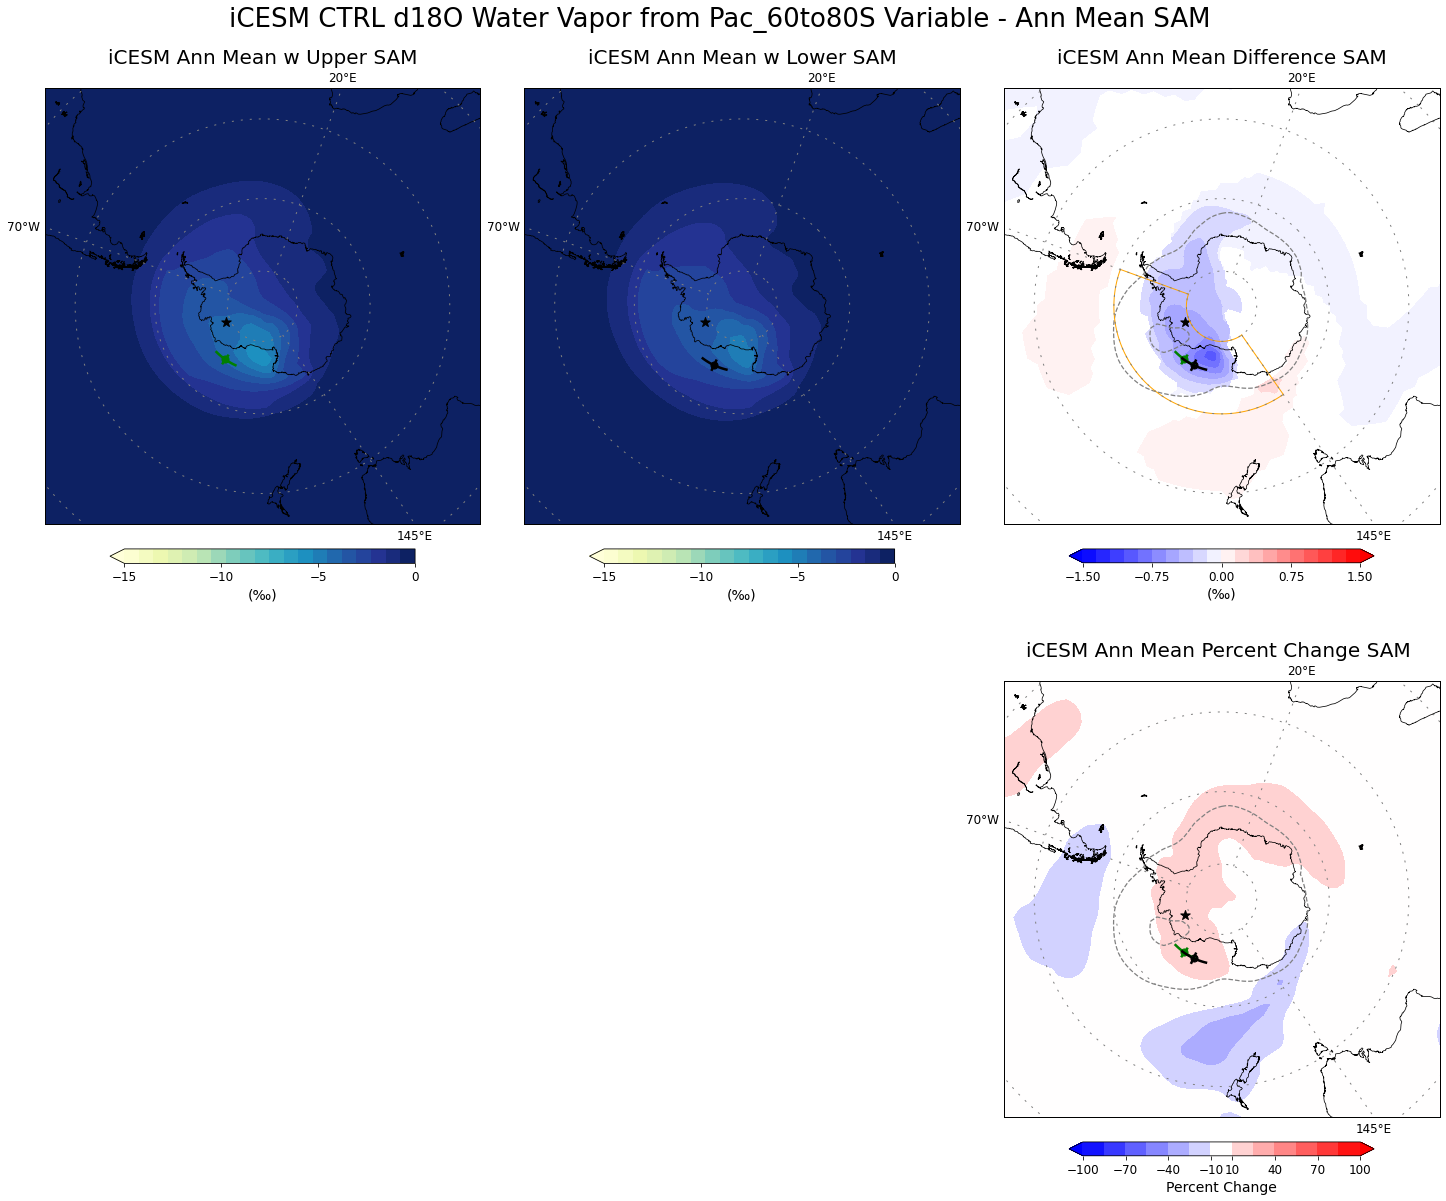

In [65]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('iCESM CTRL d18O Water Vapor from Pac_60to80S Variable - Ann Mean SAM', fontsize=26, y=.925)

parallels = np.arange(-80,-1,20)
# meridians = np.arange(0,360,30.)
meridians2 = [-70.,20.,145]
levels_shade = np.arange(-15,0.75,0.75)
levels_shade_diff = np.arange(-1.5,1.65,.15)
# levels_shade_diff_percentage = np.arange(-400,440,40)
# levels_shade_diff_percentage = [-500,-400,-300,-200,-100,100,200,300,400,500]
levels_shade_diff_percentage = [-100,-85,-70,-55,-40,-25,-10,10,25,40,55,70,85,100]
levels_contour_model_diff = [-2.03,2.03] #two-tailed significant T value for df = 36 or 38 --- works for icesm winter, summer, annual mean
levels_contour_reanalysis_diff = [-2.11,2.11] #two-tailed significant T value for df = 18 --- works for reanalysis winter, summer, annual mean

plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

plt.subplot(2, 3, 1)
lon, lat = lon_cyclic_w_upper_SAM_ctrl,lat_cyclic_w_upper_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_upper_SAM_ctrl,lat_slp_cyclic_w_upper_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_upper_SAM_ctrl, lat_orig_w_upper_SAM_ctrl
m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
print(x.shape)
print(y.shape)
print(mag_mean_Pac_60to80S_cyclic_w_upper_SAM_ctrl.shape)
CS = m.contourf(x,y,ann_mean_d18O_V_w_upper_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='min')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# cmap1 = copy.copy(plt.cm.rainbow)
# # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-15,5,5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-15,0])
# x_slp, y_slp = m(lon_slp, lat_slp)
# CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_upper_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM Ann Mean w Upper SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 2)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,ann_mean_d18O_V_w_lower_SAM_detrended_cyclic_ctrl,levels_shade,cmap=plt.cm.get_cmap('YlGnBu'),alpha=1,extend='min')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-15,5,5))
cbar.ax.tick_params(labelsize=12)
plt.clim([-15,0])
# x_slp, y_slp = m(lon_slp, lat_slp)
# CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour,linewidths=1.25,colors='gray')


#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM Ann Mean w Lower SAM',y=1.045,fontsize=20)


plt.subplot(2, 3, 3)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)

#add tagged outline
#upper parallel
lat_line = np.linspace(-60,-60,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1) 
#lower parallel
lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(145,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#westward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(145,145,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)
#eastward meridian
lat_line = np.linspace(-60,-80,100) 
lon_line = np.linspace(290,290,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='orange', linewidth=1)

x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
# CS = m.contourf(x,y,(ann_mean_d18O_V_w_upper_SAM_detrended_cyclic_ctrl-ann_mean_d18O_V_w_lower_SAM_detrended_cyclic_ctrl),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
CS = m.contourf(x,y,np.where(np.abs(diff_ann_mean_d18O_V_sig_contour_ctrl) >= 2.03, (ann_mean_d18O_V_w_upper_SAM_detrended_cyclic_ctrl-ann_mean_d18O_V_w_lower_SAM_detrended_cyclic_ctrl), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
# CS = m.contourf(x,y,np.where(np.abs(diff_ann_mean_tpw_sig_contour_ctrl) >= 2.03, (ann_mean_tpw_w_upper_SAM_detrended_cyclic_ctrl-ann_mean_tpw_w_lower_SAM_detrended_cyclic_ctrl), np.nan),levels_shade_diff,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('(‰)',size=14)
cbar.set_ticks(np.arange(-1.5,2.25,0.75))
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
plt.rcParams['contour.negative_linestyle'] = 'dashed'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_upper_SAM_detrended_cyclic_ctrl - ann_mean_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')


#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM Ann Mean Difference SAM',y=1.045,fontsize=20)


ax[1,0].axis('off')
ax[1,1].axis('off')



plt.subplot(2, 3, 6)
lon, lat = lon_cyclic_w_lower_SAM_ctrl,lat_cyclic_w_lower_SAM_ctrl
lon_slp, lat_slp = lon_slp_cyclic_w_lower_SAM_ctrl,lat_slp_cyclic_w_lower_SAM_ctrl
lon_vec, lat_vec = lon_orig_w_lower_SAM_ctrl, lat_orig_w_lower_SAM_ctrl

m = Basemap(llcrnrlon=-135,llcrnrlat=-15,urcrnrlon=45,urcrnrlat=-15,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-89,lat_0=-90,lon_0=180.)
x, y = m(lon, lat)
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[2, 7],fontsize=12,color='gray')
m.drawmeridians(meridians2,labels=[True,False,True,True],dashes=[2, 7],fontsize=12,color='gray')
m.drawcoastlines(linewidth=.75,color='black')
m.drawmapboundary(fill_color='white')
CS = m.contourf(x,y,((ann_mean_d18O_V_w_upper_SAM_detrended_cyclic_ctrl-ann_mean_d18O_V_w_lower_SAM_detrended_cyclic_ctrl)/ann_mean_d18O_V_w_upper_SAM_detrended_cyclic_ctrl)*100,levels_shade_diff_percentage,cmap=plt.cm.get_cmap('bwr'),alpha=1,extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.05)
# # CS.cmap.set_under('white')
cbar.set_label('Percent Change',size=14)
# cbar.set_ticks(np.arange(-500,600,200))
cbar.set_ticks([-100,-70,-40,-10,10,40,70,100])
cbar.ax.tick_params(labelsize=12)
plt.clim([-100,100])
x_slp, y_slp = m(lon_slp, lat_slp)
CS2 = m.contour(x_slp,y_slp,(ann_mean_slp_w_upper_SAM_detrended_cyclic_ctrl - ann_mean_slp_w_lower_SAM_detrended_cyclic_ctrl),levels_contour_diff,linewidths=1.25,colors='gray')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'
#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2.5)

#add Rel. CP mean location for upper and lower indice
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=50) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='black', linewidth=2.5)

# add point for WDC
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
plt.title('iCESM Ann Mean Percent Change SAM ',y=1.045,fontsize=20)



print(ann_mean_d18O_V_w_upper_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),ann_mean_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest'),(ann_mean_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')-ann_mean_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest')))
print(((ann_mean_d18O_V_w_upper_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values - ann_mean_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)/ann_mean_d18O_V_w_lower_SAM_raw_ctrl.mean(axis=0).sel(lat=-78.63, lon=247.5, method='nearest').values)*100)


# Calculate T statistics : are the two means (upper and lower) equal to each other?
upper_d18Owv_at_wdc = ann_mean_d18O_V_w_upper_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
lower_d18Owv_at_wdc = ann_mean_d18O_V_w_lower_SAM_raw_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')

print(upper_d18Owv_at_wdc.shape)
print(lower_d18Owv_at_wdc.shape)
print(upper_d18Owv_at_wdc.mean())
print(lower_d18Owv_at_wdc.mean())
print(upper_d18Owv_at_wdc.var())
print(lower_d18Owv_at_wdc.var())

print(ttest_ind(upper_d18Owv_at_wdc, lower_d18Owv_at_wdc, equal_var = False))

plt.savefig(FIG_PATH+'/Figure_iCESM_CTRL_TAGGED_d18O_Vapor_wrt_Ann_Mean_SAM_Quartiles_Pac_60to80S_07May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()